# **Brain Tumor Classification**

<a id="1"></a>
# 1. Dataset : 
1. 1 [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [1]:
# !pip list

<a id="2"></a>
#  2. Install required packages

In [2]:
# for new conda env excep keggle Machine config
# !pip install --upgrade pip
# !pip install ipywidgets
# !pip install pydot

# # only keggle 
# !sudo apt-get update
# !sudo apt-get install libgl1-mesa-glx
# !apt-get update
# !apt-get install -y libgl1-mesa-glx

!pip install wandb
# !pip install tensorflow[and-cuda]

# !pip uninstall -y tensorboard tb-nightly && pip install tb-nightly  

# !pip install tensorflow tensorflow-addons


!pip install pandarallel

!pip install tabulate
!pip install tf-keras-vis

# !pip install --unstable-feature=resolver

# !pip check

  Preparing metadata (setup.py) ... - done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=792c4b63717b2fd7c579d472350f2c68367bcbb1e0d4d2c7b0ac84453ba21d5b
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.5 MB/s eta 0:00:00


In [3]:
# for CPU information
!lscpu

Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Byte Order:                           Little Endian
Address sizes:                        46 bits physical, 48 bits virtual
CPU(s):                               4
On-line CPU(s) list:                  0-3
Thread(s) per core:                   2
Core(s) per socket:                   2
Socket(s):                            1
NUMA node(s):                         1
Vendor ID:                            GenuineIntel
CPU family:                           6
Model:                                85
Model name:                           Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                             3
CPU MHz:                              2000.166
BogoMIPS:                             4000.33
Hypervisor vendor:                    KVM
Virtualization type:                  full
L1d cache:                            64 KiB
L1i cache:                            64 KiB
L2 cache:                  

In [4]:
# for GPU information
!nvidia-smi

Tue Jul  1 08:18:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<a id="3"></a>
# 3. Import required packages

In [5]:
import os
import shutil
import datetime
import pytz
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, BatchNormalization,Activation,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, matthews_corrcoef
from tabulate import tabulate

import glob

import ipywidgets as widgets
import io

from PIL import Image

import tqdm
from tqdm.notebook import tqdm; 
tqdm.pandas(); # get nice bar


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Set XLA flags
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

# Clear previous session
tf.keras.backend.clear_session()

# Seed for reproducibility
seed = 1234
np.random.seed(seed)
np.set_printoptions(precision=3, suppress=True)

# Get current time in a formatted way
def getNowDateTime():
    """Return the current date and time formatted as a string."""
    now = datetime.datetime.now(pytz.timezone("Asia/Colombo"))
    return now.strftime("%Y-%m-%d-%H-%M-%S")

def clean_working_directory():
    """Remove all files and directories in the current working directory except .h5 files."""
    for file_name in os.listdir("./"):
        if file_name.endswith(".h5"):
            continue
        try:
            file_path = os.path.join("./", file_name)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
                print(f"Removed File: {file_name}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
                print(f"Removed Directory: {file_name}")
        except Exception as e:
            print('Exception:', e)

def remove_keras_files():
    """Remove all .keras files in the current working directory."""
    for file_name in os.listdir("./"):
        if file_name.endswith(".keras"):
            try:
                file_path = os.path.join("./", file_name)
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                    print(f"Removed .keras File: {file_name}")
            except Exception as e:
                print('Exception:', e)

# Clean the working directory
clean_working_directory()

# Remove .keras files
remove_keras_files()


2025-07-01 08:18:22.284035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-01 08:18:22.284190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-01 08:18:22.433361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Removed File: __notebook__.ipynb


In [6]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


<a id="4"></a>
# 4. TensorBoard and WanDB related code 

In [7]:
# Clear any logs from previous wandb_runs
!rm -rf ./logs/ 
!mkdir ./logs/

# secrete import from keggle store
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

secret_value_0 = user_secrets.get_secret("auth")

# Run tensorboard
import os
import multiprocessing

pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [f"tensorboard --logdir ./logs/ --load_fast true --host 0.0.0.0 --port 5006 &"]]

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


<a id="5"></a>
# 5. Common Configuration for Current Phase

Image belongs to meningioma. Width: 512, Height: 512, Size: 0.02 MB

Image belongs to glioma. Width: 512, Height: 512, Size: 0.02 MB

Image belongs to notumor. Width: 630, Height: 630, Size: 0.05 MB

Image belongs to pituitary. Width: 512, Height: 512, Size: 0.03 MB



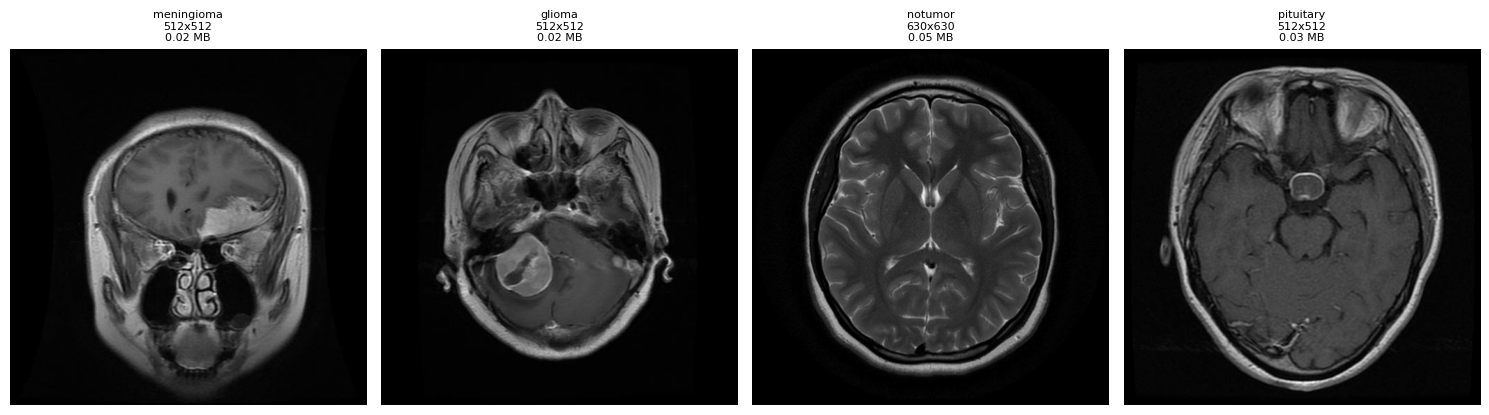

In [8]:
def get_image_details(category, image_path):
    # Open the image
    image = Image.open(image_path)
    # Get image size (width and height)
    width, height = image.size
    # Get image storage size in bytes
    storage_size = os.path.getsize(image_path)
    # Convert storage size to MB
    storage_size_mb = storage_size / (1024 * 1024)
    print(f"Image belongs to {category}. Width: {width}, Height: {height}, Size: {storage_size_mb:.2f} MB\n")
    return image, f"{category}\n{width}x{height}\n{storage_size_mb:.2f} MB"

# Define the test images
test_images = [
    ['meningioma', '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0000.jpg'],
    ['glioma', '/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0021.jpg'],
    ['notumor', '/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-no_0011.jpg'],
    ['pituitary', '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0012.jpg']
]

# Plot images in a single row
fig, axes = plt.subplots(1, len(test_images), figsize=(15, 5))
for i, (category, image_path) in enumerate(test_images):
    try:
        image, details = get_image_details(category, image_path)
        axes[i].imshow(image)
        axes[i].set_title(details, fontsize=8)
        axes[i].axis('off')  # Hide axes for better visualization
    except Exception as e:
        print(f"Error processing {category}: {e}")

plt.tight_layout()
plt.show()

# This project name should be taken from the wandb
wandb_project_name = "deep-learning-approaches-for-brain-tumor-detection"
image_size = 224
batch_size = 16
learning_rate = 0.001
epochs_count = 100
num_classes = 4

secret_value_1 = user_secrets.get_secret("wandb_api_key")
# wandb_run wandb
import wandb

<a id="6"></a>
# 6. Image paths stores to array

Brain Tumor Image Training Counts:
╔═══════════════╦═══════════════════════╗
║   Image Count ║  Type of Brain Tumor  ║
╠═══════════════╬═══════════════════════╣
║          1321 ║        Glioma         ║
║          1339 ║      Meningioma       ║
║          1595 ║        Notumor        ║
║          1457 ║       Pituitary       ║
╚═══════════════╩═══════════════════════╝

 Brain Tumor Image Test Counts:
╔═══════════════╦═══════════════════════╗
║   Image Count ║  Type of Brain Tumor  ║
╠═══════════════╬═══════════════════════╣
║           300 ║        Glioma         ║
║           306 ║      Meningioma       ║
║           405 ║        Notumor        ║
║           300 ║       Pituitary       ║
╚═══════════════╩═══════════════════════╝


2025-07-01 08:18:38.789796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-01 08:18:38.789855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-01 08:18:38.791435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


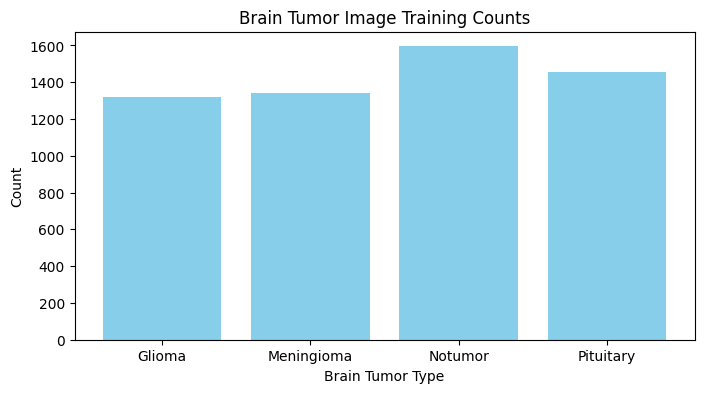

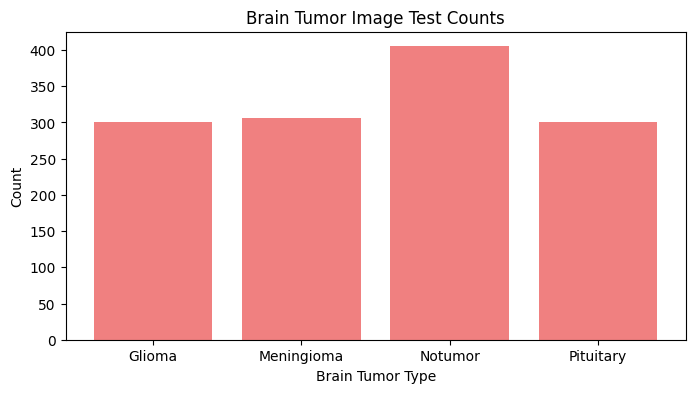

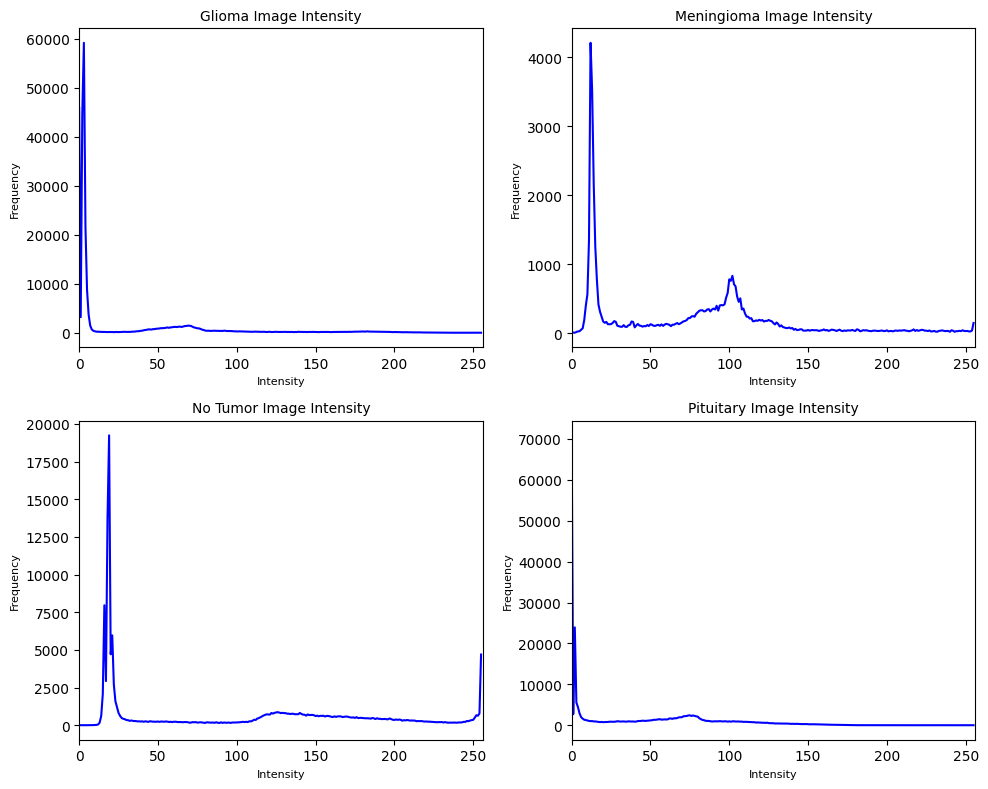

In [9]:
# Image path read function
def read_image_path(return_array_name, path_array):
    for i in path_array:
        folderPath = os.path.join(i)
        for j in os.listdir(folderPath):
            return_array_name.append(os.path.join(folderPath,j))
            
common_mapping_for_path = "/kaggle/input/brain-tumor-mri-dataset/"
# common_mapping_for_path = "/kaggle/input/"
paths_glioma_train = [common_mapping_for_path+"Training/glioma"]
paths_meningioma_train = [common_mapping_for_path+"Training/meningioma"]
paths_notumor_train = [common_mapping_for_path+"Training/notumor"]
paths_pituitarY_train_label = [common_mapping_for_path+"Training/pituitary"]


# read trainingpath similar images to one array 
paths_glioma_images_train = []
read_image_path(paths_glioma_images_train,paths_glioma_train)

paths_meningioma_images_train = []
read_image_path(paths_meningioma_images_train,paths_meningioma_train)

paths_notumor_images_train = []
read_image_path(paths_notumor_images_train,paths_notumor_train)

paths_pituitary_images_train = []
read_image_path(paths_pituitary_images_train,paths_pituitarY_train_label)

count_glioma_images_train = len(paths_glioma_images_train)
count_meningioma_images_train = len(paths_meningioma_images_train)
count_notumor_images_train = len(paths_notumor_images_train)
count_pituitary_images_train = len(paths_pituitary_images_train)

# Create a dictionary to store the data
data = {
    "Type of Brain Tumor": ["Glioma", "Meningioma", "Notumor", "Pituitary"],
    "Image Count": [count_glioma_images_train, count_meningioma_images_train, count_notumor_images_train, count_pituitary_images_train]
}

# Print the data in a tabular format
print("Brain Tumor Image Training Counts:")
table = []
for i in range(len(data["Type of Brain Tumor"])):
    table.append([data['Image Count'][i],data['Type of Brain Tumor'][i]])

headers = ["Image Count", "Type of Brain Tumor"]
print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))   
    

paths_glioma_test = [common_mapping_for_path+"Testing/glioma"]
paths_meningioma_test = [common_mapping_for_path+"Testing/meningioma"]
paths_notumor_test = [common_mapping_for_path+"Testing/notumor"]
paths_pituitarY_test_label = [common_mapping_for_path+"Testing/pituitary"]

# read test path similar images to one array 
paths_glioma_images_test = []
read_image_path(paths_glioma_images_test,paths_glioma_test)

paths_meningioma_images_test = []
read_image_path(paths_meningioma_images_test,paths_meningioma_test)

paths_notumor_images_test = []
read_image_path(paths_notumor_images_test,paths_notumor_test)

paths_pituitary_images_test = []
read_image_path(paths_pituitary_images_test,paths_pituitarY_test_label)


count_glioma_images_test = len(paths_glioma_images_test)
count_meningioma_images_test = len(paths_meningioma_images_test)
count_notumor_images_test = len(paths_notumor_images_test)
count_pituitary_images_test = len(paths_pituitary_images_test)

# Create a dictionary to store the data
data = {
    "Type of Brain Tumor": ["Glioma", "Meningioma", "Notumor", "Pituitary"],
    "Image Count": [count_glioma_images_test, count_meningioma_images_test, count_notumor_images_test, count_pituitary_images_test]
}
    
# Print the data in a tabular format
print("\n Brain Tumor Image Test Counts:")

table = []
for i in range(len(data["Type of Brain Tumor"])):
    table.append([data['Image Count'][i],data['Type of Brain Tumor'][i]])

headers = ["Image Count", "Type of Brain Tumor"]
print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))




# Training data counts
training_data = {"Glioma": count_glioma_images_train, "Meningioma": count_meningioma_images_train, "Notumor": count_notumor_images_train, "Pituitary": count_pituitary_images_train}

# Test data counts
test_data = {"Glioma": count_glioma_images_test, "Meningioma": count_meningioma_images_test, "Notumor": count_notumor_images_test, "Pituitary": count_pituitary_images_test}

# Brain Tumor Image Training Counts
plt.figure(figsize=(8, 4))
plt.bar(training_data.keys(), training_data.values(), color='skyblue')
plt.title("Brain Tumor Image Training Counts")
plt.xlabel("Brain Tumor Type")
plt.ylabel("Count")
plt.show()

# Brain Tumor Image Test Counts
plt.figure(figsize=(8, 4))
plt.bar(test_data.keys(), test_data.values(), color='lightcoral')
plt.title("Brain Tumor Image Test Counts")
plt.xlabel("Brain Tumor Type")
plt.ylabel("Count")
plt.show()

def print_image_intensity(img_path, img_name, ax):
    img = cv2.imread(img_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate the image intensity histogram
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

    # Plot the histogram in the given axis
    ax.plot(hist, color='blue')
    ax.set_title(f"{img_name} Intensity", fontsize=10)
    ax.set_xlabel("Intensity", fontsize=8)
    ax.set_ylabel("Frequency", fontsize=8)
    ax.set_xlim([0, 256])

# Define images to process
test_images = [
    (paths_glioma_images_test[1], "Glioma Image"),
    (paths_meningioma_images_test[1], "Meningioma Image"),
    (paths_notumor_images_test[1], "No Tumor Image"),
    (paths_pituitary_images_test[1], "Pituitary Image"),
]

# Plot all histograms in 2 rows
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # Flatten to iterate easily

for i, (img_path, img_name) in enumerate(test_images):
    try:
        print_image_intensity(img_path, img_name, axes[i])
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

plt.tight_layout()
plt.show()


In [10]:
def print_image_from_array(array_name,image_array_name,label_array_name, image_index ):
    image_array_length = len(image_array_name)
    if(image_array_length>image_index):
        print(f"Total images in the {array_name} array : {image_array_length}, given image index is {image_index}")
        plt.title(f"Image labled as {label_array_name[image_index]}")
        plt.imshow(image_array_name[image_index],interpolation='nearest')
        plt.show()
    else:
        print("Given image index is not inside the given image arrays.")


<a id="7"></a>
# 7. Data set creation *Balance* and *Inbalance* 

  0%|          | 0/1321 [00:00<?, ?it/s]

TensorBoard 2.15.1 at http://0.0.0.0:5006/ (Press CTRL+C to quit)


  0%|          | 0/1339 [00:00<?, ?it/s]

  0%|          | 0/1595 [00:00<?, ?it/s]

  0%|          | 0/1457 [00:00<?, ?it/s]

  0%|          | 0/1321 [00:00<?, ?it/s]

  0%|          | 0/1339 [00:00<?, ?it/s]

  0%|          | 0/1595 [00:00<?, ?it/s]

  0%|          | 0/1457 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Total images in the test data array : 1311, given image index is 1000


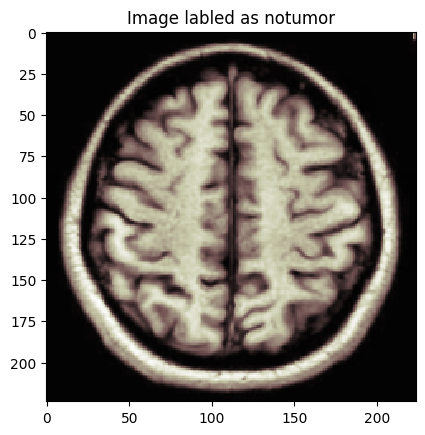

╔═════════════════╦═══════════════╦═══════════════╗
║      Type       ║   Image Count ║   Label Count ║
╠═════════════════╬═══════════════╬═══════════════╣
║  Balance image  ║          5284 ║          5284 ║
║ Inbalance image ║          5712 ║          5712 ║
║   Test image    ║          1311 ║          1311 ║
╚═════════════════╩═══════════════╩═══════════════╝
Total images in the train balance array : 5284, given image index is 1


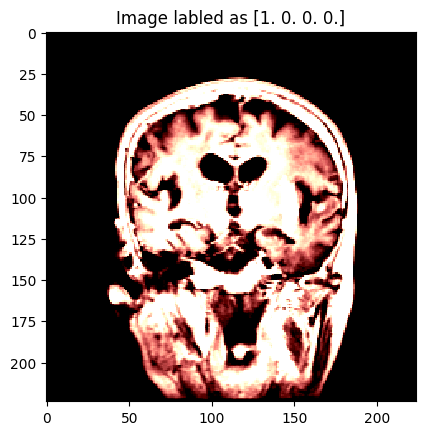

X_train dtype: float32
Y_train_label dtype: float32
x_test dtype: float32
y_test_label dtype: float32


In [ ]:
labels = ['glioma','meningioma','notumor','pituitary']


def read_image(image_size, folderPath):
    read_image_values = []
    for j in tqdm(folderPath):
        # Load image in grayscale
        img = cv2.imread(j, cv2.IMREAD_GRAYSCALE)
        # Apply CLAHE to enhance local contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)
        # Apply bilateral filter to reduce noise
        img = cv2.bilateralFilter(img, d=2, sigmaColor=50, sigmaSpace=50)
        # Convert grayscale to pseudo-colored using COLORMAP_BONE
        img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
        # Resize to desired dimensions
        img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
        # Append processed image
        read_image_values.append(img)
        
    return read_image_values

 
def make_array_with_lable(array, label):
    label_array =[]
    array_length = len(array)
    for i in tqdm(range(array_length)):
        label_array.append(label)
    return label_array    
        
    
read_glioma_image_train = shuffle(read_image(image_size,paths_glioma_images_train),random_state=101)
read_meningioma_image_train = shuffle(read_image(image_size,paths_meningioma_images_train),random_state=101)
read_notumor_image_train = shuffle(read_image(image_size,paths_notumor_images_train),random_state=101)
read_pituitary_image_train = shuffle(read_image(image_size,paths_pituitary_images_train),random_state=101)

read_glioma_label_train = make_array_with_lable(read_glioma_image_train,'glioma')
read_meningioma_label_train = make_array_with_lable(read_meningioma_image_train,'meningioma')
read_notumor_label_train = make_array_with_lable(read_notumor_image_train,'notumor')
read_pituitary_label_train = make_array_with_lable(read_pituitary_image_train,'pituitary')

# image_count = 10
image_count = count_glioma_images_train


# create balance data set 
X_train_inbalance = read_glioma_image_train+read_meningioma_image_train+read_notumor_image_train+read_pituitary_image_train
Y_train_label_inbalance = read_glioma_label_train+read_meningioma_label_train+read_notumor_label_train+read_pituitary_label_train


# create balance data set 
X_train_balance = read_glioma_image_train[:image_count]+read_meningioma_image_train[:image_count]+read_notumor_image_train[:image_count]+read_pituitary_image_train[:image_count]
Y_train_label_balance = read_glioma_label_train[:image_count]+read_meningioma_label_train[:image_count]+read_notumor_label_train[:image_count]+read_pituitary_label_train[:image_count]


read_glioma_image_test = shuffle(read_image(image_size,paths_glioma_images_test),random_state=101)
read_meningioma_image_test = shuffle(read_image(image_size,paths_meningioma_images_test),random_state=101)
read_notumor_image_test = shuffle(read_image(image_size,paths_notumor_images_test),random_state=101)
read_pituitary_image_test = shuffle(read_image(image_size,paths_pituitary_images_test),random_state=101)

read_glioma_label_test = make_array_with_lable(read_glioma_image_test,'glioma')
read_meningioma_label_test = make_array_with_lable(read_meningioma_image_test,'meningioma')
read_notumor_label_test = make_array_with_lable(read_notumor_image_test,'notumor')
read_pituitary_label_test = make_array_with_lable(read_pituitary_image_test,'pituitary')


# create balance data set 
x_test = read_glioma_image_test+read_meningioma_image_test+read_notumor_image_test+read_pituitary_image_test
y_test_label = read_glioma_label_test+read_meningioma_label_test+read_notumor_label_test+read_pituitary_label_test

def print_image_from_array(array_name,image_array_name,label_array_name, image_index ):
    image_array_length = len(image_array_name)
    if(image_array_length>image_index):
        print(f"Total images in the {array_name} array : {image_array_length}, given image index is {image_index}")
        plt.title(f"Image labled as {label_array_name[image_index]}")
        plt.imshow(image_array_name[image_index],interpolation='nearest')
        plt.show()
    else:
        print("Given image index is not inside the given image arrays.")
    
print_image_from_array("test data",x_test,y_test_label,1000)

def z_score_per_image(img_array):
    mean = np.mean(img_array, axis=(1, 2, 3), keepdims=True)
    std = np.std(img_array, axis=(1, 2, 3), keepdims=True)
    return (img_array - mean) / (std + 1e-8)  
# add epsilon to avoid div-by-zero


# Balance data array convert to numpy array
X_train_balance = z_score_per_image(np.array(X_train_balance, dtype=np.float32))
Y_train_label_balance = np.array(Y_train_label_balance)

  # Inbalance data array convert to numpy array
X_train_inbalance = z_score_per_image(np.array(X_train_inbalance, dtype=np.float32))
Y_train_label_inbalance = np.array(Y_train_label_inbalance)

 # Test data array convert to numpy array
x_test = z_score_per_image(np.array(x_test, dtype=np.float32))
y_test_label = np.array(y_test_label)


table = [["Balance image",len(X_train_balance),len(Y_train_label_balance)],["Inbalance image",len(X_train_inbalance),len(Y_train_label_inbalance)],["Test image",len(x_test),len(y_test_label)]]
headers = ["Type","Image Count", "Label Count"]
print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))

def encode_labels(labels_list, labels_mapping, num_classes=4):
    # Convert string labels to indices
    label_indices = [labels_mapping.index(lbl) for lbl in labels_list]
    # Convert to numpy array
    label_indices = np.array(label_indices)
    # One-hot encode
    one_hot_labels = tf.keras.utils.to_categorical(label_indices, num_classes=num_classes)
    # Cast to float16 for memory efficiency
    return one_hot_labels.astype(np.float32)

# Assuming `labels` is your label mapping list
y_test_label = encode_labels(y_test_label, labels, num_classes=4)
Y_train_label_balance = encode_labels(Y_train_label_balance, labels, num_classes=4)
Y_train_label_inbalance = encode_labels(Y_train_label_inbalance, labels, num_classes=4)

print_image_from_array("train balance",X_train_balance,Y_train_label_balance,1)


print("X_train dtype:", X_train_balance.dtype)
print("Y_train_label dtype:", Y_train_label_balance.dtype)
print("x_test dtype:", x_test.dtype)
print("y_test_label dtype:", y_test_label.dtype)


<a id="8"></a>
# 8. Model Training / Data preparation for validation and training 

### Model Data Taken

In [12]:
# model summary 
def model_summary_print(model):
    model.summary()
    
# model layers
def model_layers(model):
    for idx in range(len(model.layers)):
        print(f'Name : {model.get_layer(index=idx).name}, \t \t | Shape :  {model.get_layer(index=idx).input_spec}')
        
# get last layer convalution of the model
def get_last_convalutional_layer(model):
    # Iterate through the layers to find the last convolutional layer
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break
    print("Name of the last convolutional layer:", last_conv_layer_name)
    return last_conv_layer_name

# plot model architecture 
def plot_model_png(model, model_name):
    name = f'plot-{model_name}.png'
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=name)
    
# -----========----------------
# model inside info
def count_params(weights):
    total_params = 0
    for w in weights:
        if isinstance(w, tf.keras.layers.Layer):
            total_params += tf.size(w.trainable_weights).numpy()
        else:
            total_params += tf.size(w).numpy()
    return total_params

def model_inside_info(model,model_name):
#     Get the total number of parameters
    total_params = count_params(model.weights)

#     Get the number of trainable parameters
    trainable_params = count_params(model.trainable_weights)

#     Get the number of non-trainable parameters (optional)
    non_trainable_params = count_params(model.non_trainable_weights)

#     Get the number of layers (manual approach)
    num_layers = len(model.layers)
    
    headers = ["Total Parameters","Trainable Parameters", "Number of Layers"]
    table = ['{:.0f}'.format(total_params),'{:.0f}'.format(trainable_params),'{:.0f}'.format(num_layers)]
    
#     Print non-trainable parameters if needed
    if non_trainable_params > 0:
        headers.append("Non-Trainable Parameters")
        table.append('{:.0f}'.format(non_trainable_params))
    
    print(f"Details about model {model_name}")
    for i, header in enumerate(headers):
        print(f'{header} : {table[i]}')
        
    # Get input shape
    input_shape = model.input_shape

    # Get output shape
    output_shape = model.output_shape

    print(f'Input shape: {input_shape}')
    print(f'Output shape: {output_shape}')
    
        # Get weights as numpy arrays
    weights = model.get_weights()

    for i, weights_layer in enumerate(weights):
        print(f'Layer {i}: {weights_layer.shape}')
        
        # Get model configuration as JSON
    model_config = model.get_config()

    # Print or save the model configuration
#     print(model_config)

# model training or not validation
def model_is_trained_or_not(model):
    # Check if any of the layers have non-random weights
    is_trained = False
    for layer in model.layers:
        if layer.trainable_weights:
            is_trained = True
            break

    if is_trained:
        print("The model is trained.")
    else:
        print("The model is not trained or its layers have random weights.")

### WanDB Management 

In [13]:
"""
Classification Models:
Accuracy / Precision / Recall / F1-Score / Confusion Matrix /  ROC AUC (Area Under the ROC Curve) / Classification Report

Regression Models:
Mean Squared Error (MSE) / Root Mean Squared Error (RMSE) / Mean Absolute Error (MAE) / R-squared /
"""

# Define top-k categorical accuracy function
def top_k_categorical_accuracy(Y_test_label, y_pred, k=5):
    return tf.keras.metrics.top_k_categorical_accuracy(Y_test_label, y_pred, k=k)

METRICS = [
    'accuracy',
    'precision', 
    'recall',
#     'categorical_crossentropy',
#     tf.keras.metrics.LogCoshError(),
#     tf.keras.metrics.Poisson(),
#     'cosine_similarity',
#     'mean_squared_error',
#     'mean_absolute_error',
#     top_k_categorical_accuracy,
#     'mean_absolute_percentage_error',
#     tf.keras.metrics.RootMeanSquaredError()
]



def model_training_validation(model,created_model_name,X_train,Y_train_label,x_test,y_test_label):

    print('taining model inside details ', created_model_name,'\n')
#     model_inside_info(model,created_model_name)
#     model_layers(model)
#     model_summary_print(created_model_name)
    
    print('taining model status', created_model_name,'\n')
    
    print('---------- model compile ------------')
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=METRICS)
#     model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=METRICS)
    
    print('---------- model checkpoint callback ------------')
    filepath = 'propose.{epoch:03d}.keras'
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    
    # Define the ReduceLROnPlateau callback with validation accuracy as the monitoring metric
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

    print('---------- tensorboard callback ------------')
    log_dir = f"logs/{created_model_name}-i-s_{image_size}-e-c_{epochs_count}"  + getNowDateTime()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


    print('---------- wandb callback start after loggin ------------')
    wandb.login(key=secret_value_1) 
#     wandb.tensorboard.patch(root_logdir="./logs/")
    name_wandb = f'{created_model_name}-img-size_{image_size}-{epochs_count}_epochs-{getNowDateTime()}-learning_rate-{learning_rate}-model'
    
   
    wandb_run = wandb.init(entity = 'lalithk90', 
                     project=wandb_project_name, 
                     sync_tensorboard=True, 
                     name=name_wandb)
    
    print('---------- wandb callback start after loggin ------------')
    get_model_inside_and_traing_data(model, name_wandb)
    
    print('---------- model start to fit ------------')
    history=model.fit(X_train, 
                      Y_train_label, 
                      epochs=epochs_count, 
                      batch_size=batch_size, 
                      validation_data= (x_test, y_test_label), 
                      callbacks=[checkpoint,tensorboard_callback,early_stopping,reduce_lr],
                      verbose=0
                     )

   
    name = 'save-'+name_wandb+'.h5'
    model.save(name)
    
    print(f'---------- model saved name:- {name}------------')
    
    artifact = wandb.Artifact(name=name, type="dataset")

    # Add a file to the artifact's contents
    artifact.add_file(local_path="/kaggle/working/"+name)

    # Save the artifact version to W&B and mark it
    # as the output of this wandb_wandb_run
    wandb_run.log_artifact(artifact)
    
    wandb.finish()
    
    print('---------- call model training history visualization ------------')
    model_history_visualization(history)
    
    print('---------- call model validation ------------')
    model_evaluation(model,x_test,y_test_label,name_wandb)
    
    print('---------- call model prediction ------------')
    # prediction(model, name_wandb)
    delete_keras_files(name)

def delete_keras_files(created_model_name):
# Delete all .keras checkpoint files
        keras_files = glob.glob(f'propose_{created_model_name}_*.keras')
        for keras_file in keras_files:
            try:
                os.remove(keras_file)
                print(f'Deleted checkpoint file: {keras_file}')
            except OSError as e:
                print(f'Error deleting {keras_file}: {e}')

<a id="9"></a>
# 9. Model history visulization

In [14]:
def draw_plot(accuracy,validation_accuracy,validation_label,validation_accuracy_label, plot_title ):
    epochs = range(len(accuracy))
    fig = plt.figure(figsize=(8,4))
    plt.title(plot_title)
    plt.xticks(np.arange(0, len(accuracy), 10))
    plt.plot(epochs,accuracy,'r', label=validation_label, marker="o")
    plt.plot(epochs,validation_accuracy,'b', label=validation_accuracy_label, marker="*")
    plt.legend(loc='upper left')
#     plt.savefig('Multiclass Model .png')
    plt.figure()
    plt.show()
    
def model_history_visualization(history):
    accuracy = history.history['accuracy']
    epochs = range(0,len(accuracy))
    
    draw_plot(accuracy, history.history['val_accuracy'], 'accuracy','val_accuracy','Training and Validation Accuracy')
    draw_plot(history.history['loss'], history.history['val_loss'], 'loss','val_loss', 'Training and Validation Loss')
    draw_plot(history.history['precision'], history.history['val_precision'], 'precision','val_precision', 'Training and Validation Precision')
    draw_plot(history.history['recall'],  history.history['val_recall'], 'recall','val_recall','Training and Validation Recall')
    #     draw_plot(history.history['mean_squared_error'], history.history['val_mean_squared_error'], 'mean_squared_error','val_mean_squared_error', 'Training and Validation Mean_squared_error')
#     draw_plot(history.history['mean_absolute_error'], history.history['val_mean_absolute_error'], 'mean_absolute_error','val_mean_absolute_error', 'Training and Validation Mean_absolute_error')
#     draw_plot(history.history['mean_absolute_percentage_error'], history.history['val_mean_absolute_percentage_error'], 'mean_absolute_percentage_error','val_mean_absolute_percentage_error', 'Training and Validation Mean_absolute_percentage_error')
#     draw_plot(history.history['cosine_similarity'], history.history['val_cosine_similarity'], 'cosine_similarity','val_cosine_similarity', 'Training and Validation Cosine_similarity')
#     draw_plot(history.history['categorical_crossentropy'], history.history['val_categorical_crossentropy'], 'categorical_crossentropy','val_categorical_crossentropy','Training and Validation Categorical_crossentropy')
#     draw_plot(history.history['top_k_categorical_accuracy'], history.history['val_top_k_categorical_accuracy'], 'top_k_categorical_accuracy','val_top_k_categorical_accuracy', 'Training and Validation Top_k_categorical_accuracy')
#     draw_plot(history.history['logcosh'], history.history['val_logcosh'], 'log_cosh_error','val_log_cosh_error', 'Training and Validation Log_cosh_error')
#     draw_plot(history.history['poisson'], history.history['val_poisson'], 'poisson','val_poisson', 'Training and Validation Poisson')
#     draw_plot(history.history['root_mean_squared_error'], history.history['val_root_mean_squared_error'], 'root_mean_squared_error','val_root_mean_squared_error', 'Training and Validation Root_mean_squared_error')
    print('---------- end model training history visualization ------------')

<a id="10"></a>
# 10. Model Evaluation

In [15]:
def model_evaluate(model, X_test,Y_test_label,model_name):
#     ------------------------- start ----------------
    score = model.evaluate(X_test,Y_test_label)
    print(f'{model_name}')
    
    headers = ["Test loss","Test accuracy","Test loss(%)","Test accuracy(%)"]
    table = [[score[0],score[1],(score[0]*100),(score[1]*100)]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))
   #     ------------------------- end ---------------- 
   
def visualize_confusion_matrix(cm,model_name):
    #     ------------------------- start ----------------
    # Visualize confusion matrix (optional)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"{model_name}_confusion_matrix.png")  # Save the plot as an image
    plt.show()
    #     ------------------------- end ----------------
    
def model_sensitivity(Y_test_label, cm, y_pred, model_name ):
#     ------------------------- start ----------------
    # Sensitivity = True Positives/ (True Positives + True Negatives)
    # Calculate sensitivity for each class
    classes = np.unique(Y_test_label)
    sensitivities = {}
    for c in classes:
        tp = cm[c, c]
        fn = np.sum(cm[c, :]) - tp
        sensitivities[c] = tp / (tp + fn)

    # Find the modal sensitivity
    modal_sensitivity = max(sensitivities, key=sensitivities.get)

    # Assuming `Y_test_label` are your true labels and `y_pred` are your predicted labels
    res = []
    for l in np.unique(Y_test_label):
        prec, recall, _, _ = precision_recall_fscore_support(Y_test_label == l, y_pred == l, pos_label=True, average=None)
        res.append([l, recall[0]])

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(res, columns=['class', 'sensitivity'])

    # Calculate the average sensitivity
    average_sensitivity = df['sensitivity'].mean()

    print(f"{model_name} Sensitivities")
    
    headers = ["Label","Sensitivities"]
    table = []
    for i in range(len(sensitivities)):
        table.append([labels[i],sensitivities[i]])
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))
    
    headers = ["Modal Sensitivity","Modal Average Sensitivity"]
    table = [[modal_sensitivity,average_sensitivity]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))
    
    #     ------------------------- end ----------------
    
def model_specificity(cm,model_name):
#     ------------------------- start ----------------
    # Specificity = True Negatives/ (False Positives + True Negatives)

    # Calculate specificity for each class
    FP = cm.sum(axis=0) - np.diag(cm) # False positives
    FN = cm.sum(axis=1) - np.diag(cm) # False negatives
    TN = cm.sum() - (FP + FN + np.diag(cm)) # True negatives

    Specificity = TN / (TN + FP)
        
    headers = ["Label", "Specificity"]
    table = []
    # Print specificity for each class
    for i, spec in enumerate(Specificity):
        table.append([labels[i],spec])
        
    print(f"Specificity {model_name}")
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))    
    #     ------------------------- end ----------------
    
def model_roc_auc(Y_test_label,predictions,model_name):
#     ------------------------- start ----------------
    # Calculate ROC AUC score for each class against all other classes
    roc_auc = roc_auc_score(Y_test_label, predictions, multi_class='ovr')
    # Calculate ROC AUC score for each pair of classes
    roc_auc = roc_auc_score(Y_test_label, predictions, multi_class='ovo')

    print(f"ROC AUC Score {model_name} ")
    headers = ["ROC AUC Score (OvR) -> One-vs-Rest","ROC AUC Score (OvO) -> One-vs-One"]
    table = [[roc_auc,roc_auc]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))   
    
    print("\n The area under the ROC curve (AUC) results were considered")
           
    headers = ["Model Status","Result Range"]
    table = [["excellent","AUC values between 0.9 - 1 "],["good"," AUC values between 0.8-0.9 "],["fair" , "AUC values between 0.7-0.8 "],["poor" , "AUC values between 0.6-0.7 "],["failed" , "AUC values between 0.5-0.6"]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))
    
    #     ------------------------- end ----------------

def model_accuracy_score(Y_test_label, y_pred, model_name):
#     ------------------------- start ----------------
    ac_s_without_normalize = accuracy_score(Y_test_label, y_pred)
    ac_s_with_normalize = accuracy_score(Y_test_label, y_pred, normalize=False)
    print(f'Model Accuracy Score {model_name}')
    headers = ["Accuracy score without normalize","Accuracy score with normalize"]
    table = [[ac_s_without_normalize,ac_s_with_normalize]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 
    
    #     ------------------------- end ----------------
    
def model_balanced_accuracy(Y_test_label, y_pred, model_name):
#     ------------------------- start ----------------
    balanced_accuracy_s = balanced_accuracy_score(Y_test_label, y_pred)
    
    print(f'Model Balanced Score {model_name}')
    headers = ["Balanced accuracy score"]
    table = [[balanced_accuracy_s]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 
    #     ------------------------- end ----------------
    
def model_cohen_kappa_score(Y_test_label, y_pred, model_name):
#     ------------------------- start ----------------
    cohen_kappa_score_test = cohen_kappa_score(Y_test_label, y_pred)
    
    print(f'Cohen\'s Kappa Score {model_name}')
    headers = ["Cohen\'s Kappa Score"]
    table = [[cohen_kappa_score_test]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 
    #     ------------------------- end ----------------    
        
def model_matthews_corrcoef(Y_test_label, y_pred, model_name):
#     ------------------------- start ----------------
    matthews_corrcoef_test = matthews_corrcoef(Y_test_label, y_pred)
    
    print(f'matthews_corrcoef Score {model_name}')
    headers = ["matthews_corrcoef Score"]
    table = [[matthews_corrcoef_test]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 
    #     ------------------------- end ----------------   
    
def model_log_loss(Y_test_label, predictions, model_name):
#     ------------------------- start ----------------
    log_loss_test = log_loss(Y_test_label, predictions)
    
    print(f'Model Log loss {model_name}')
    headers = ["Log loss"]
    table = [[log_loss_test]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 
    #     ------------------------- end ----------------  
    
def model_categorical_accuracy(Y_test_label, y_pred, model_name):   
    #------------------------- start ----------------
    m = tf.keras.metrics.categorical_accuracy(Y_test_label, y_pred)
    print(m)
    print(f'Categorical accuracy: {m:.4f}')
    print(f'Categorical accuracy {model_name}')
#     headers = ["Categorical accuracy"]
#     table = [[m]]
#     print(table)
#     print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 
    #------------------------- end ----------------
    
def model_classification_report(Y_test_label, y_pred, model_name):
        print(f"Classification Report : {model_name}")
        classification_report_values = classification_report(Y_test_label, y_pred, output_dict=True,target_names = labels)


def model_precision_score(Y_test_label, y_pred, model_name):
    print(f"{model_name} Precision score \n ===================================================\n")
#     ------------------------- start ----------------
    precision_score_1 = precision_score(Y_test_label, y_pred, average=None)
    
    headers = ["Label", "Precision score"]
    table = []
    # Print specificity for each class
    for i, score in enumerate(precision_score_1):
        table.append([labels[i],score])

    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))

    precision_score_macro = precision_score(Y_test_label, y_pred, average='macro')
    precision_score_micro = precision_score(Y_test_label, y_pred, average='micro')
    precision_score_weighted = precision_score(Y_test_label, y_pred, average='weighted')
    
    headers = ["Precision score macro","Precision score micro","Precision score weighted"]
    table = [[precision_score_macro,precision_score_micro,precision_score_weighted]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 


    data = {'Micro': precision_score_macro, 'Macro': precision_score_micro, 'Weighted': precision_score_weighted}
    values = list(data.keys())
    results = list(data.values())

    fig = plt.figure(figsize=(10, 5))
    # creating the bar plot
    plt.bar(values, results, color='maroon', width=0.4)
    plt.xlabel('Value', fontweight='bold', fontsize=15)
    plt.ylabel('Various scores', fontweight='bold', fontsize=15)
    plt.title(f"{model_name} Various precision scores according to average")
    plt.savefig(f"{model_name}_Precision_score.png")  # Save the plot as an image
    plt.show()
        #     ------------------------- end ----------------
        
def model_recall_score(Y_test_label, y_pred, model_name):
    print(f"{model_name} Recall score \n ===================================================\n")
    #     ------------------------- start ----------------
    recall_score_1 = recall_score(Y_test_label, y_pred, average=None)
    
    headers = ["Label", "Recall score"]
    table = []
    # Print specificity for each class
    for i, score in enumerate(recall_score_1):
        table.append([labels[i],score])

    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))
    
    recall_score_macro = recall_score(Y_test_label, y_pred, average='macro')
    recall_score_micro = recall_score(Y_test_label, y_pred, average='micro')
    recall_score_weighted = recall_score(Y_test_label, y_pred, average='weighted')

    headers = ["Recall score macro","Recall score micro","Recall score weighted"]
    table = [[recall_score_macro,recall_score_micro,recall_score_weighted]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 

    data = {'Micro': recall_score_macro, 'Macro': recall_score_micro, 'Weighted': recall_score_weighted}
    values = list(data.keys())
    results = list(data.values())

    fig = plt.figure(figsize=(10, 5))
    # creating the bar plot
    plt.bar(values, results, color='blue', width=0.4)

    plt.xlabel('Value', fontweight='bold', fontsize=15)
    plt.ylabel('Various scores', fontweight='bold', fontsize=15)
    plt.title(f"{model_name} Various recall scores according to average")
    plt.savefig(f"{model_name}_recall_score.png")  # Save the plot as an image
    plt.show()
    
#     ------------------------- end ----------------
        
def model_f1_score(Y_test_label, y_pred, model_name):
    print(f"{model_name} F1 score \n ===================================================\n")
    #     ------------------------- start ----------------
    f1_score_1 = f1_score(Y_test_label, y_pred, average=None)
    
    headers = ["Label", "F1 score"]
    table = []
    # Print specificity for each class
    for i, score in enumerate(f1_score_1):
        table.append([labels[i],score])

    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))
    
    f1_score_macro = f1_score(Y_test_label, y_pred, average='macro')
    f1_score_micro = f1_score(Y_test_label, y_pred, average='micro')
    f1_score_weighted = f1_score(Y_test_label, y_pred, average='weighted')

    headers = ["F1 score macro","F1 score micro","F1 score weighted"]
    table = [[f1_score_macro,f1_score_micro,f1_score_weighted]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 

    data = {'Micro': f1_score_macro, 'Macro': f1_score_micro,'Weighted': f1_score_weighted}
    values = list(data.keys())
    results = list(data.values())

    fig = plt.figure(figsize=(10, 5))
    # creating the bar plot
    plt.bar(values, results, color='green',width=0.4)
    
    plt.xlabel('Value', fontweight='bold', fontsize=15)
    plt.ylabel('Various scores', fontweight='bold', fontsize=15)
    plt.title(f"{model_name} Various F1 scores according to average")
    plt.savefig(f"{model_name}_f1_score.png")  # Save the plot as an image
    plt.show()
        #     ------------------------- end ----------------

In [16]:
def model_evaluation(model, X_test,Y_test_label,model_name):
    
    print('-----------start to call some validation ------------')
    model_evaluate(model, X_test,Y_test_label,model_name)
    
         # Predict the classes
    predictions = model.predict(X_test)

    y_pred = np.argmax(predictions, axis=1)
    Y_test_label= np.argmax(Y_test_label, axis=1)

    cm = confusion_matrix(Y_test_label, y_pred)
    
    visualize_confusion_matrix(cm, model_name)
    model_sensitivity(Y_test_label, cm, y_pred, model_name)
    model_specificity(cm, model_name)
    model_roc_auc(Y_test_label, predictions, model_name)
    model_accuracy_score(Y_test_label, y_pred, model_name)
    model_balanced_accuracy(Y_test_label, y_pred, model_name)
    model_categorical_accuracy(Y_test_label, y_pred, model_name)
    model_precision_score(Y_test_label, y_pred, model_name)
    model_recall_score(Y_test_label, y_pred, model_name)
    model_f1_score(Y_test_label, y_pred, model_name)
    model_classification_report(Y_test_label, y_pred, model_name)
    model_cohen_kappa_score(Y_test_label, y_pred, model_name)
    model_matthews_corrcoef(Y_test_label, y_pred, model_name)
    model_log_loss(Y_test_label, predictions, model_name)

## Print Current Model Inside Info And Training data 

In [17]:
def create_image_to_test(img_path, image_size):
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Apply CLAHE to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
        # Apply bilateral filter to reduce noise
    img = cv2.bilateralFilter(img, d=2, sigmaColor=50, sigmaSpace=50)
        # Convert grayscale to pseudo-colored using COLORMAP_BONE
    img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
        # Resize to desired dimensions
    img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
    return img

    
def z_score_per_image(img_array):
    mean = np.mean(img_array, axis=(1, 2, 3), keepdims=True)
    std = np.std(img_array, axis=(1, 2, 3), keepdims=True)
    return (img_array - mean) / (std + 1e-8)  # add epsilon to avoid div-by-zero

def prediction(model, model_name):
    print('prediction related to ', model_name)
    x = "/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0005.jpg"
    y = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0016.jpg"
    x = "/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0003.jpg"
    i="/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-noTr_0004.jpg"
    j="/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0014.jpg"
    k="/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0027.jpg"
    l="/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0029.jpg"
    m="/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-gl_0014.jpg"
    n="/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0015.jpg"
    
    image_paths = [x,y,x,i,j,k,l,m,n]
    actual_test_val =['glioma','meningioma','pituitary','notumor','glioma','meningioma','notumor','glioma','pituitary']
    table = []
    # Iterate over the image paths and display each image
    for i, image_path in enumerate(image_paths):
        img_array = create_image_to_test(image_path)
        
        pred_ = model.predict(z_score_per_image(img_array))
        preds = np.squeeze(pred_)
        predict_label = labels[pred_.argmax()]
        actual_label = actual_test_val[i]
        
        table.append([actual_label,predict_label])
        
        title = f'Prediction label : {predict_label} Actual Labeled : {actual_label}\n _________________________________________\n Result related all classes '
        for k in range(len(labels)):
            title = title + f'\n {labels[k]} -----> {preds[k]} '
        img_l = image.load_img(image_path)
        plt.imshow(img_l,interpolation='nearest')
        plt.title(title)
        plt.show() 
        
    headers = ["Actual Test Label","Predict Label"]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center"))       

In [18]:
def get_model_inside_and_traing_data(model, model_name):    
    print(f'--- Trainned model data - {model_name} ---')
    model_is_trained_or_not(model)
    model_layers(model)
    model_inside_info(model, model_name)
    model_summary_print(model)
    plot_model_png(model, model_name)
    
    headers = ["Image size","Learning rate","Wandb project name","Batch size","Epochs count","Num classes"]
    table = [[image_size,learning_rate,wandb_project_name,batch_size,epochs_count,num_classes]]
    print(tabulate(table, headers, tablefmt="double_outline", stralign="center")) 

In [19]:
import warnings
warnings.filterwarnings('ignore')

## Proposed Model

Model Start to train:  propose
taining model inside details  propose_balance_propose 

taining model status propose_balance_propose 

---------- model compile ------------
---------- model checkpoint callback ------------
---------- tensorboard callback ------------
---------- wandb callback start after loggin ------------


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lalithk90. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_082037-g0hmn5md
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lal

---------- wandb callback start after loggin ------------
--- Trainned model data - propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model ---
The model is trained.
Name : input_layer, 	 	 | Shape :  None
Name : conv2d, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : batch_normalization, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 32})
Name : activation, 	 	 | Shape :  None
Name : max_pooling2d, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 32})
Name : batch_normalization_1, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 64})
Name : activation_1, 	 	 | Shape :  None
Name : max_pooling2d_1, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : batch_normalization_2, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 128})
Name : activation_2, 	 	 | Shape :  None
Name : max_pooling2d_2, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_3, 	 	 | Shape 

Model: "propose"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,028,740 (30.63 MB)

 Trainable params: 8,026,756 (30.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


2025-07-01 08:21:04.149422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-01 08:21:04.149494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-01 08:21:04.151620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-01 08:21:13.789829: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100575: 1.87379, expected 1.57926
2025-07-01 08:21:13.790176: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 150528: 3.95832, expected 3.44133
2025-07-01 08:21:13.790198: E external/local_xla/xla/service/gpu/buffer_comparator.cc


Epoch 1: val_accuracy improved from -inf to 0.34096, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.34096 to 0.55454, saving model to propose.002.keras

Epoch 3: val_accuracy improved from 0.55454 to 0.68726, saving model to propose.003.keras

Epoch 4: val_accuracy did not improve from 0.68726

Epoch 5: val_accuracy improved from 0.68726 to 0.73608, saving model to propose.005.keras

Epoch 6: val_accuracy improved from 0.73608 to 0.75515, saving model to propose.006.keras

Epoch 7: val_accuracy did not improve from 0.75515

Epoch 8: val_accuracy improved from 0.75515 to 0.80625, saving model to propose.008.keras

Epoch 9: val_accuracy did not improve from 0.80625

Epoch 10: val_accuracy did not improve from 0.80625

Epoch 11: val_accuracy improved from 0.80625 to 0.85584, saving model to propose.011.keras

Epoch 12: val_accuracy did not improve from 0.85584

Epoch 13: val_accuracy did not improve from 0.85584

Epoch 14: val_accuracy did not improve from 0.855

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇█████████████████████████
wandb:                     train/epoch_learning_rate ██████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                              train/epoch_loss █▅▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▄▅▅▅▆▆▆▆▆▆▆▇▇▇█████████████████████████
wandb:                            train/epoch_recall ▁▃▄▅▅▆▆▆▆▆▆▇▇▇██████████████████████████
wandb:                             train/global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
wandb:                     validation/epoch_accuracy ▁▃▅▆▃▆▇▄▅▅▇▆▆▇▇█████████████████████████
wandb:                         validation/epoch_loss ▆▅▄▃▄▃▃█▄▄▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/ep

---------- call model training history visualization ------------


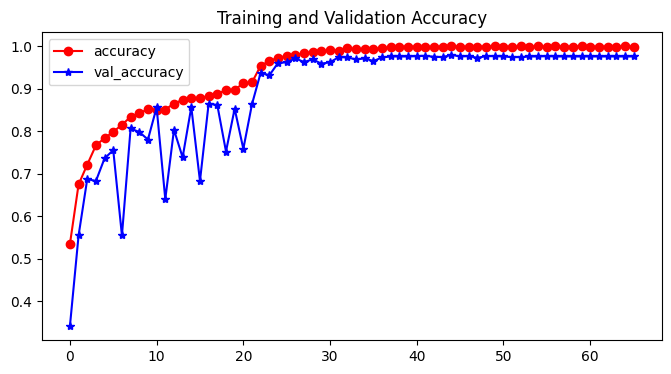

<Figure size 640x480 with 0 Axes>

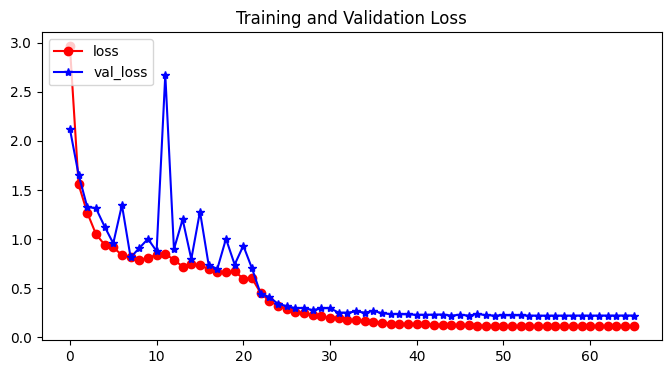

<Figure size 640x480 with 0 Axes>

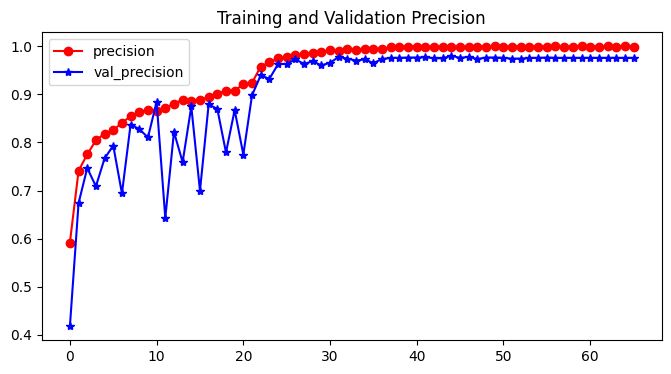

<Figure size 640x480 with 0 Axes>

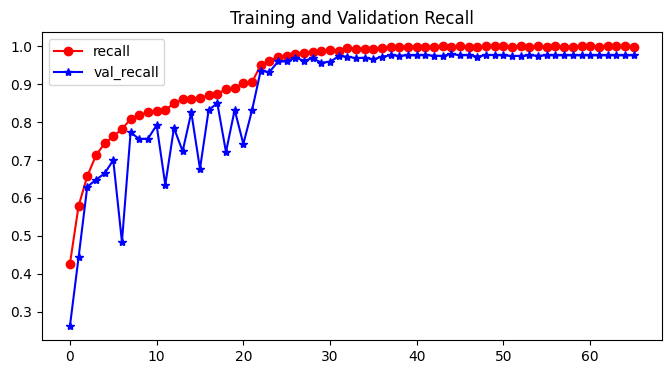

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------


2025-07-01 08:34:11.237992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.38178, expected 1.97036
2025-07-01 08:34:11.238140: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11647: 2.9597, expected 2.54828
2025-07-01 08:34:11.238486: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49971: 3.08701, expected 2.67559
2025-07-01 08:34:11.238521: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50014: 3.10933, expected 2.69791
2025-07-01 08:34:11.238537: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50067: 2.78437, expected 2.37294
2025-07-01 08:34:11.238553: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50069: 3.10014, expected 2.68872
2025-07-01 08:34:11.238569: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50091: 3.11025, expected 2.69882
2025-07-01 08:34:11.238583: E 

37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9595 - loss: 0.2886 - precision: 0.9595 - recall: 0.9587

2025-07-01 08:34:15.809776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.38454, expected 2.74407
2025-07-01 08:34:15.809840: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.58189, expected 3.94142
2025-07-01 08:34:15.809851: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.3348, expected 4.69433
2025-07-01 08:34:15.809862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.1297, expected 4.48923
2025-07-01 08:34:15.809871: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 5.01506, expected 4.37459
2025-07-01 08:34:15.809880: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.06627, expected 3.4258
2025-07-01 08:34:15.809889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.7315, expected 3.09103
2025-07-01 08:34:15.809899: E external/local_xla/xla/ser

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.9615 - loss: 0.2809 - precision: 0.9614 - recall: 0.9606
propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.220386 ║        0.976354 ║        22.0386 ║            97.6354 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


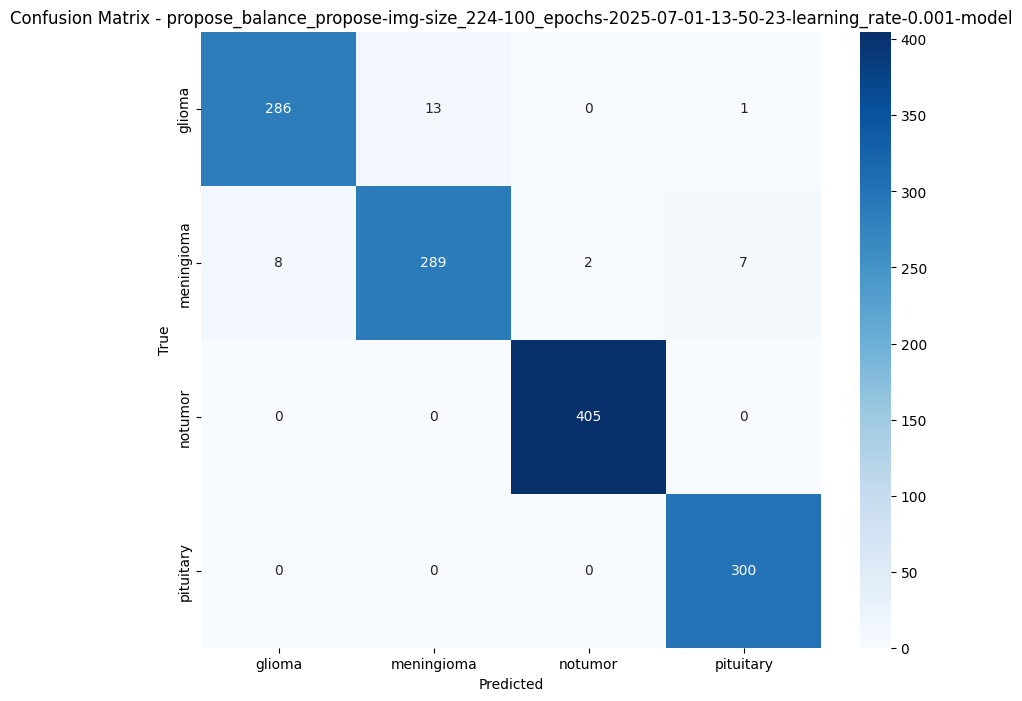

propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.953333 ║
║ meningioma ║        0.944444 ║
║  notumor   ║        1        ║
║ pituitary  ║        1        ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.992258 ║
╚═════════════════════╩═════════════════════════════╝
Specificity propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.992087 ║
║ meningioma ║      0.987065 ║
║  notumor   ║      0.997792 ║
║ pituitary  ║      0.992087 ║
╚════════════╩═══════════════╝
ROC 

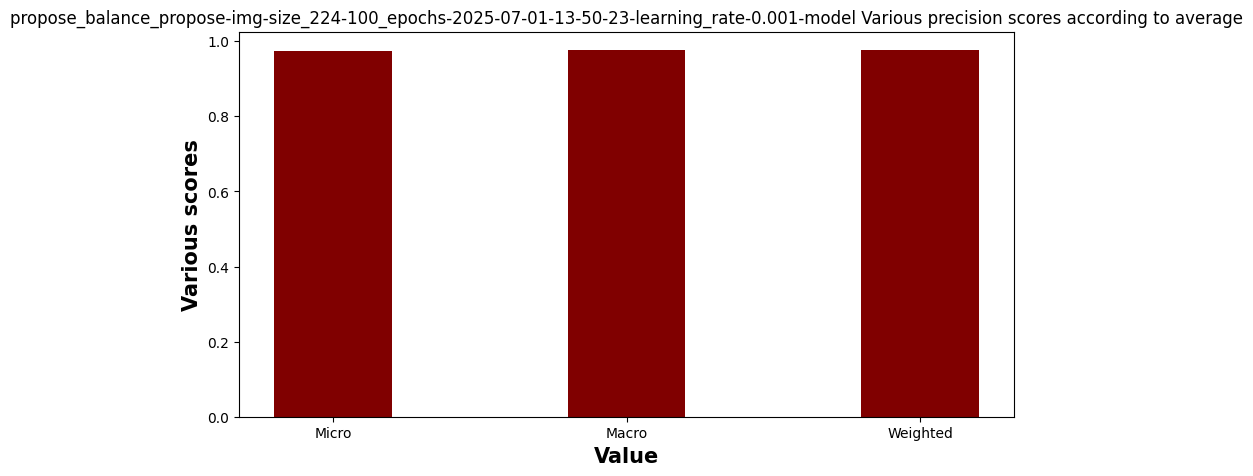

propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.953333 ║
║ meningioma ║       0.944444 ║
║  notumor   ║       1        ║
║ pituitary  ║       1        ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.974444 ║             0.976354 ║                0.976354 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


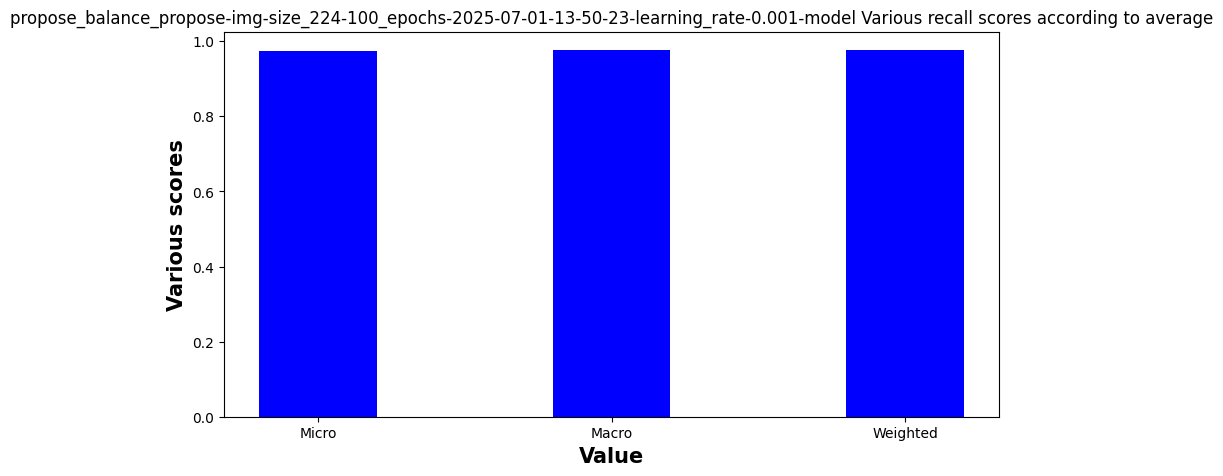

propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.962963 ║
║ meningioma ║   0.950658 ║
║  notumor   ║   0.997537 ║
║ pituitary  ║   0.986842 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║           0.9745 ║         0.976354 ║            0.976236 ║
╚══════════════════╩══════════════════╩═════════════════════╝


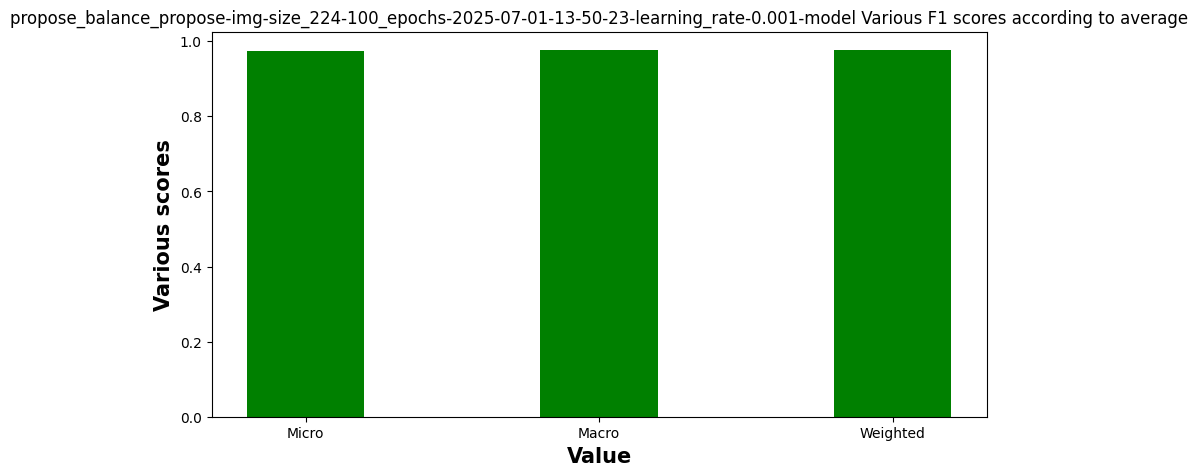

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classification Report : propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model
Cohen's Kappa Score propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.968271 ║
╚═══════════════════════╝
matthews_corrcoef Score propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.968316 ║
╚═══════════════════════════╝
Model Log loss propose_balance_propose-img-size_224-100_epochs-2025-07-01-13-50-23-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.110844 ║
╚════════════╝
---------- call model prediction ------------
taining model inside details  propose_inbalance_propose 

taining model status propose_inbalance_propose 

---------- model compile --------

wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_083424-vnn0jz7y
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/vnn0jz7y


---------- wandb callback start after loggin ------------
--- Trainned model data - propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model ---
The model is trained.
Name : input_layer, 	 	 | Shape :  None
Name : conv2d, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : batch_normalization, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 32})
Name : activation, 	 	 | Shape :  None
Name : max_pooling2d, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 32})
Name : batch_normalization_1, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 64})
Name : activation_1, 	 	 | Shape :  None
Name : max_pooling2d_1, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : batch_normalization_2, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 128})
Name : activation_2, 	 	 | Shape :  None
Name : max_pooling2d_2, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_3, 	 	 | Shap

Model: "propose"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,028,740 (30.63 MB)

 Trainable params: 8,026,756 (30.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
W0000 00:00:1751358904.436116      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
W0000 00:00:1751358917.582094      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.84439, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.84439 to 0.92143, saving model to propose.002.keras

Epoch 3: val_accuracy did not improve from 0.92143

Epoch 4: val_accuracy did not improve from 0.92143

Epoch 5: val_accuracy did not improve from 0.92143

Epoch 6: val_accuracy improved from 0.92143 to 0.93135, saving model to propose.006.keras

Epoch 7: val_accuracy did not improve from 0.93135

Epoch 8: val_accuracy did not improve from 0.93135

Epoch 9: val_accuracy did not improve from 0.93135

Epoch 10: val_accuracy did not improve from 0.93135

Epoch 11: val_accuracy did not improve from 0.93135

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_accuracy improved from 0.93135 to 0.97025, saving model to propose.012.keras

Epoch 13: val_accuracy improved from 0.97025 to 0.97407, saving model to propose.013.keras

Epoch 14: val_accuracy did not improve from 0.97

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
wandb:                          train/epoch_accuracy ▁▂▂▂▃▃▄▃▄▄▅▇▇███████████████████
wandb:                     train/epoch_learning_rate ███████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
wandb:                              train/epoch_loss ████▇▇▇▇▆▇▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▂▂▂▃▃▄▄▄▄▅▇▇███████████████████
wandb:                            train/epoch_recall ▁▂▂▃▃▃▄▄▄▄▅▇████████████████████
wandb:                             train/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:                     validation/epoch_accuracy ▃▆▅▆▆▆▁▄▄▄▃█████████████████████
wandb:                         validation/epoch_loss ▇▅▆▅▅▄█▇▆██▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▃▆▄▆▅▆▁▃▄▃▂█████████████████████
wandb:   

---------- call model training history visualization ------------


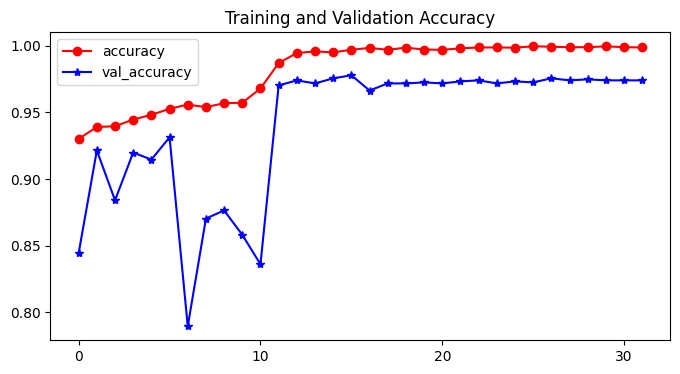

<Figure size 640x480 with 0 Axes>

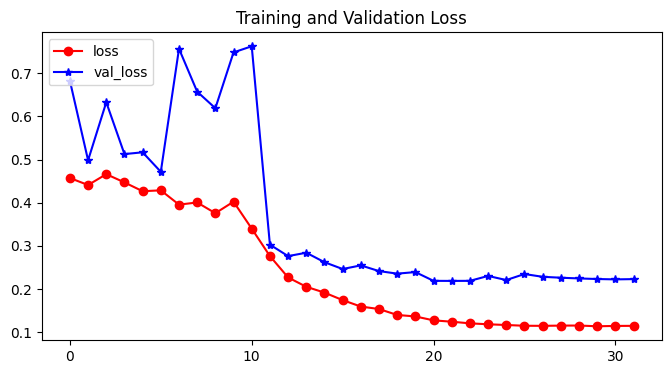

<Figure size 640x480 with 0 Axes>

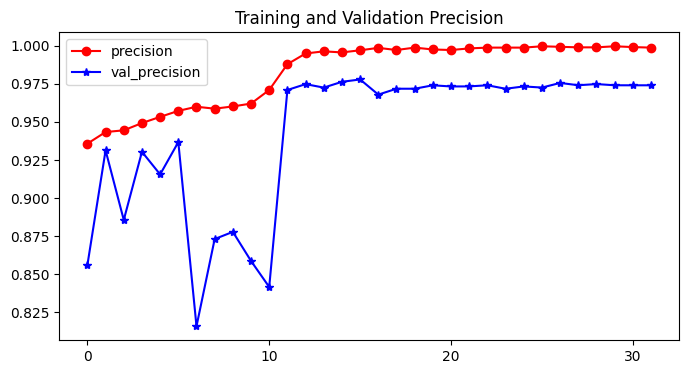

<Figure size 640x480 with 0 Axes>

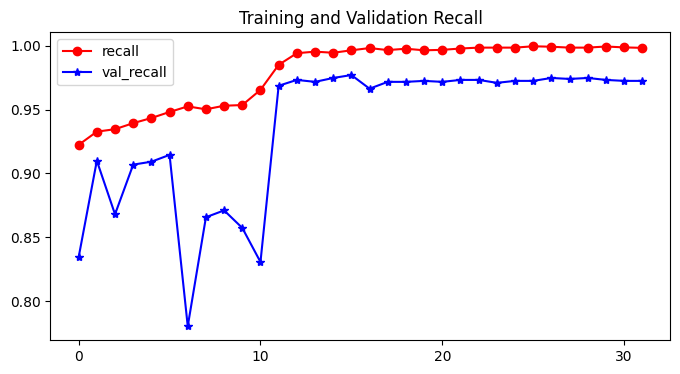

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9567 - loss: 0.2821 - precision: 0.9567 - recall: 0.9567
propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║     0.21887 ║        0.973303 ║         21.887 ║            97.3303 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


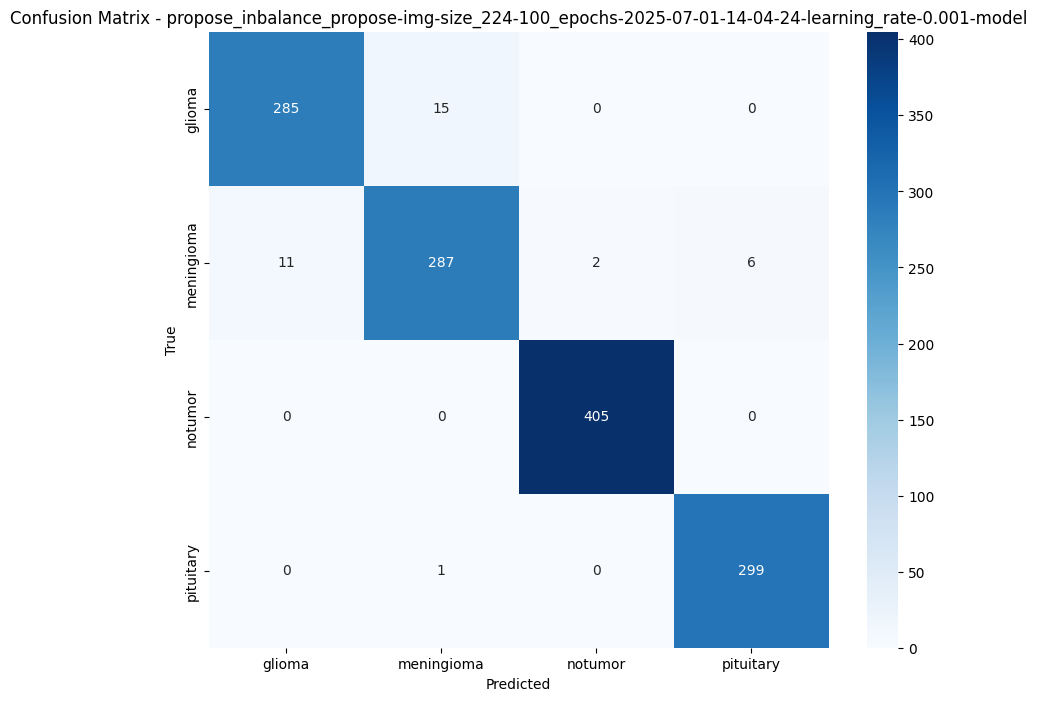

propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.95     ║
║ meningioma ║        0.937908 ║
║  notumor   ║        1        ║
║ pituitary  ║        0.996667 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.991264 ║
╚═════════════════════╩═════════════════════════════╝
Specificity propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.98912  ║
║ meningioma ║      0.98408  ║
║  notumor   ║      0.997792 ║
║ pituitary  ║      0.994065 ║
╚════════════╩═══════════════╝


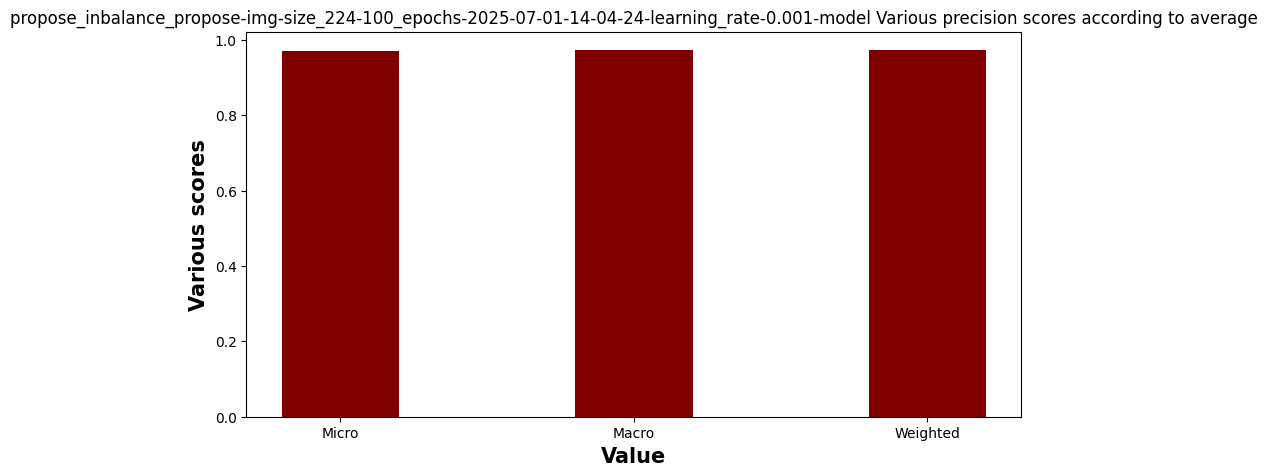

propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.95     ║
║ meningioma ║       0.937908 ║
║  notumor   ║       1        ║
║ pituitary  ║       0.996667 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.971144 ║             0.973303 ║                0.973303 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


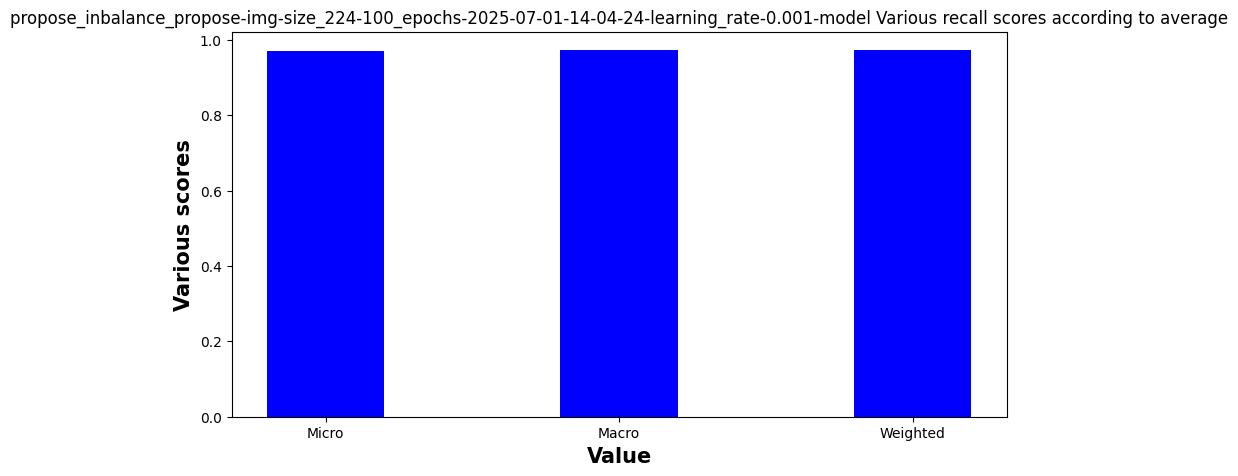

propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.956376 ║
║ meningioma ║   0.942529 ║
║  notumor   ║   0.997537 ║
║ pituitary  ║   0.98843  ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.971218 ║         0.973303 ║            0.973194 ║
╚══════════════════╩══════════════════╩═════════════════════╝


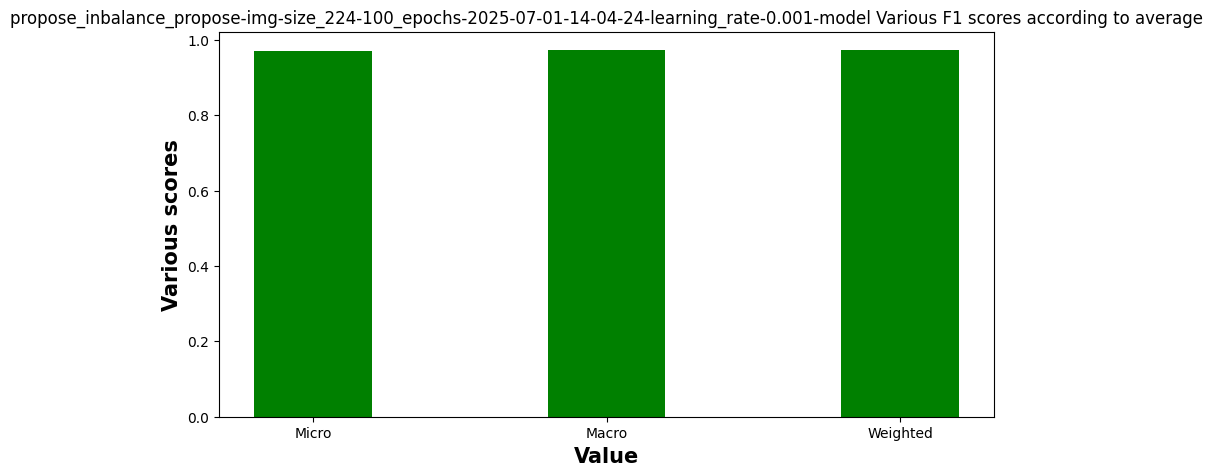

Classification Report : propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model
Cohen's Kappa Score propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.964177 ║
╚═══════════════════════╝
matthews_corrcoef Score propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.964197 ║
╚═══════════════════════════╝
Model Log loss propose_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-04-24-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.103791 ║
╚════════════╝
---------- call model prediction ------------


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation,MaxPooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def propose_model(image_size, num_classes=4):
    inputs = Input(shape=(image_size, image_size, 3))

    # Conv Block 1
    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D()(x)

    # Conv Block 2
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D()(x)

    # Conv Block 3
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D()(x)

    # Conv Block 4
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D()(x)

    # Conv Block 5
    x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = MaxPooling2D()(x)

    # Flatten + Classification Head
    x = Flatten()(x)
    x = Dense(256, activation='swish', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='swish', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs,  name="propose")
    
model = propose_model(image_size)

model_name = model.name
print(f"Model Start to train: ",model_name)
    
balance_model = model_name+"_balance_propose"
model_training_validation(model,balance_model,X_train_balance,Y_train_label_balance,x_test,y_test_label)
   
    
inbalance_model = model_name+"_inbalance_propose"
model_training_validation(model,inbalance_model,X_train_inbalance,Y_train_label_inbalance,x_test,y_test_label)

## 12.1 GoogleLeNet Creation Training And Validation with Balance, Inbalance Data set 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model Start to train:  GoogleLeNet
taining model inside details  GoogleLeNet_balance_propose 

taining model status GoogleLeNet_balance_propose 

---------- model compile ------------
---------- model checkpoint callback ------------
---------- tensorboard callback ------------
---------- wandb callback start after loggin ------------


wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_084143-cx0ya4qu
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/cx0ya4qu


---------- wandb callback start after loggin ------------
--- Trainned model data - GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_1, 	 	 | Shape :  None
Name : conv2d_5, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : max_pooling2d_5, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_7, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2d_9, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : max_pooling2d_6, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_6, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2d_8, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 96})
Name : conv2d_10, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 16})
Name : conv2d_11, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : concatenate, 	 	 | Shape :  None
Name : conv2d_13, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : conv2d_15, 	 	 | Shape :  InputSpe

Model: "GoogleLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │      6,240 │ max_pooling2d_5[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │      1,040 │ max_pooling2d_5[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 56, 56,    │          0 │ max_pooling2d_5[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    110,720 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 56, 56,    │     12,832 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │      2,080 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_8[0][0],   │
│                     │                   │            │ conv2d_10[0][0],  │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 56, 56,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 56, 56,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │    221,376 │ conv2d_13[0][0]   │
│                     │ 192)              │            │                 

 Total params: 6,094,132 (23.25 MB)

 Trainable params: 6,094,132 (23.25 MB)

 Non-trainable params: 0 (0.00 B)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.22883, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.22883 to 0.30892, saving model to propose.002.keras

Epoch 3: val_accuracy did not improve from 0.30892

Epoch 4: val_accuracy did not improve from 0.30892

Epoch 5: val_accuracy improved from 0.30892 to 0.32037, saving model to propose.005.keras

Epoch 6: val_accuracy did not improve from 0.32037

Epoch 7: val_accuracy did not improve from 0.32037

Epoch 8: val_accuracy did not improve from 0.32037

Epoch 9: val_accuracy did not improve from 0.32037

Epoch 10: val_accuracy did not improve from 0.32037

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 11: val_accuracy improved from 0.32037 to 0.41800, saving model to propose.011.keras

Epoch 12: val_accuracy did not improve from 0.41800

Epoch 13: val_accuracy did not improve from 0.41800

Epoch 14: val_accuracy did not improve from 0.41800

Epoch 15: val_accuracy did not imp

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▃▃▃▂▄▄▅▃▃▄█▇▂▂▁▄▇▇▇▇▆
wandb:                     train/epoch_learning_rate ██████████▂▂▂▂▂▂▁▁▁▁▁
wandb:                              train/epoch_loss ▁▁▁▁▁▁▁▁▁▇█▄▃▂▄▂▂▁▁▁▁
wandb:                         train/epoch_precision ▄▅▃█▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▂
wandb:                            train/epoch_recall ▁▁▁▁▁▂▂▂▂▄█▆▂▁▆▂▁▁▁▁▁
wandb:                             train/global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇██
wandb:                     validation/epoch_accuracy ▃▅▃▃▅▅▃▅▃▃█▅▃▃▁▄▄▅▅▅▅
wandb:                         validation/epoch_loss ▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▁▁▁▁█▁▃▃▃▃▅▅▁▁▂▂▂▃▃▂▃
wandb:                       validation/epoch_recall ▁▁▁▁▁▁▅█▆▆▂▁▁▁▁▁▁▁▁▁▁
wandb:  validation/evaluation_acc

---------- call model training history visualization ------------


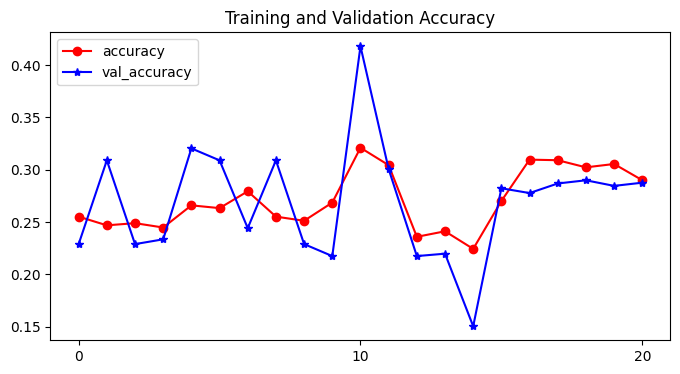

<Figure size 640x480 with 0 Axes>

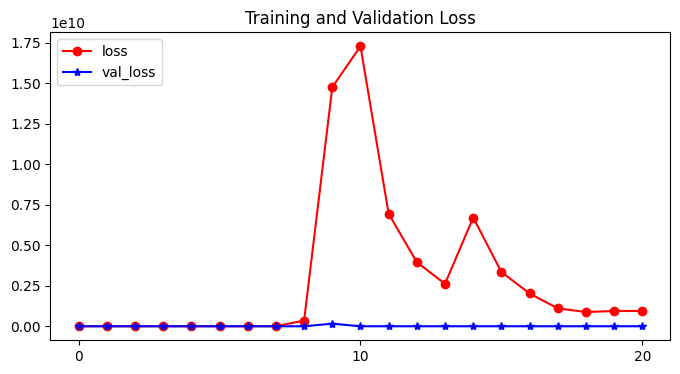

<Figure size 640x480 with 0 Axes>

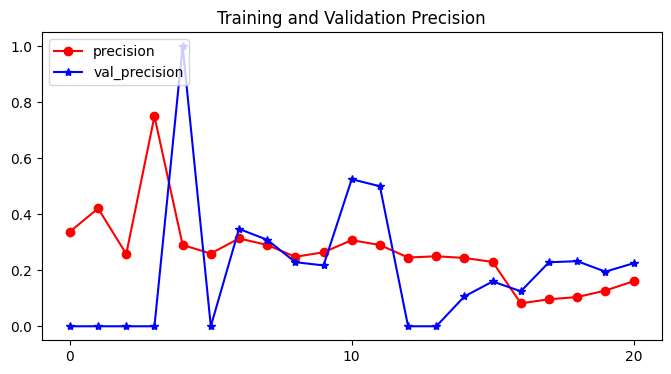

<Figure size 640x480 with 0 Axes>

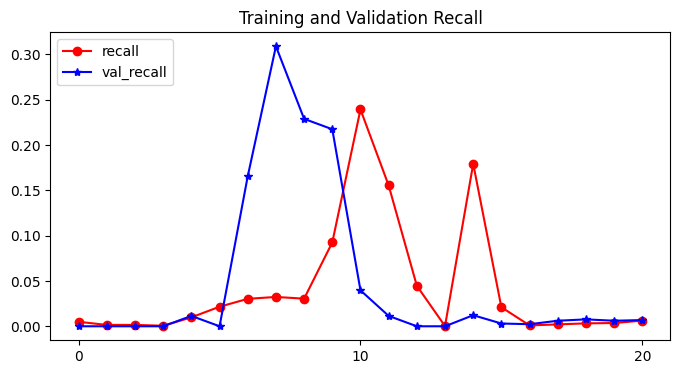

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step - accuracy: 0.3160 - loss: 1.3853 - precision: 0.6089 - recall: 0.0342
GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║     1.27101 ║        0.417239 ║        127.101 ║            41.7239 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


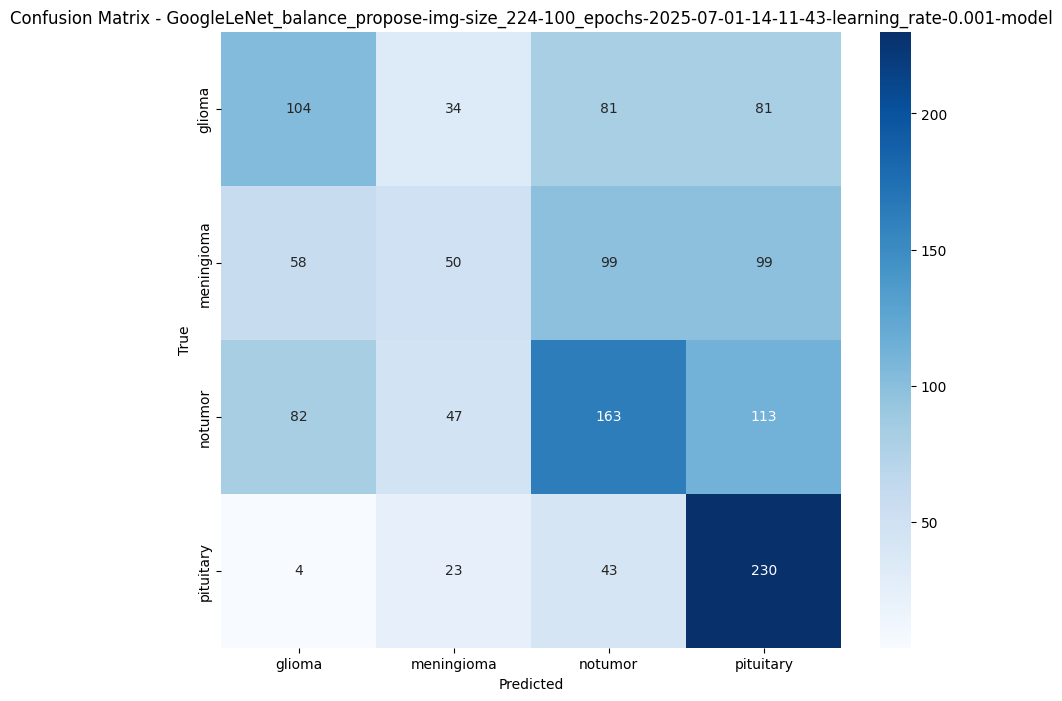

GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.346667 ║
║ meningioma ║        0.163399 ║
║  notumor   ║        0.402469 ║
║ pituitary  ║        0.766667 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   3 ║                    0.804534 ║
╚═════════════════════╩═════════════════════════════╝
Specificity GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.857567 ║
║ meningioma ║      0.896517 ║
║  notumor   ║      0.753863 ║
║ pituitary  ║      0.710188 ║
╚════════════╩═════════════

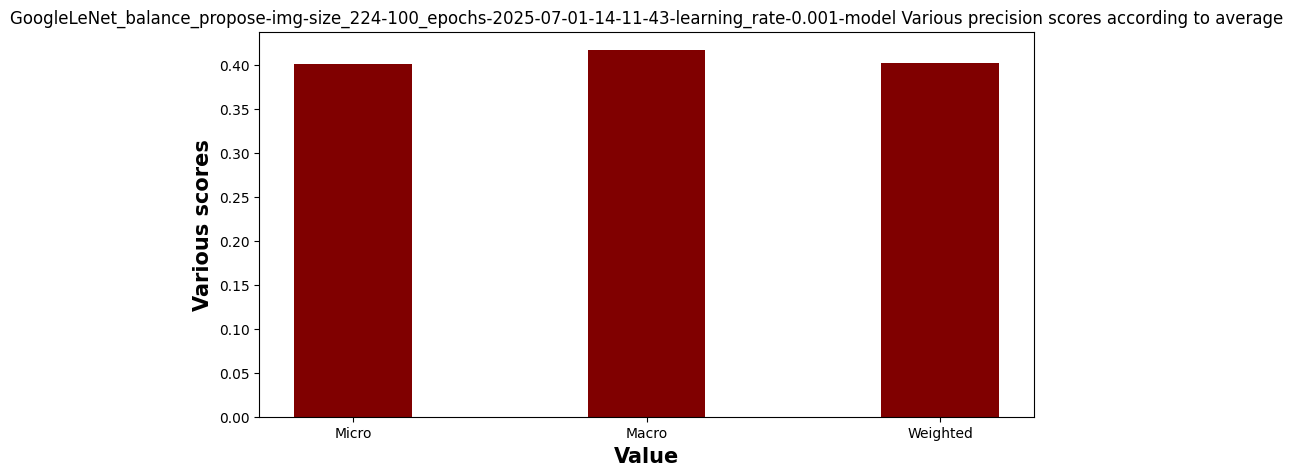

GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.346667 ║
║ meningioma ║       0.163399 ║
║  notumor   ║       0.402469 ║
║ pituitary  ║       0.766667 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║               0.4198 ║             0.417239 ║                0.417239 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


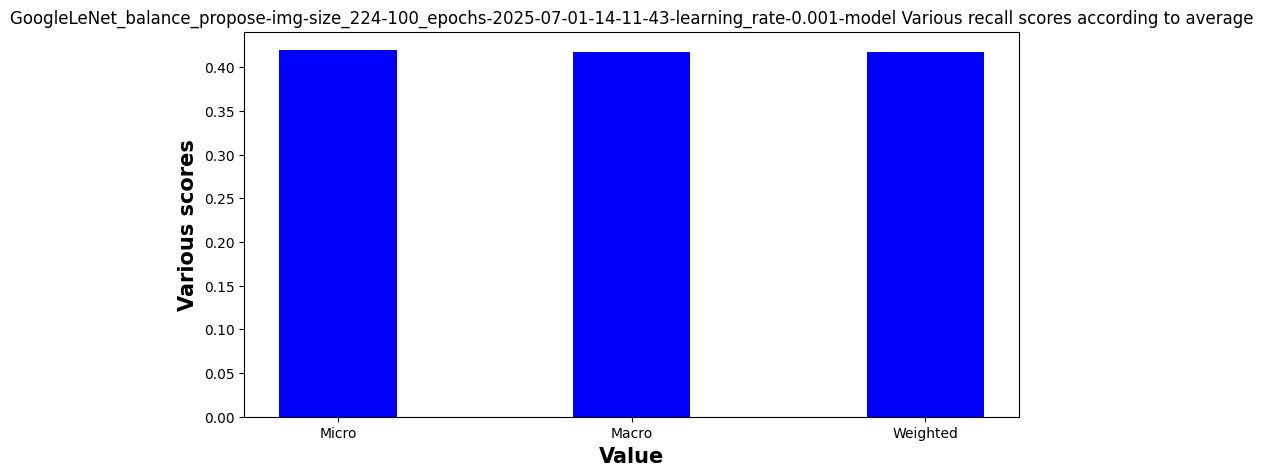

GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.379562 ║
║ meningioma ║   0.217391 ║
║  notumor   ║   0.412137 ║
║ pituitary  ║   0.558931 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.392005 ║         0.417239 ║            0.392818 ║
╚══════════════════╩══════════════════╩═════════════════════╝


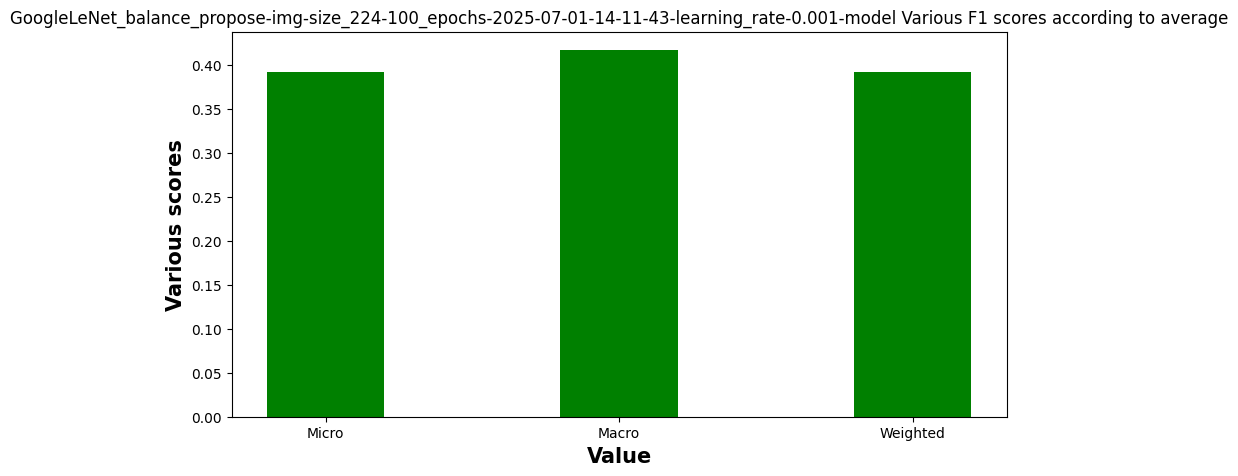

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classification Report : GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model
Cohen's Kappa Score GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.219915 ║
╚═══════════════════════╝
matthews_corrcoef Score GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.226702 ║
╚═══════════════════════════╝
Model Log loss GoogleLeNet_balance_propose-img-size_224-100_epochs-2025-07-01-14-11-43-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║    1.27101 ║
╚════════════╝
---------- call model prediction ------------
taining model inside details  GoogleLeNet_inbalance_propose 

taining model status GoogleLeNet_inbalance_propose 

---------

wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_085612-ng8yaiw2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/ng8yaiw2


---------- wandb callback start after loggin ------------
--- Trainned model data - GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_1, 	 	 | Shape :  None
Name : conv2d_5, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : max_pooling2d_5, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_7, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2d_9, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : max_pooling2d_6, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2d_6, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2d_8, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 96})
Name : conv2d_10, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 16})
Name : conv2d_11, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : concatenate, 	 	 | Shape :  None
Name : conv2d_13, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : conv2d_15, 	 	 | Shape :  InputS

Model: "GoogleLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │      6,240 │ max_pooling2d_5[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │      1,040 │ max_pooling2d_5[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 56, 56,    │          0 │ max_pooling2d_5[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    110,720 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 56, 56,    │     12,832 │ conv2d_9[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │      2,080 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_8[0][0],   │
│                     │                   │            │ conv2d_10[0][0],  │
│                     │                   │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 56, 56,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 56, 56,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 56, 56,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │    221,376 │ conv2d_13[0][0]   │
│                     │ 192)              │            │                 

 Total params: 6,094,132 (23.25 MB)

 Trainable params: 6,094,132 (23.25 MB)

 Non-trainable params: 0 (0.00 B)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.57361, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.57361 to 0.62395, saving model to propose.002.keras

Epoch 3: val_accuracy improved from 0.62395 to 0.68192, saving model to propose.003.keras

Epoch 4: val_accuracy did not improve from 0.68192

Epoch 5: val_accuracy did not improve from 0.68192

Epoch 6: val_accuracy did not improve from 0.68192

Epoch 7: val_accuracy did not improve from 0.68192

Epoch 8: val_accuracy did not improve from 0.68192

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 9: val_accuracy did not improve from 0.68192

Epoch 10: val_accuracy did not improve from 0.68192

Epoch 11: val_accuracy did not improve from 0.68192

Epoch 12: val_accuracy did not improve from 0.68192

Epoch 13: val_accuracy did not improve from 0.68192

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 13: early stopping
Restoring model weights 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
wandb:                          train/epoch_accuracy ▃▆██▁▁▁▁▁▁▁▁▁
wandb:                     train/epoch_learning_rate ████████▁▁▁▁▁
wandb:                              train/epoch_loss █▁▁▂▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▆▇██▄▁▁▁▁▁▁▁▁
wandb:                            train/epoch_recall ▂▅██▁▁▁▁▁▁▁▁▁
wandb:                             train/global_step ▁▁▂▂▃▃▄▅▅▆▆▇▇▇█
wandb:                     validation/epoch_accuracy ▆▇█▃▁▁▁▁▁▁▁▁▁
wandb:                         validation/epoch_loss ▂▂▁█▄▄▄▄▄▄▄▄▄
wandb:                    validation/epoch_precision ▇▇█▅▁▁▁▁▁▁▁▁▁
wandb:                       validation/epoch_recall ▅▇█▆▁▁▁▁▁▁▁▁▁
wandb:  validation/evaluation_accuracy_vs_iterations ▆▇█▃▁▁▁▁▁▁▁▁▁
wandb:      validation/evaluation_loss_vs_iterations ▂▂▁█▄▄▄▄▄▄▄▄▄

---------- call model training history visualization ------------


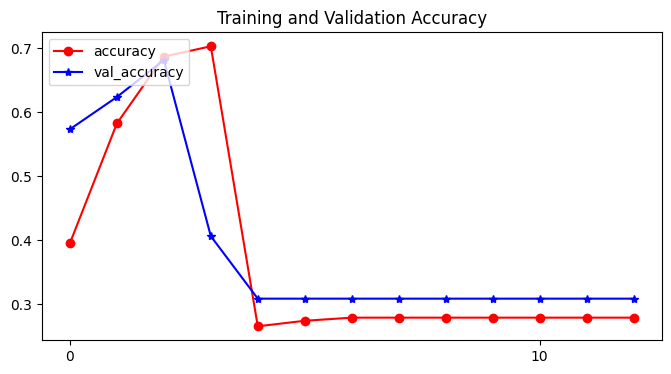

<Figure size 640x480 with 0 Axes>

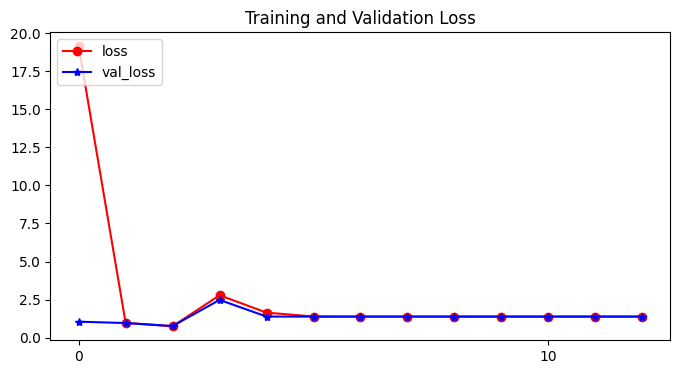

<Figure size 640x480 with 0 Axes>

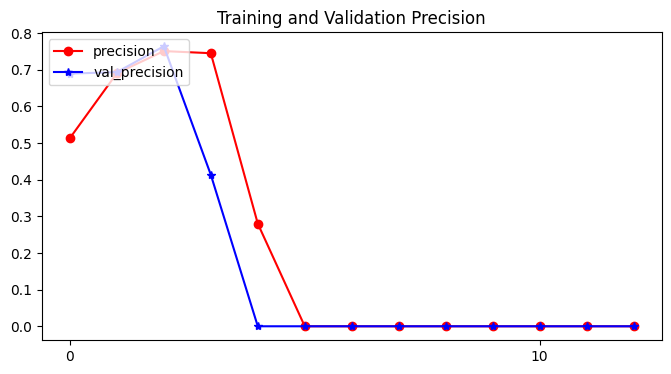

<Figure size 640x480 with 0 Axes>

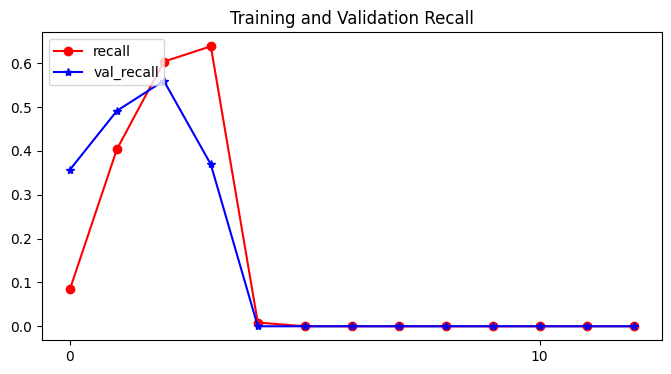

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.5589 - loss: 1.0224 - precision: 0.6004 - recall: 0.3726
GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.767033 ║        0.679634 ║        76.7033 ║            67.9634 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step


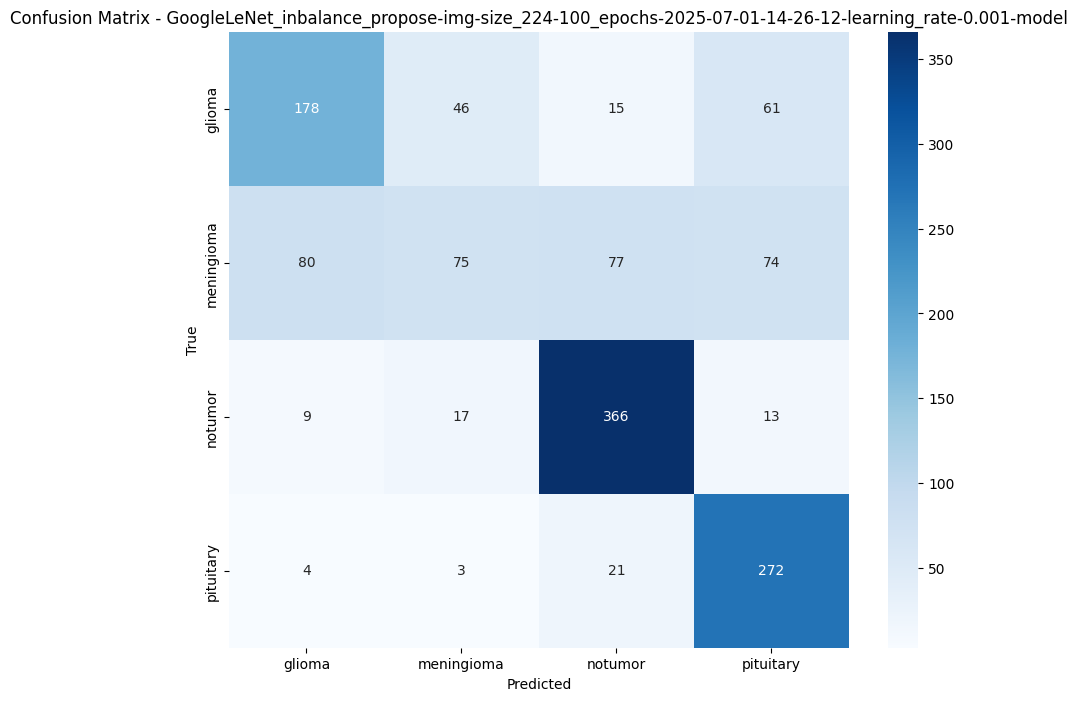

GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.593333 ║
║ meningioma ║        0.245098 ║
║  notumor   ║        0.903704 ║
║ pituitary  ║        0.906667 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   3 ║                    0.892807 ║
╚═════════════════════╩═════════════════════════════╝
Specificity GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.908012 ║
║ meningioma ║      0.934328 ║
║  notumor   ║      0.875276 ║
║ pituitary  ║      0.85361  ║
╚════════════╩═════════

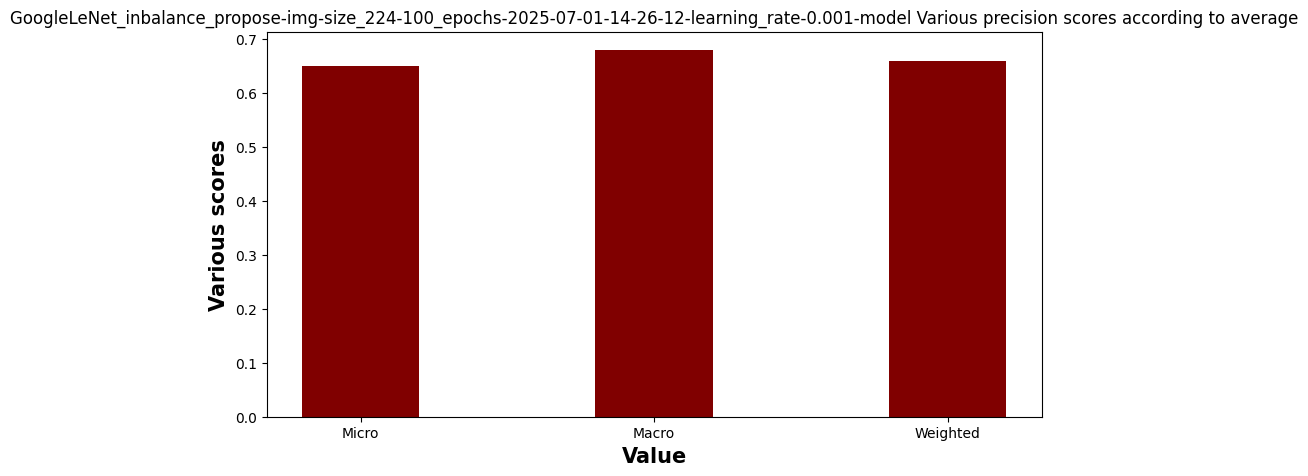

GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.593333 ║
║ meningioma ║       0.245098 ║
║  notumor   ║       0.903704 ║
║ pituitary  ║       0.906667 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║               0.6622 ║             0.679634 ║                0.679634 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


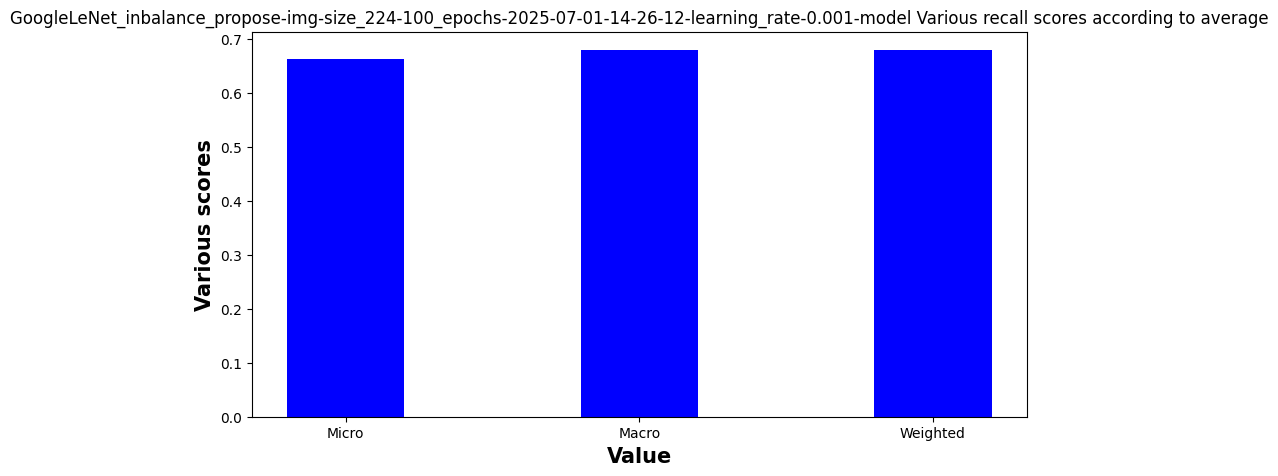

GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.623468 ║
║ meningioma ║   0.33557  ║
║  notumor   ║   0.828054 ║
║ pituitary  ║   0.755556 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.635662 ║         0.679634 ║            0.649698 ║
╚══════════════════╩══════════════════╩═════════════════════╝


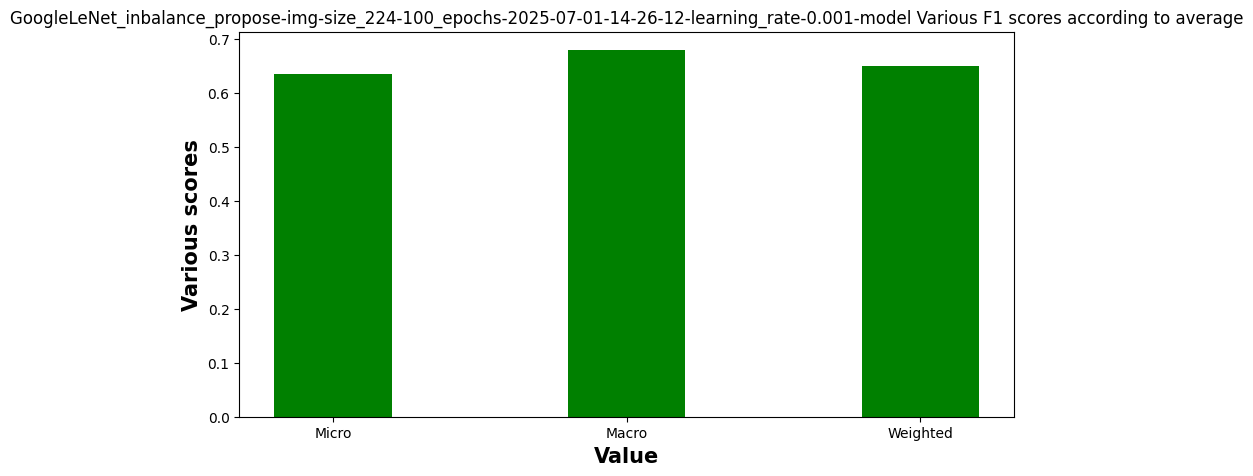

Classification Report : GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model
Cohen's Kappa Score GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.567897 ║
╚═══════════════════════╝
matthews_corrcoef Score GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                   0.57896 ║
╚═══════════════════════════╝
Model Log loss GoogleLeNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-26-12-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.767033 ║
╚════════════╝
---------- call model prediction ------------


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

def inception_module(x, filters):
#     """Creates an Inception module."""
    branch1x1 = layers.Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

    branch3x3 = layers.Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch3x3 = layers.Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = layers.Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch5x5 = layers.Conv2D(filters=filters[4], kernel_size=(5, 5), padding='same', activation='relu')(branch5x5)

    branch_pool = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = layers.Conv2D(filters=filters[5], kernel_size=(1, 1), padding='same', activation='relu')(branch_pool)

    return layers.concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)

def GoogleLeNet(input_shape=(image_size, image_size, 3), num_classes=num_classes):
#     """Creates GoogleLeNet model."""
    input_layer = layers.Input(shape=input_shape)

    # Initial Convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # First Inception module
    x = inception_module(x, filters=[64, 96, 128, 16, 32, 32])
    x = inception_module(x, filters=[128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Second Inception module
    x = inception_module(x, filters=[192, 96, 208, 16, 48, 64])
    x = inception_module(x, filters=[160, 112, 224, 24, 64, 64])
    x = inception_module(x, filters=[128, 128, 256, 24, 64, 64])
    x = inception_module(x, filters=[112, 144, 288, 32, 64, 64])
    x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Third Inception module
    x = inception_module(x, filters=[256, 160, 320, 32, 128, 128])
    x = inception_module(x, filters=[384, 192, 384, 48, 128, 128])
    x = layers.AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x, name="GoogleLeNet")
    return model

# Create an instance of the GoogleLeNet model
model= GoogleLeNet()

model_name = model.name
print(f"Model Start to train: ",model_name)
    
balance_model = model_name+"_balance_propose"
model_training_validation(model,balance_model,X_train_balance,Y_train_label_balance,x_test,y_test_label)
   
    
inbalance_model = model_name+"_inbalance_propose"
model_training_validation(model,inbalance_model,X_train_inbalance,Y_train_label_inbalance,x_test,y_test_label)

## 12.2 VGG19 Model Creation Training And Validation with Balance, Inbalance Data set

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model Start to train:  vgg19
taining model inside details  vgg19_balance_propose 

taining model status vgg19_balance_propose 

---------- model compile ------------
---------- model checkpoint callback ------------
---------- tensorboard callback ------------
---------- wandb callback start after loggin ------------


wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_090526-diqdu1h9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/diqdu1h9


---------- wandb callback start after loggin ------------
--- Trainned model data - vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_2, 	 	 | Shape :  None
Name : block1_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : block1_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block1_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block2_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block2_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block2_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block3_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block3_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_conv3, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_conv4, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : bl

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             

 Total params: 45,719,620 (174.41 MB)

 Trainable params: 25,695,236 (98.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
2025-07-01 09:05:55.223492: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2025-07-01 09:05:55.223564: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2025-07-01 09:05:55.223574: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2025-07-01 09:05:55.223582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2025-07-01 09:05:55.223591: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2025-07-01 09:05:55.223599: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2025-07-01 09:05:55.223607: E external/local_xla/xla/s


Epoch 1: val_accuracy improved from -inf to 0.84821, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.84821 to 0.89626, saving model to propose.002.keras

Epoch 3: val_accuracy improved from 0.89626 to 0.91457, saving model to propose.003.keras

Epoch 4: val_accuracy improved from 0.91457 to 0.92830, saving model to propose.004.keras

Epoch 5: val_accuracy did not improve from 0.92830

Epoch 6: val_accuracy did not improve from 0.92830

Epoch 7: val_accuracy did not improve from 0.92830

Epoch 8: val_accuracy improved from 0.92830 to 0.93593, saving model to propose.008.keras

Epoch 9: val_accuracy did not improve from 0.93593

Epoch 10: val_accuracy did not improve from 0.93593

Epoch 11: val_accuracy improved from 0.93593 to 0.95347, saving model to propose.011.keras

Epoch 12: val_accuracy did not improve from 0.95347

Epoch 13: val_accuracy did not improve from 0.95347

Epoch 14: val_accuracy did not improve from 0.95347

Epoch 15: val_accuracy did not impr

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▁▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇██████████████
wandb:                     train/epoch_learning_rate ████████████████▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
wandb:                              train/epoch_loss █▂▂▂▂▂▂▂▂▂▂▃▂▂▂▃▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▂
wandb:                         train/epoch_precision ▁▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████████████████
wandb:                            train/epoch_recall ▁▄▅▅▅▅▅▅▆▆▅▅▅▆▆▅▆▇▇▇▇████████████
wandb:                             train/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
wandb:                     validation/epoch_accuracy ▁▄▅▆▅▅▅▇▆▆█▇▆▇▇▆▇████████████████
wandb:                         validation/epoch_loss █▅▄▃▃▃▅▂▃▄▂▂▃▂▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▁▃▅▆▅▅▄▇▆▅▇▇▆▇▇▇█████████████████
w

---------- call model training history visualization ------------


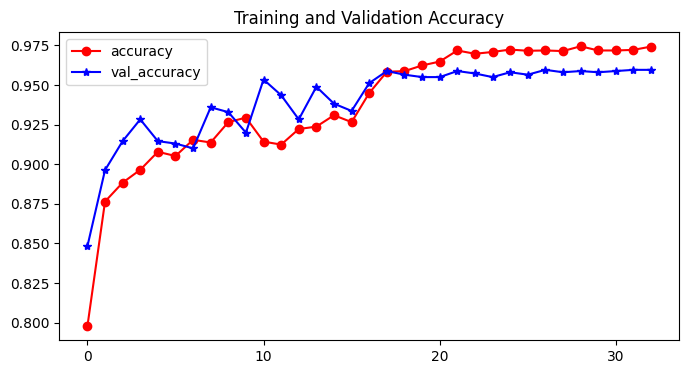

<Figure size 640x480 with 0 Axes>

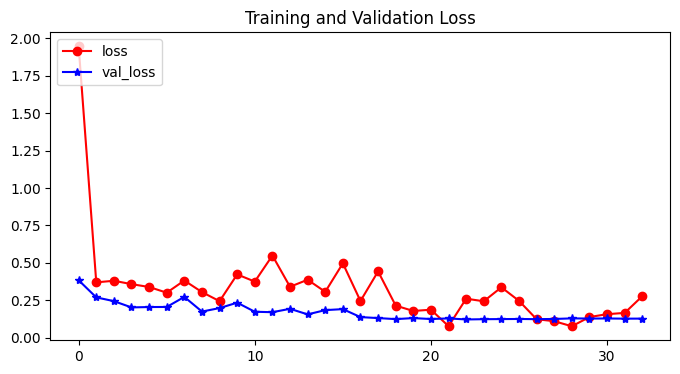

<Figure size 640x480 with 0 Axes>

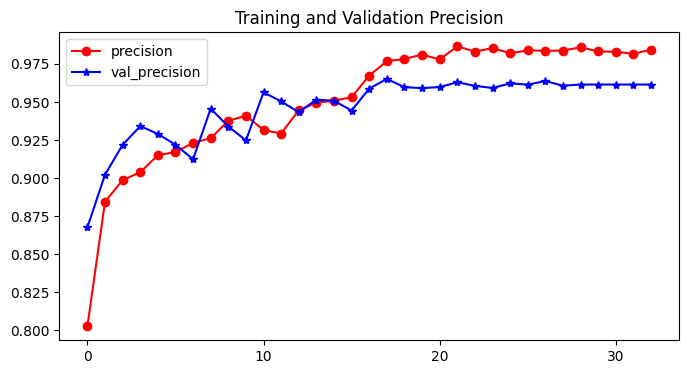

<Figure size 640x480 with 0 Axes>

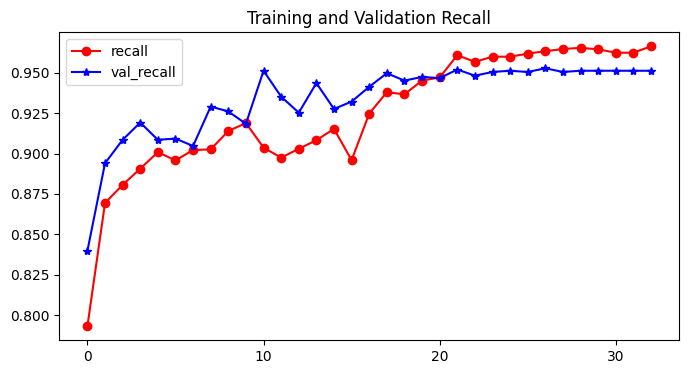

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------


2025-07-01 09:21:35.362084: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2025-07-01 09:21:35.362140: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2025-07-01 09:21:35.362150: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2025-07-01 09:21:35.362158: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2025-07-01 09:21:35.362166: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2025-07-01 09:21:35.362174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2025-07-01 09:21:35.362182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2025-07-01 09:21:35.362190: E external/local_xla/xla/se

40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9348 - loss: 0.1862 - precision: 0.9384 - recall: 0.9144

2025-07-01 09:21:55.250405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.62212, expected 2.70127
2025-07-01 09:21:55.250462: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100353: 5.31563, expected 4.39477
2025-07-01 09:21:55.250472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100354: 5.43093, expected 4.51007
2025-07-01 09:21:55.250481: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100355: 5.35723, expected 4.43638
2025-07-01 09:21:55.250494: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100356: 5.06878, expected 4.14793
2025-07-01 09:21:55.250502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100357: 5.791, expected 4.87014
2025-07-01 09:21:55.250510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100358: 5.23388, expected 4.31303
2025-07-01 09:21:55.25

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 436ms/step - accuracy: 0.9359 - loss: 0.1831 - precision: 0.9395 - recall: 0.9160
vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.121629 ║        0.957285 ║        12.1629 ║            95.7285 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step


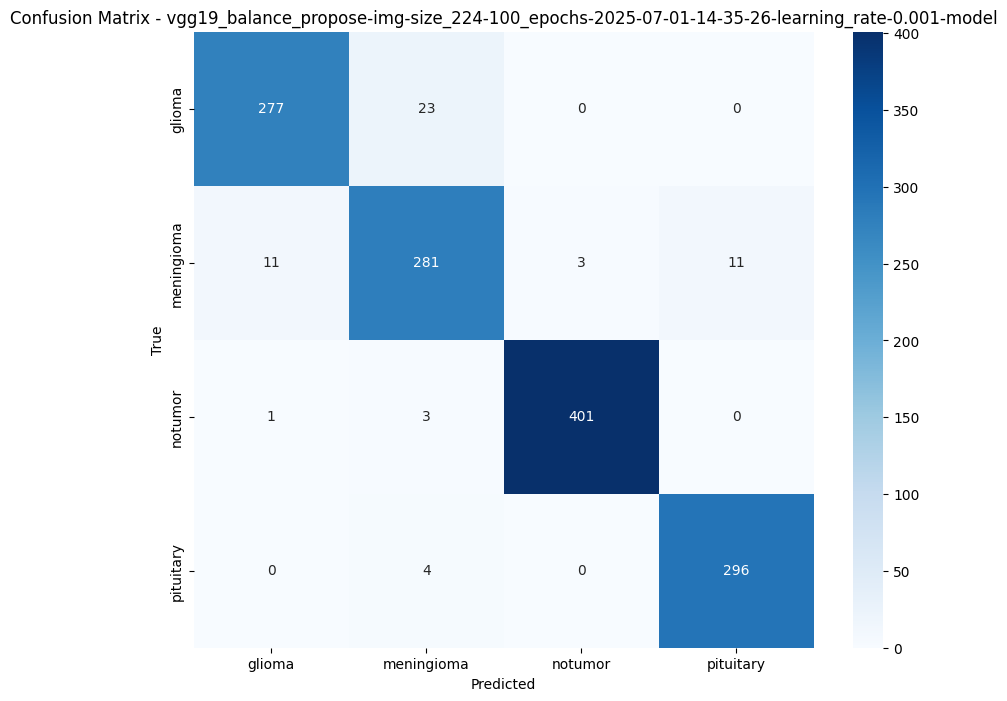

vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.923333 ║
║ meningioma ║        0.918301 ║
║  notumor   ║        0.990123 ║
║ pituitary  ║        0.986667 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.986022 ║
╚═════════════════════╩═════════════════════════════╝
Specificity vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.988131 ║
║ meningioma ║      0.970149 ║
║  notumor   ║      0.996689 ║
║ pituitary  ║      0.98912  ║
╚════════════╩═══════════════╝
ROC AUC 

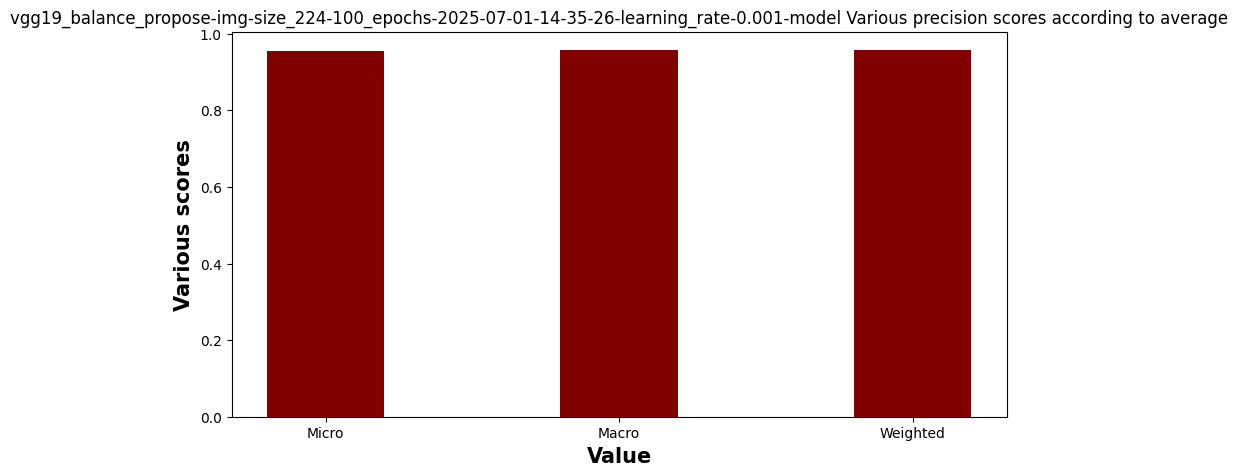

vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.923333 ║
║ meningioma ║       0.918301 ║
║  notumor   ║       0.990123 ║
║ pituitary  ║       0.986667 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.954606 ║             0.957285 ║                0.957285 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


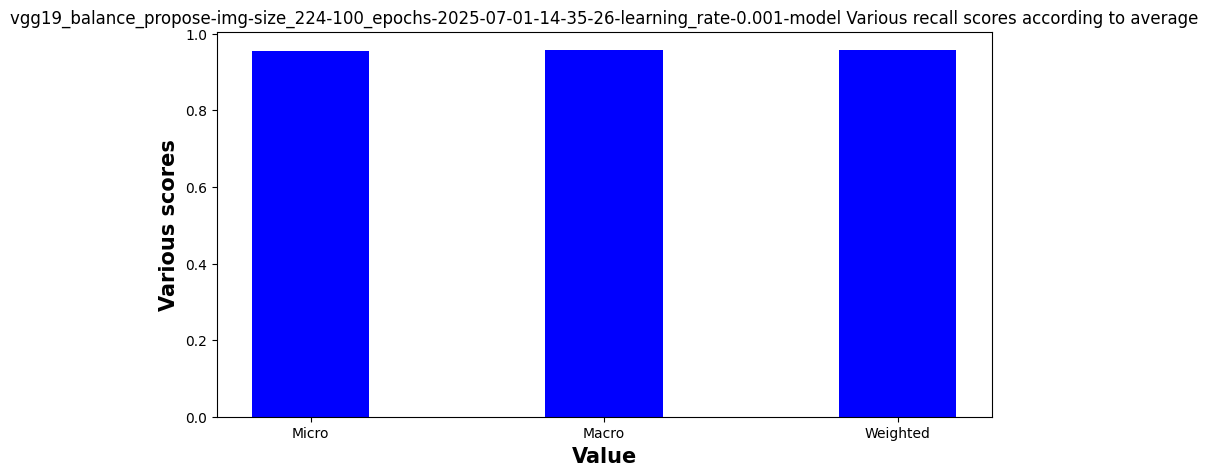

vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.940577 ║
║ meningioma ║   0.910859 ║
║  notumor   ║   0.991347 ║
║ pituitary  ║   0.975288 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.954518 ║         0.957285 ║            0.957268 ║
╚══════════════════╩══════════════════╩═════════════════════╝


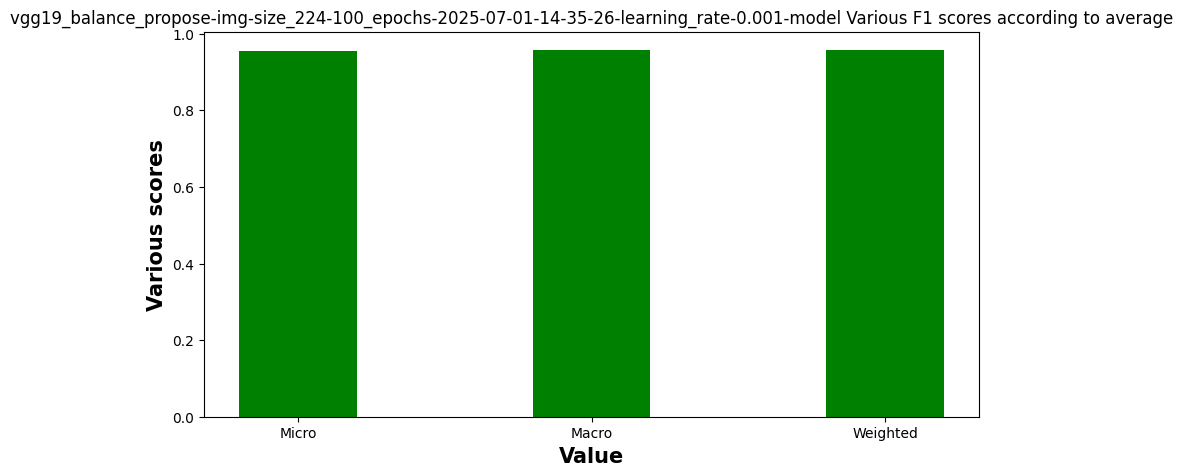

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classification Report : vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model
Cohen's Kappa Score vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.942695 ║
╚═══════════════════════╝
matthews_corrcoef Score vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.942767 ║
╚═══════════════════════════╝
Model Log loss vgg19_balance_propose-img-size_224-100_epochs-2025-07-01-14-35-26-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.121629 ║
╚════════════╝
---------- call model prediction ------------
taining model inside details  vgg19_inbalance_propose 

taining model status vgg19_inbalance_propose 

---------- model compile ------------
-------

wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_092216-e1pw4i74
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/e1pw4i74


---------- wandb callback start after loggin ------------
--- Trainned model data - vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_2, 	 	 | Shape :  None
Name : block1_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : block1_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block1_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block2_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block2_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block2_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block3_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block3_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_conv3, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_conv4, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : 

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             

 Total params: 45,719,620 (174.41 MB)

 Trainable params: 25,695,236 (98.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.93898, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.93898 to 0.95881, saving model to propose.002.keras

Epoch 3: val_accuracy did not improve from 0.95881

Epoch 4: val_accuracy did not improve from 0.95881

Epoch 5: val_accuracy did not improve from 0.95881

Epoch 6: val_accuracy improved from 0.95881 to 0.95957, saving model to propose.006.keras

Epoch 7: val_accuracy improved from 0.95957 to 0.96186, saving model to propose.007.keras

Epoch 8: val_accuracy improved from 0.96186 to 0.96644, saving model to propose.008.keras

Epoch 9: val_accuracy did not improve from 0.96644

Epoch 10: val_accuracy improved from 0.96644 to 0.96873, saving model to propose.010.keras

Epoch 11: val_accuracy did not improve from 0.96873

Epoch 12: val_accuracy did not improve from 0.96873

Epoch 13: val_accuracy did not improve from 0.96873

Epoch 14: val_accuracy did not improve from 0.96873

Epoch 15: val_accuracy did not impr

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▁▂▁▃▄▄▄▄▆▆▄▆▆▅▅▇▇█
wandb:                     train/epoch_learning_rate ███████████████▁▁▁
wandb:                              train/epoch_loss █▇█▆▄▅▅▅▃▃▅▄▃▄▄▂▂▁
wandb:                         train/epoch_precision ▁▁▁▃▄▄▄▄▆▆▄▅▅▆▆▇██
wandb:                            train/epoch_recall ▂▁▁▃▄▄▄▄▆▆▄▅▆▆▅▇▇█
wandb:                             train/global_step ▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇███
wandb:                     validation/epoch_accuracy ▁▅▄▅▂▆▆▇▆█▆▅▆▄▇▇▇█
wandb:                         validation/epoch_loss █▄▆▃█▂▂▁▂▃▂▅▄▆▃▃▄▃
wandb:                    validation/epoch_precision ▁▅▄▆▂▇▆█▇▇▆▆▆▄▇▇▇█
wandb:                       validation/epoch_recall ▁▄▄▆▂▅▆▆▆▇▆▅▆▄▇▇▇█
wandb:  validation/evaluation_accuracy_vs_iterations ▁▅▄▅▂▆▆▇▆█▆▅▆▄▇▇▇█

---------- call model training history visualization ------------


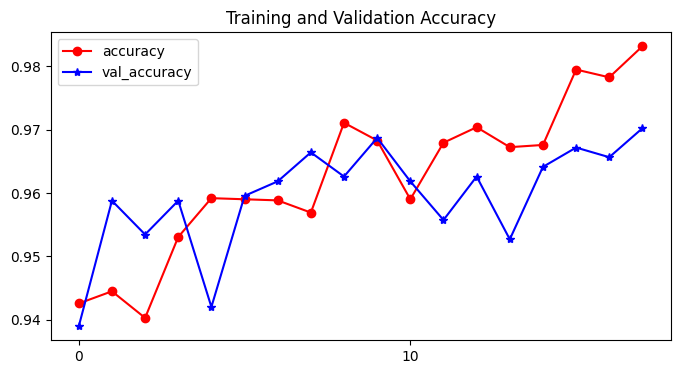

<Figure size 640x480 with 0 Axes>

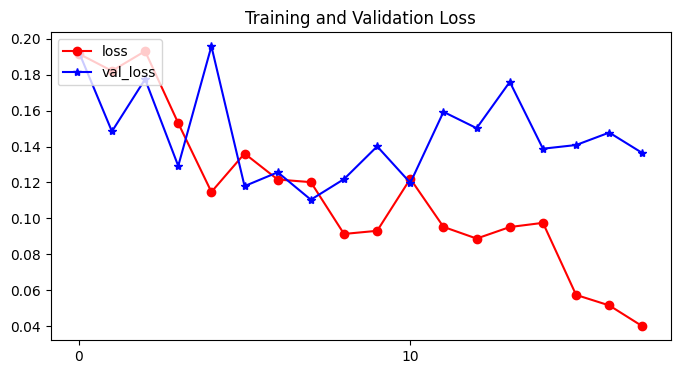

<Figure size 640x480 with 0 Axes>

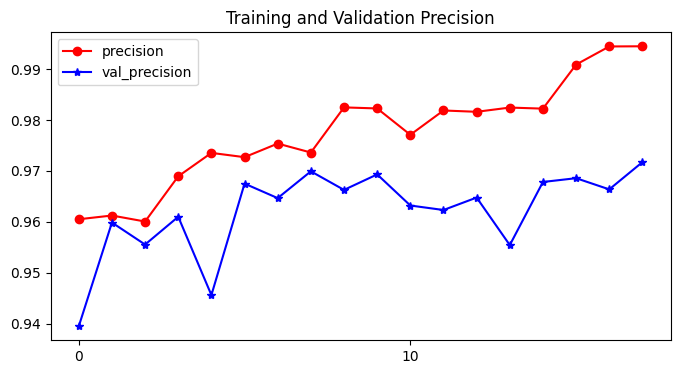

<Figure size 640x480 with 0 Axes>

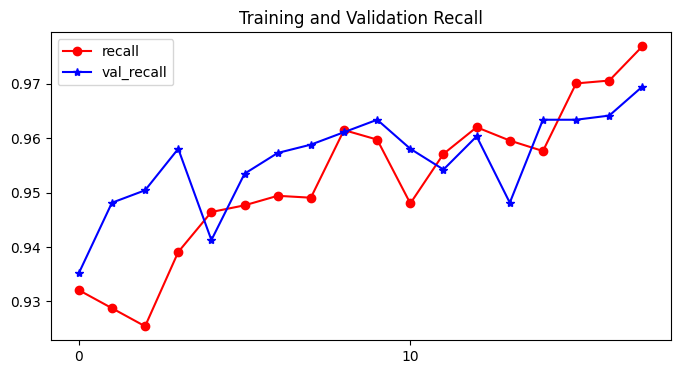

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9490 - loss: 0.1775 - precision: 0.9510 - recall: 0.9356
vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.110418 ║        0.966438 ║        11.0418 ║            96.6438 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step


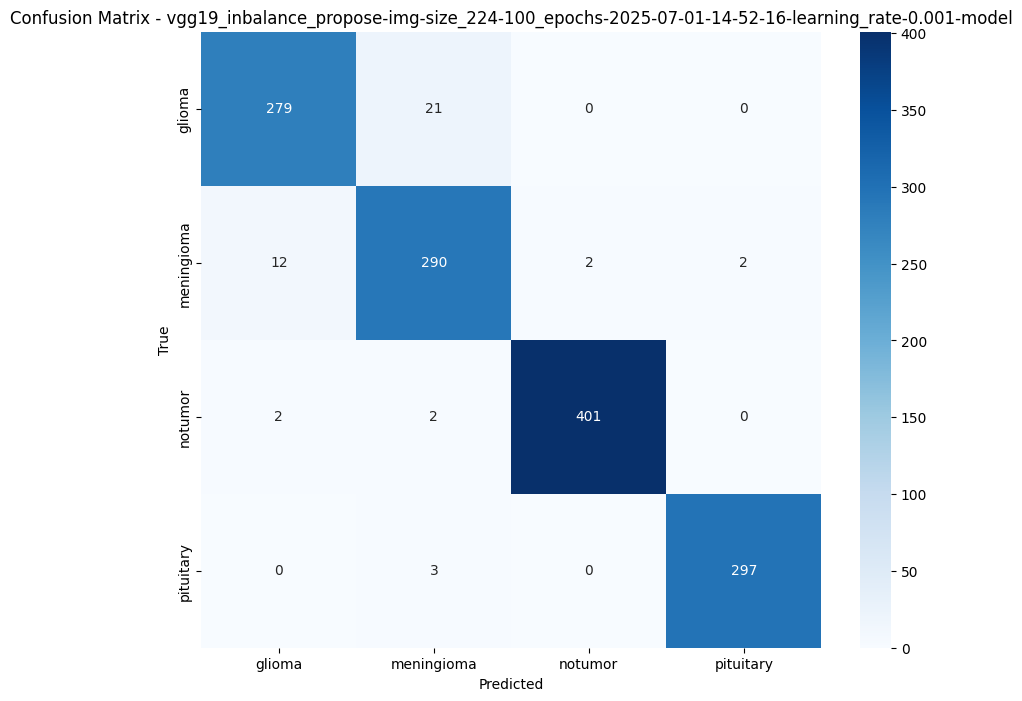

vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.93     ║
║ meningioma ║        0.947712 ║
║  notumor   ║        0.990123 ║
║ pituitary  ║        0.99     ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.989024 ║
╚═════════════════════╩═════════════════════════════╝
Specificity vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.986152 ║
║ meningioma ║      0.974129 ║
║  notumor   ║      0.997792 ║
║ pituitary  ║      0.998022 ║
╚════════════╩═══════════════╝
ROC 

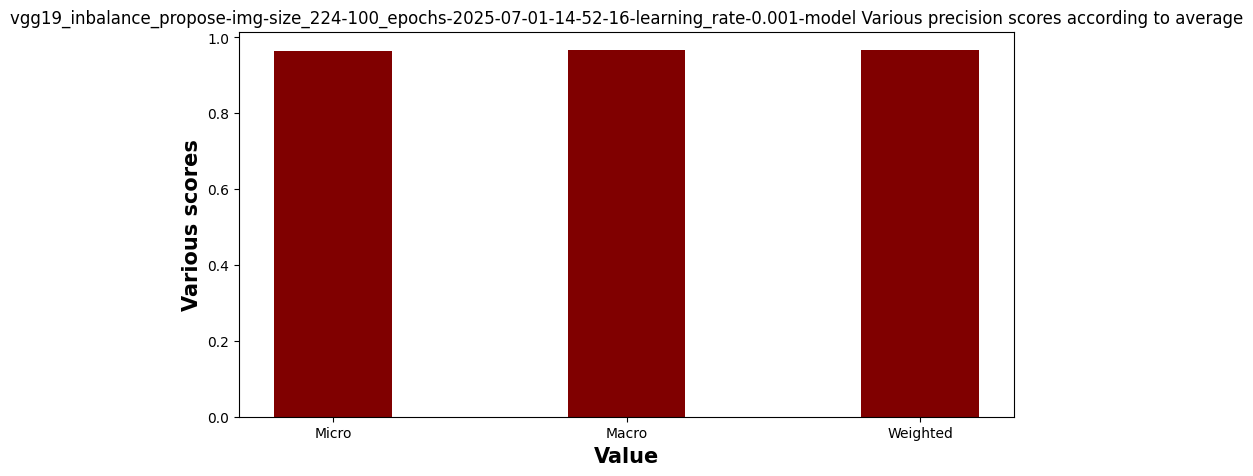

vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.93     ║
║ meningioma ║       0.947712 ║
║  notumor   ║       0.990123 ║
║ pituitary  ║       0.99     ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.964459 ║             0.966438 ║                0.966438 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


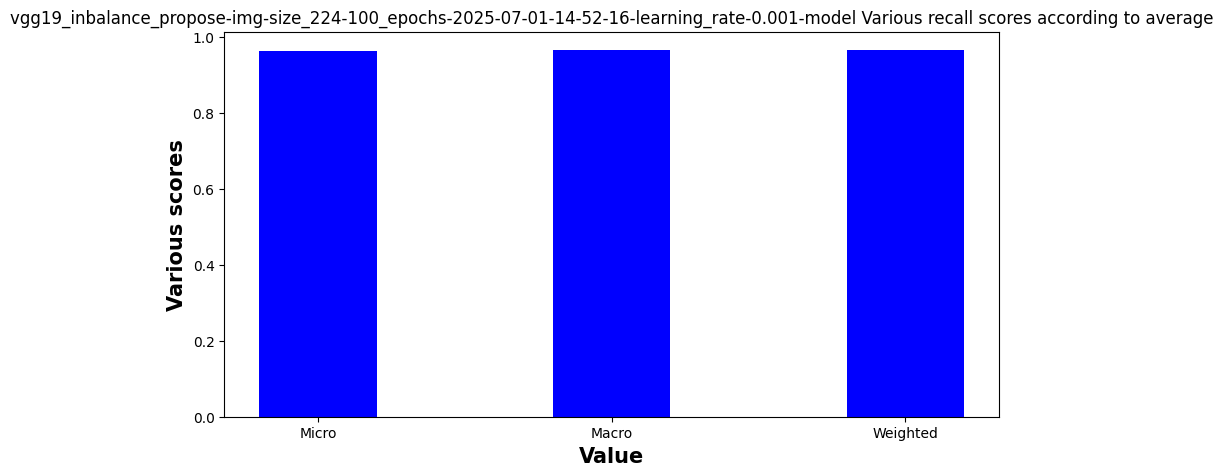

vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.940978 ║
║ meningioma ║   0.932476 ║
║  notumor   ║   0.992574 ║
║ pituitary  ║   0.991653 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║          0.96442 ║         0.966438 ║            0.966529 ║
╚══════════════════╩══════════════════╩═════════════════════╝


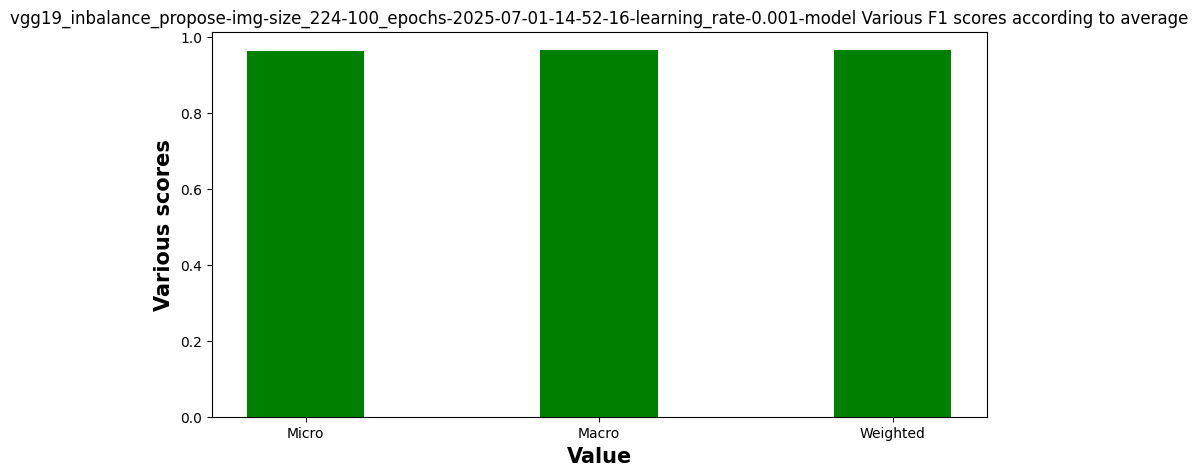

Classification Report : vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model
Cohen's Kappa Score vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.954977 ║
╚═══════════════════════╝
matthews_corrcoef Score vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.955034 ║
╚═══════════════════════════╝
Model Log loss vgg19_inbalance_propose-img-size_224-100_epochs-2025-07-01-14-52-16-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.110418 ║
╚════════════╝
---------- call model prediction ------------


In [22]:
from tensorflow.keras.applications import VGG19

input_shape = (image_size, image_size, 3)

# Load VGG19 model, excluding the top layers (classification head)
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained VGG19 layers to prevent them from being updated during training
vgg_base.trainable = False

# Flatten the output from VGG19
vbo = vgg_base.output
x = Flatten()(vbo)

# Add custom dense layers for classification
x = Dense(units=1024, activation='relu')(x)  # Adjust units and activation as needed
x = Dropout(0.5)(x)  # Consider adding dropout for regularization

# Add the final output layer based on your number of classes
outputs = Dense(units=num_classes, activation='softmax')(x)  # Replace num_classes with actual value

# Create the final model
model = Model(inputs=vgg_base.input, outputs=outputs, name="vgg19")

model_name = model.name
print(f"Model Start to train: ",model_name)
    
balance_model = model_name+"_balance_propose"
model_training_validation(model,balance_model,X_train_balance,Y_train_label_balance,x_test,y_test_label)
   
    
inbalance_model = model_name+"_inbalance_propose"
model_training_validation(model,inbalance_model,X_train_inbalance,Y_train_label_inbalance,x_test,y_test_label)


## 12.3 VGG16 Model Creation Training And Validation with Balance, Inbalance Data

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Start to train: 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


 vgg16
taining model inside details  vgg16_balance_propose 

taining model status vgg16_balance_propose 

---------- model compile ------------
---------- model checkpoint callback ------------
---------- tensorboard callback ------------
---------- wandb callback start after loggin ------------


wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_093157-1neubqqm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/1neubqqm


---------- wandb callback start after loggin ------------
--- Trainned model data - vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_3, 	 	 | Shape :  None
Name : block1_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : block1_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block1_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block2_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block2_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block2_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block3_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block3_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_conv3, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block4_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : bl

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,644 (62.26 MB)

 Trainable params: 1,605,956 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.75820, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.75820 to 0.81083, saving model to propose.002.keras

Epoch 3: val_accuracy improved from 0.81083 to 0.84973, saving model to propose.003.keras

Epoch 4: val_accuracy did not improve from 0.84973

Epoch 5: val_accuracy improved from 0.84973 to 0.86728, saving model to propose.005.keras

Epoch 6: val_accuracy improved from 0.86728 to 0.87719, saving model to propose.006.keras

Epoch 7: val_accuracy improved from 0.87719 to 0.90389, saving model to propose.007.keras

Epoch 8: val_accuracy improved from 0.90389 to 0.91381, saving model to propose.008.keras

Epoch 9: val_accuracy did not improve from 0.91381

Epoch 10: val_accuracy did not improve from 0.91381

Epoch 11: val_accuracy did not improve from 0.91381

Epoch 12: val_accuracy improved from 0.91381 to 0.92220, saving model to propose.012.keras

Epoch 13: val_accuracy improved from 0.92220 to 0.93516, saving

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▁▃▅▅▅▂▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
wandb:                     train/epoch_learning_rate ██████████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁
wandb:                              train/epoch_loss █▅▄▄▄▅▃▃▂▂▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▃▄▅▅▄▇██▄▂▃▃▃▃▃▃▂▃▃▃▃▃▄▃▃▄▄▄▄▄▄▅▄▄▄▅▄▄▄
wandb:                            train/epoch_recall ▁▃▄▄▄▂▅▅▅▇▇▇▇▇▇▇▇▇█▇▇███▇▇██████████████
wandb:                             train/global_step ▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
wandb:                     validation/epoch_accuracy ▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇██▇████████████████
wandb:                         validation/epoch_loss █▆▄▄▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/ep

---------- call model training history visualization ------------


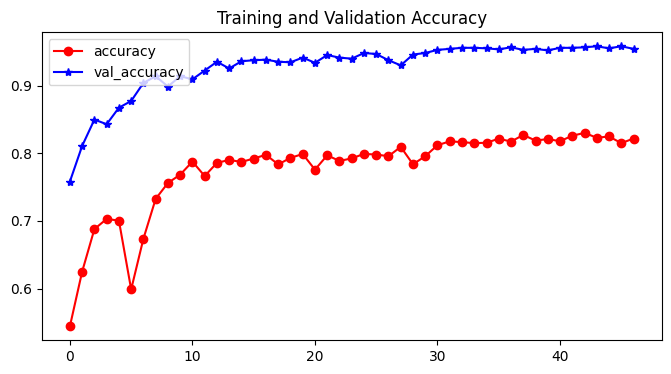

<Figure size 640x480 with 0 Axes>

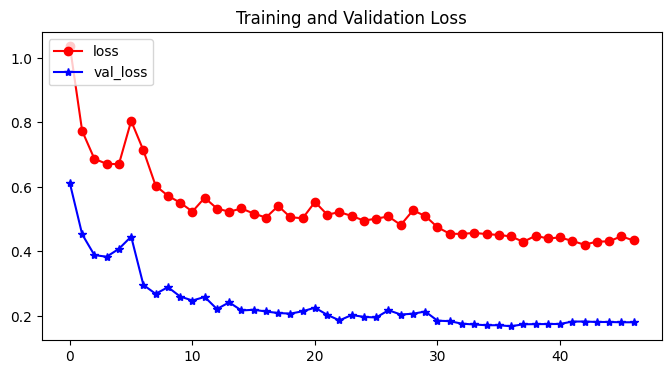

<Figure size 640x480 with 0 Axes>

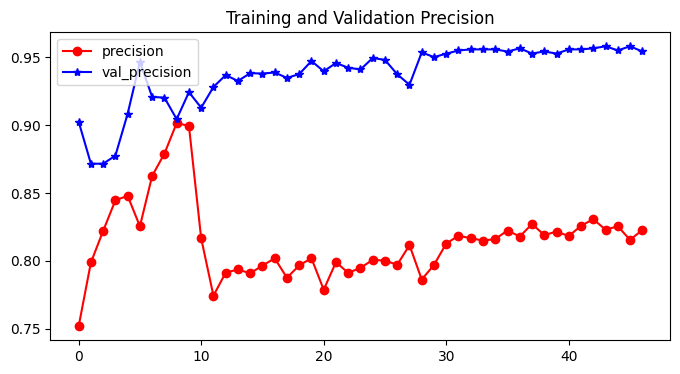

<Figure size 640x480 with 0 Axes>

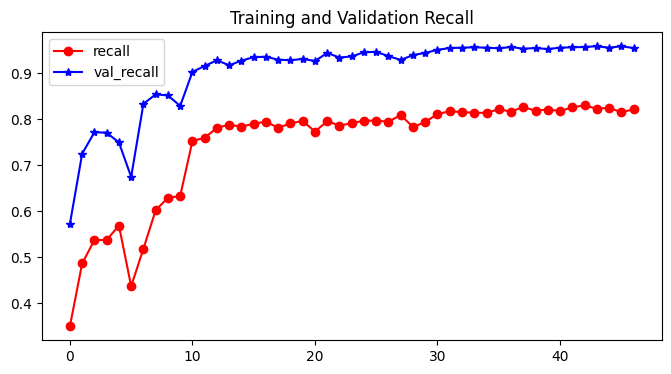

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9297 - loss: 0.2178 - precision: 0.9297 - recall: 0.9297
vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.168009 ║        0.956522 ║        16.8009 ║            95.6522 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


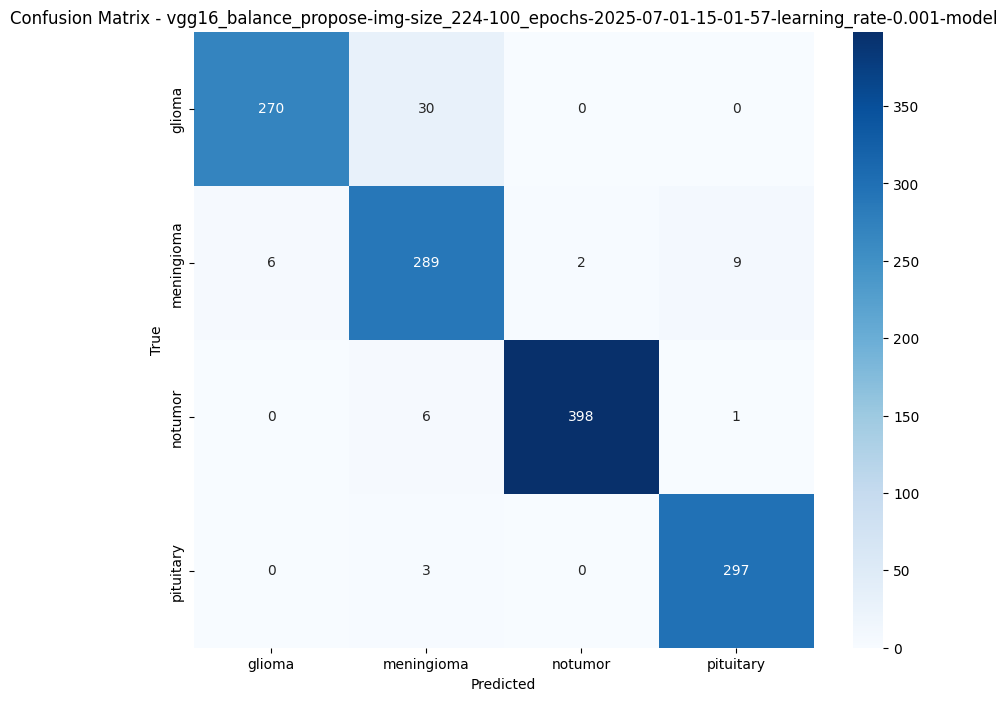

vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.9      ║
║ meningioma ║        0.944444 ║
║  notumor   ║        0.982716 ║
║ pituitary  ║        0.99     ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   3 ║                     0.98579 ║
╚═════════════════════╩═════════════════════════════╝
Specificity vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.994065 ║
║ meningioma ║      0.961194 ║
║  notumor   ║      0.997792 ║
║ pituitary  ║      0.990109 ║
╚════════════╩═══════════════╝
ROC AUC 

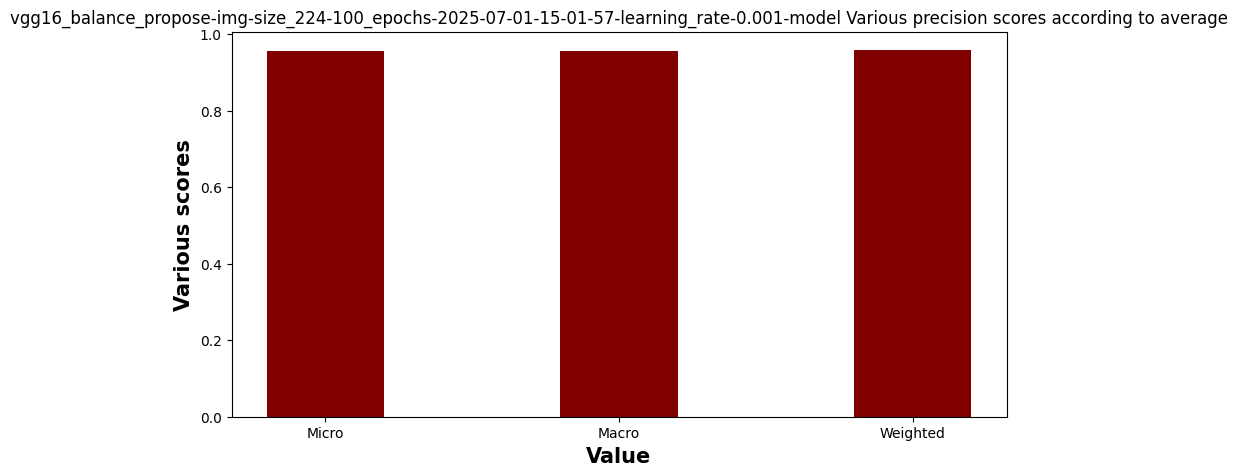

vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.9      ║
║ meningioma ║       0.944444 ║
║  notumor   ║       0.982716 ║
║ pituitary  ║       0.99     ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║              0.95429 ║             0.956522 ║                0.956522 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


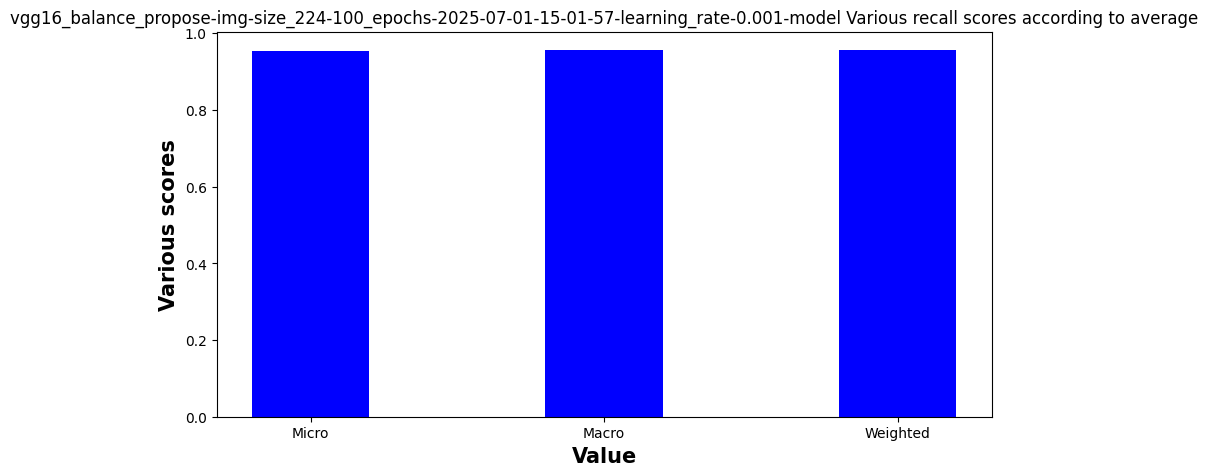

vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.9375   ║
║ meningioma ║   0.911672 ║
║  notumor   ║   0.98882  ║
║ pituitary  ║   0.978583 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.954144 ║         0.956522 ║            0.956727 ║
╚══════════════════╩══════════════════╩═════════════════════╝


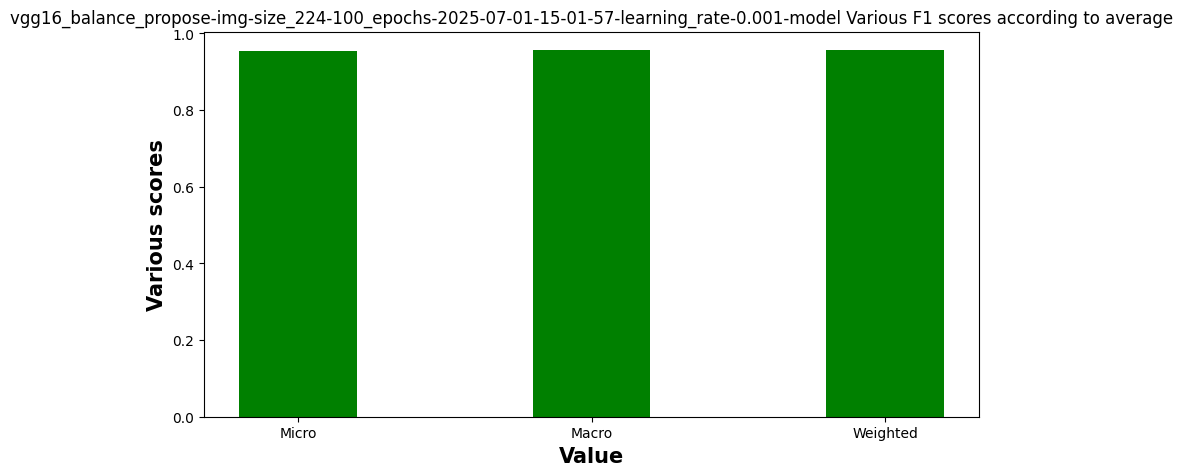

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classification Report : vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model
Cohen's Kappa Score vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.941686 ║
╚═══════════════════════╝
matthews_corrcoef Score vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.942103 ║
╚═══════════════════════════╝
Model Log loss vgg16_balance_propose-img-size_224-100_epochs-2025-07-01-15-01-57-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.168009 ║
╚════════════╝
---------- call model prediction ------------
taining model inside details  vgg16_inbalance_propose 

taining model status vgg16_inbalance_propose 

---------- model compile ------------
-------

wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_094627-whbq797c
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/whbq797c


---------- wandb callback start after loggin ------------
--- Trainned model data - vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_3, 	 	 | Shape :  None
Name : block1_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : block1_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block1_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block2_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : block2_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block2_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block3_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 128})
Name : block3_conv2, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_conv3, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : block3_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : block4_conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 256})
Name : 

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,644 (62.26 MB)

 Trainable params: 1,605,956 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.95500, saving model to propose.001.keras

Epoch 2: val_accuracy did not improve from 0.95500

Epoch 3: val_accuracy improved from 0.95500 to 0.95652, saving model to propose.003.keras

Epoch 4: val_accuracy did not improve from 0.95652

Epoch 5: val_accuracy did not improve from 0.95652

Epoch 6: val_accuracy did not improve from 0.95652

Epoch 7: val_accuracy did not improve from 0.95652

Epoch 8: val_accuracy did not improve from 0.95652

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 9: val_accuracy did not improve from 0.95652

Epoch 10: val_accuracy did not improve from 0.95652

Epoch 11: val_accuracy improved from 0.95652 to 0.96034, saving model to propose.011.keras

Epoch 12: val_accuracy did not improve from 0.96034

Epoch 13: val_accuracy did not improve from 0.96034

Epoch 14: val_accuracy did not improve from 0.96034

Epoch 15: val_accuracy did not improve from 0.96034

Epoch 16: val_accurac

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▃▁▅▆▅▃▄▄▅█▅▇▅▇▇▇▇▆▇█▇▆▆▆▇▆
wandb:                     train/epoch_learning_rate ████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
wandb:                              train/epoch_loss ▇█▆▄▅▆▅▅▄▂▃▂▃▂▂▂▂▃▂▁▂▂▂▂▂▂
wandb:                         train/epoch_precision ▃▁▅▆▅▃▄▄▅█▅▇▅▇▇▇▇▆▇█▇▆▆▆▇▆
wandb:                            train/epoch_recall ▃▁▅▆▅▃▄▄▅█▅▇▅▇▇▇▇▆▇█▇▆▆▆▇▆
wandb:                             train/global_step ▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
wandb:                     validation/epoch_accuracy ▇▁▇▁▆▆▃▂▆▇█▆▇▇█▇▇▇▇▇▇▇▇▇▇▇
wandb:                         validation/epoch_loss ▃█▃█▄▄▄▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▇▂▇▁▆▆▃▃▆▆█▆▇▇█▆▇▇▇▇▇▇▇▇▇▇
wandb:                       validation/epoch_recall ▇▁▇▃▇▆▄▃▆▇█▆▇█

---------- call model training history visualization ------------


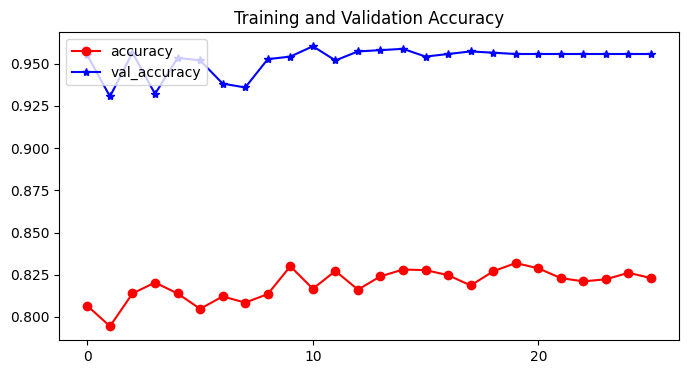

<Figure size 640x480 with 0 Axes>

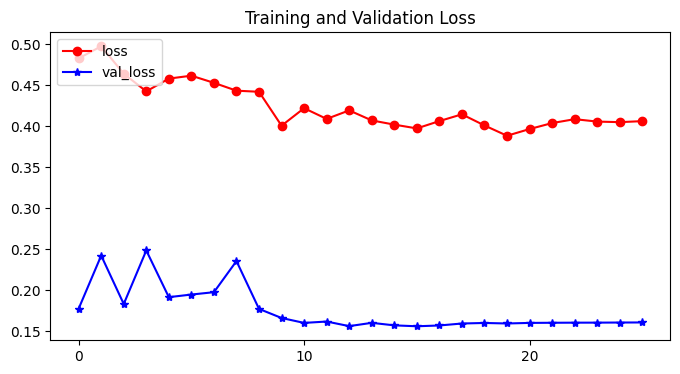

<Figure size 640x480 with 0 Axes>

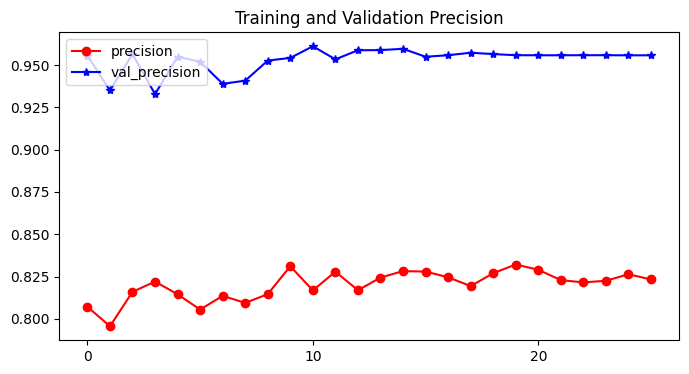

<Figure size 640x480 with 0 Axes>

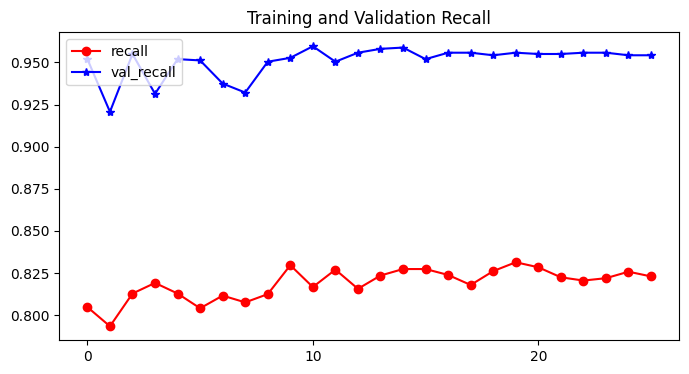

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9361 - loss: 0.2051 - precision: 0.9369 - recall: 0.9338
vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.155759 ║        0.954233 ║        15.5759 ║            95.4233 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


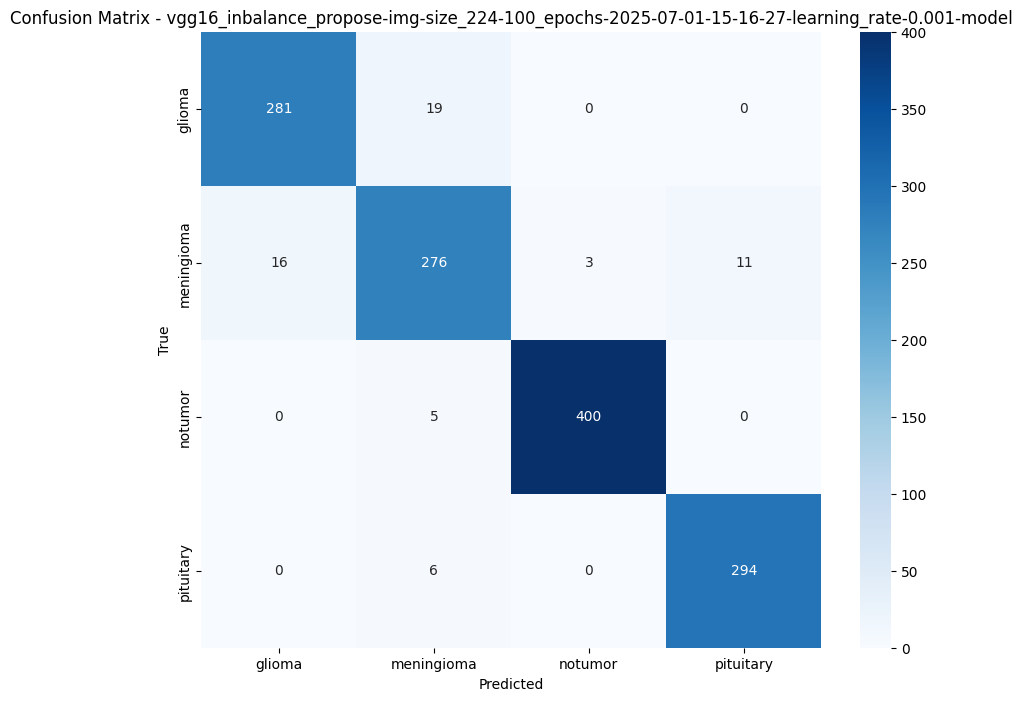

vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.936667 ║
║ meningioma ║        0.901961 ║
║  notumor   ║        0.987654 ║
║ pituitary  ║        0.98     ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.985033 ║
╚═════════════════════╩═════════════════════════════╝
Specificity vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.984174 ║
║ meningioma ║      0.970149 ║
║  notumor   ║      0.996689 ║
║ pituitary  ║      0.98912  ║
╚════════════╩═══════════════╝
ROC 

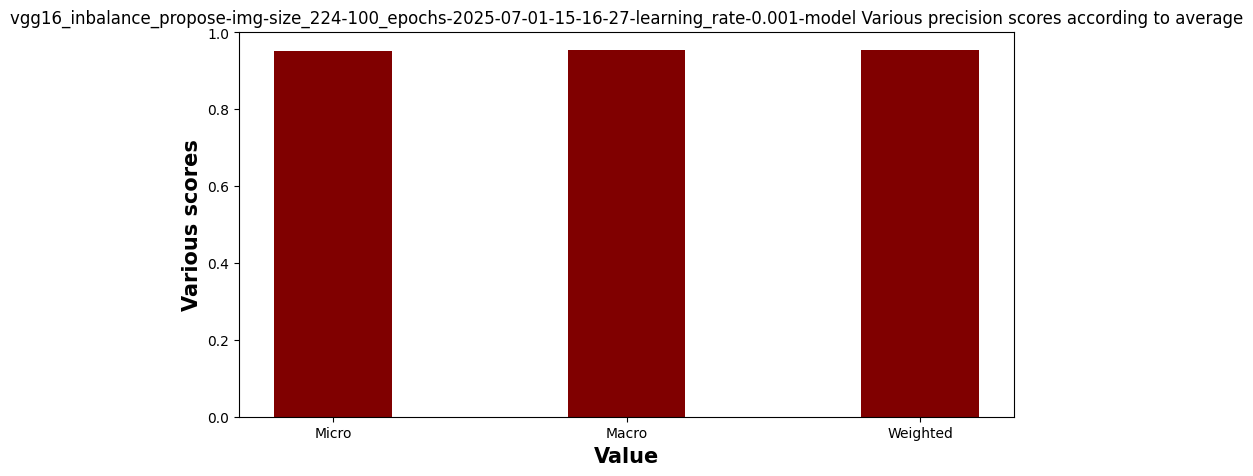

vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.936667 ║
║ meningioma ║       0.901961 ║
║  notumor   ║       0.987654 ║
║ pituitary  ║       0.98     ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║              0.95157 ║             0.954233 ║                0.954233 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


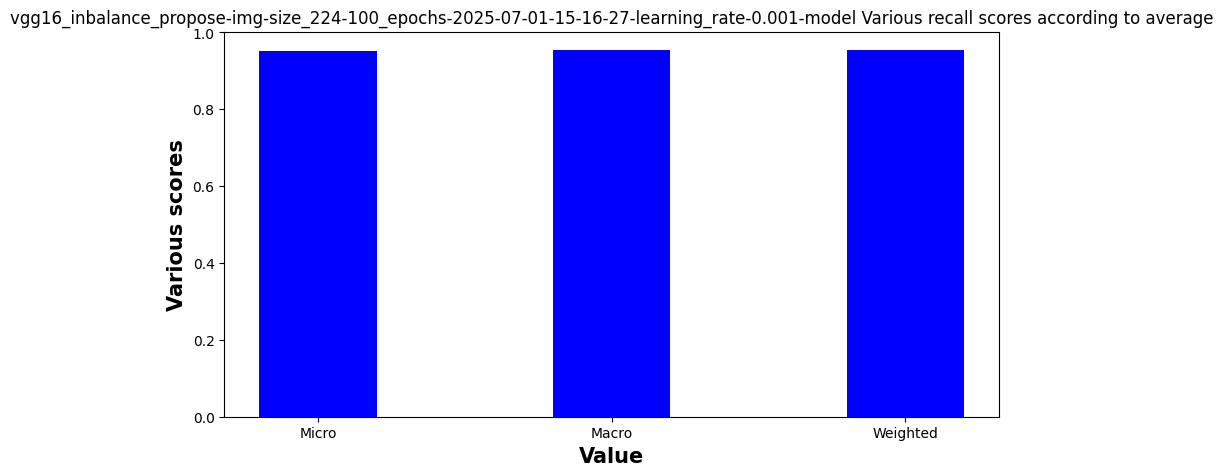

vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.941374 ║
║ meningioma ║   0.901961 ║
║  notumor   ║   0.990099 ║
║ pituitary  ║   0.971901 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.951334 ║         0.954233 ║            0.954212 ║
╚══════════════════╩══════════════════╩═════════════════════╝


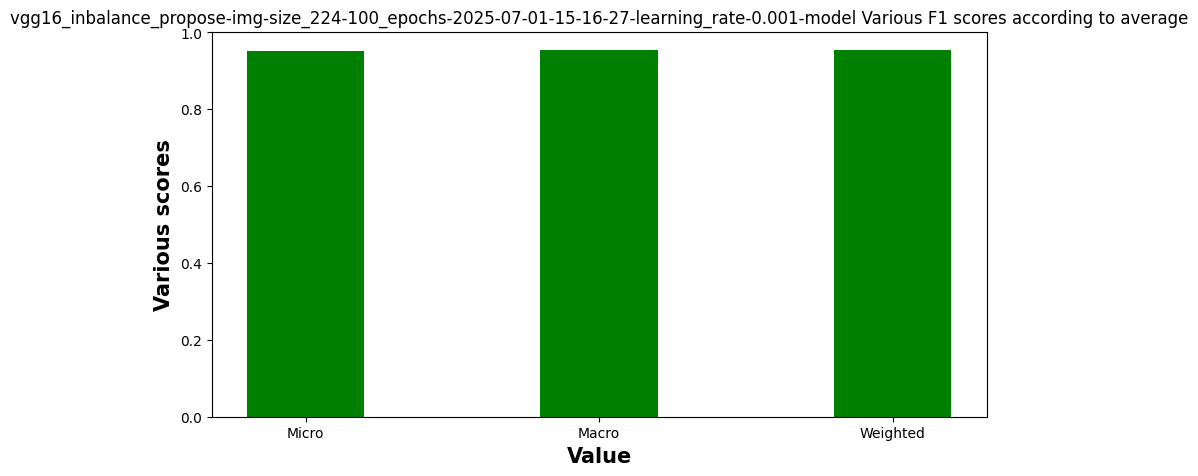

Classification Report : vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model
Cohen's Kappa Score vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.938608 ║
╚═══════════════════════╝
matthews_corrcoef Score vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.938622 ║
╚═══════════════════════════╝
Model Log loss vgg16_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-16-27-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.155759 ║
╚════════════╝
---------- call model prediction ------------


In [23]:
from keras.applications.vgg16 import VGG16

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

base_model.trainable = False
# Add a new classification head
bmo = base_model.output
fl1 = Flatten()(bmo)

# Add custom dense layers for classification
dense1 = Dense(units=64, activation='relu')(fl1)  # Adjust number of units as needed
drop1 = Dropout(0.5)(dense1)  # Add dropout for regularization to prevent overfitting

dense2 = Dense(num_classes, activation='softmax')(drop1)  

# Create the final model
model = Model(inputs=base_model.inputs, outputs=dense2, name="vgg16")

model_name = model.name
print(f"Model Start to train: ",model_name)
    
balance_model = model_name+"_balance_propose"
model_training_validation(model,balance_model,X_train_balance,Y_train_label_balance,x_test,y_test_label)
   
    
inbalance_model = model_name+"_inbalance_propose"
model_training_validation(model,inbalance_model,X_train_inbalance,Y_train_label_inbalance,x_test,y_test_label)

## 12.4 NiN Creation Training And Validation with Balance, Inbalance Data set

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model Start to train:  NIN
taining model inside details  NIN_balance_propose 

taining model status NIN_balance_propose 

---------- model compile ------------
---------- model checkpoint callback ------------
---------- tensorboard callback ------------
---------- wandb callback start after loggin ------------


wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_095519-bmh7csvj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/bmh7csvj


---------- wandb callback start after loggin ------------
--- Trainned model data - NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_4, 	 	 | Shape :  None
Name : conv2d_60, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : conv2d_61, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 192})
Name : conv2d_62, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 192})
Name : max_pooling2d_17, 	 	 | Shape :  InputSpec(ndim=4)
Name : dropout_5, 	 	 | Shape :  None
Name : conv2d_63, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 192})
Name : conv2d_64, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 160})
Name : conv2d_65, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 160})
Name : conv2d_66, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 160})
Name : conv2d_67, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 96})
Name : conv2d_68, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 96})
Name : max_pooling2d_18, 	 

Model: "NIN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 224, 224, 192)  │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 224, 224, 192)  │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 224, 224, 192)  │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 111, 111, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 111, 111, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 111, 111, 160)  │        30,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 111, 111, 160)  │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 111, 111, 160)  │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 111, 111, 96)   │        15,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 111, 111, 96)   │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 111, 111, 96)   │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 55, 55, 192)    │       460,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 27, 27, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 27, 27, 192)    │             

 Total params: 969,580 (3.70 MB)

 Trainable params: 969,580 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.22883, saving model to propose.001.keras

Epoch 2: val_accuracy did not improve from 0.22883

Epoch 3: val_accuracy did not improve from 0.22883

Epoch 4: val_accuracy did not improve from 0.22883

Epoch 5: val_accuracy did not improve from 0.22883

Epoch 6: val_accuracy did not improve from 0.22883

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 7: val_accuracy did not improve from 0.22883

Epoch 8: val_accuracy did not improve from 0.22883

Epoch 9: val_accuracy did not improve from 0.22883

Epoch 10: val_accuracy did not improve from 0.22883

Epoch 11: val_accuracy did not improve from 0.22883

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
---------- model saved name:- save-NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model.h5------------


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
wandb:                          train/epoch_accuracy ▁██████████
wandb:                     train/epoch_learning_rate ██████▁▁▁▁▁
wandb:                              train/epoch_loss █▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▁▁▁▁▁▁▁▁▁▁
wandb:                            train/epoch_recall ▁▁▁▁▁▁▁▁▁▁▁
wandb:                             train/global_step ▁▁▂▂▃▄▄▅▅▆▇▇█
wandb:                     validation/epoch_accuracy ▁▁▁▁▁▁▁▁▁▁▁
wandb:                         validation/epoch_loss ▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▁▁▁▁▁▁▁▁▁▁▁
wandb:                       validation/epoch_recall ▁▁▁▁▁▁▁▁▁▁▁
wandb:  validation/evaluation_accuracy_vs_iterations ▁▁▁▁▁▁▁▁▁▁▁
wandb:      validation/evaluation_loss_vs_iterations ▁▁▁▁▁▁▁▁▁▁▁
wandb: validation/evaluatio

---------- call model training history visualization ------------


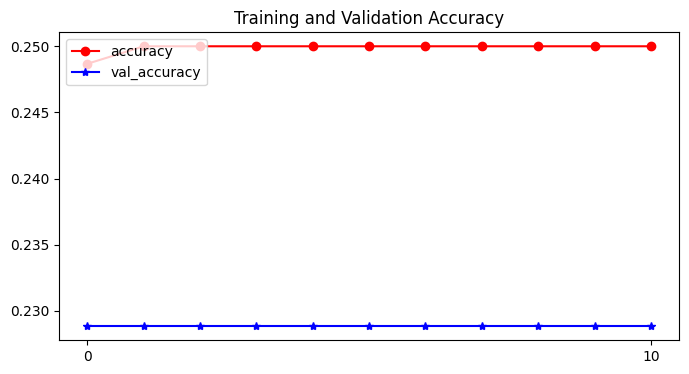

<Figure size 640x480 with 0 Axes>

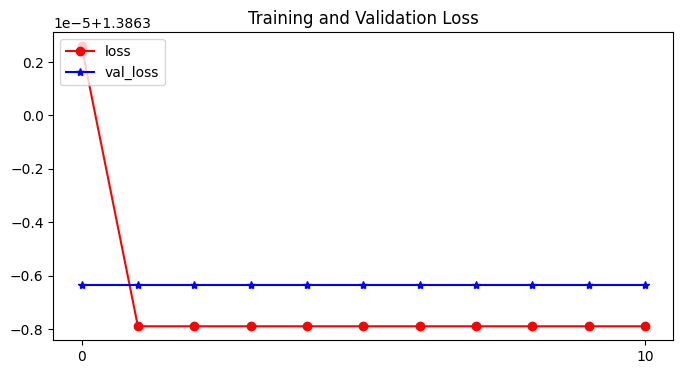

<Figure size 640x480 with 0 Axes>

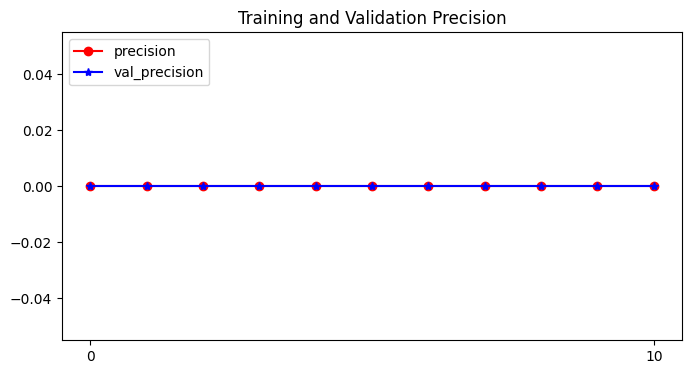

<Figure size 640x480 with 0 Axes>

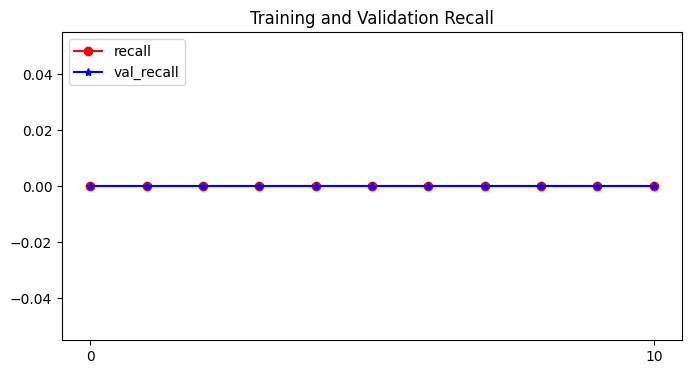

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 337ms/step - accuracy: 0.5487 - loss: 1.3863 - precision: 0.0000e+00 - recall: 0.0000e+00
NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║     1.38629 ║        0.228833 ║        138.629 ║            22.8833 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step


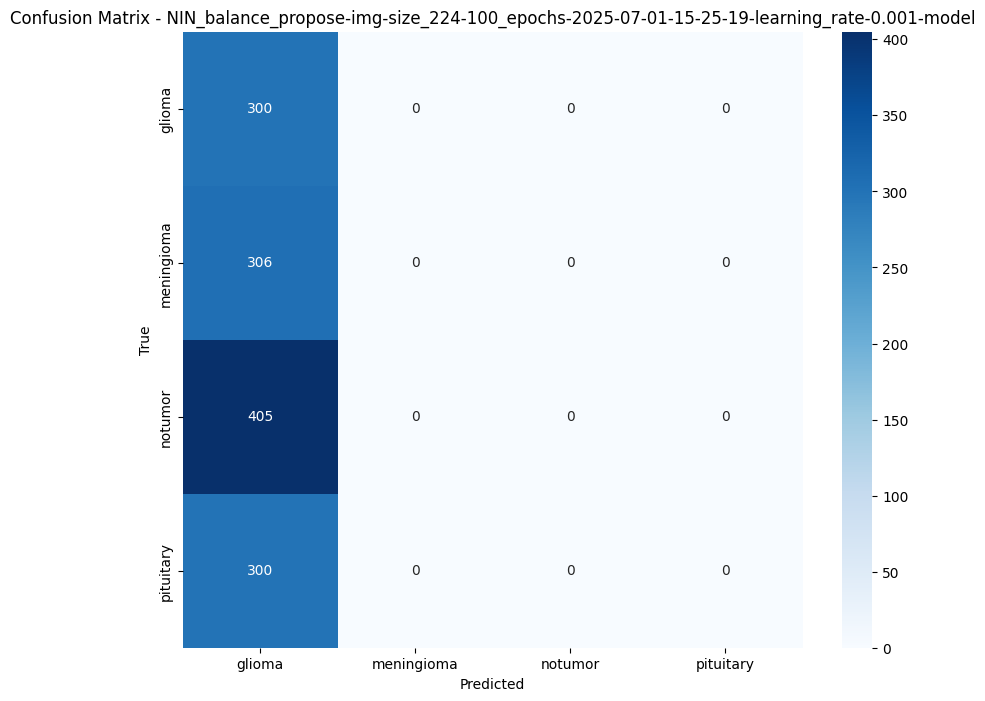

NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║               1 ║
║ meningioma ║               0 ║
║  notumor   ║               0 ║
║ pituitary  ║               0 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   0 ║                        0.75 ║
╚═════════════════════╩═════════════════════════════╝
Specificity NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║             0 ║
║ meningioma ║             1 ║
║  notumor   ║             1 ║
║ pituitary  ║             1 ║
╚════════════╩═══════════════╝
ROC AUC Scor

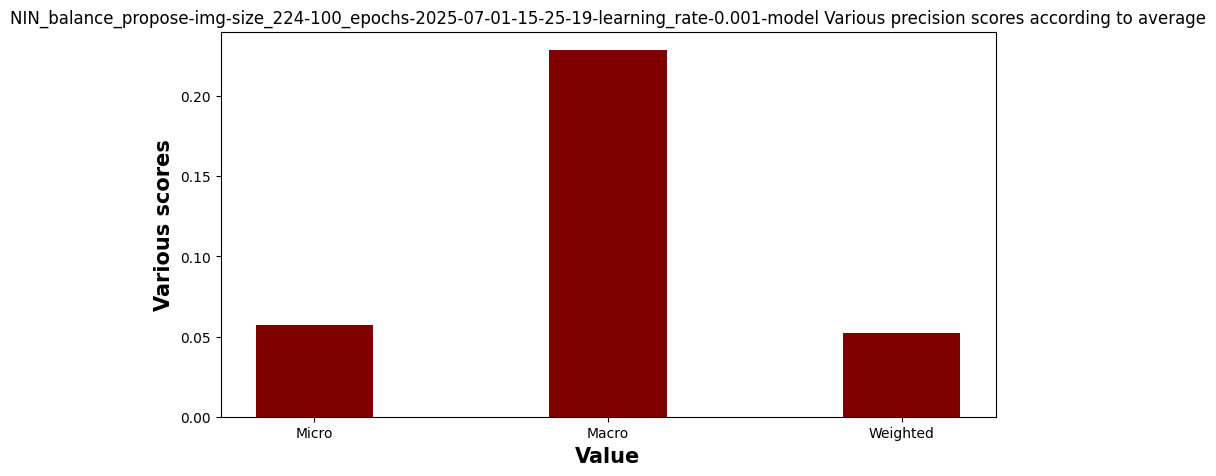

NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║              1 ║
║ meningioma ║              0 ║
║  notumor   ║              0 ║
║ pituitary  ║              0 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║                 0.25 ║             0.228833 ║                0.228833 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


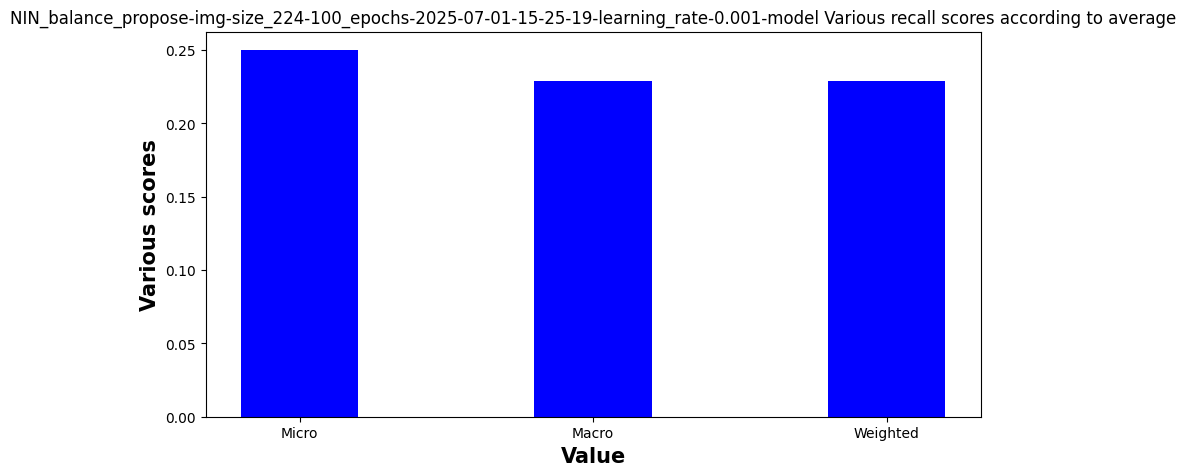

NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.372439 ║
║ meningioma ║   0        ║
║  notumor   ║   0        ║
║ pituitary  ║   0        ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║        0.0931099 ║         0.228833 ║           0.0852264 ║
╚══════════════════╩══════════════════╩═════════════════════╝


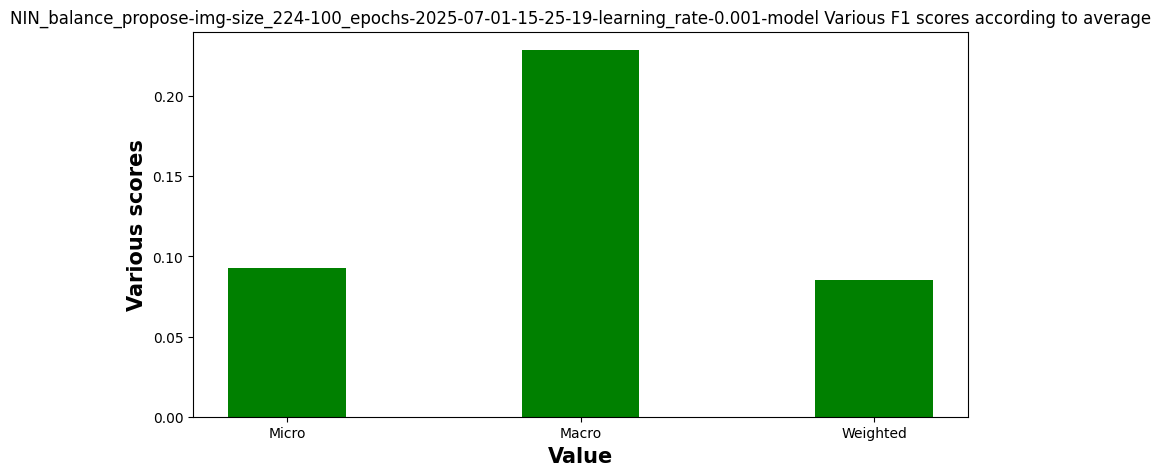

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classification Report : NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model
Cohen's Kappa Score NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║                     0 ║
╚═══════════════════════╝
matthews_corrcoef Score NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                         0 ║
╚═══════════════════════════╝
Model Log loss NIN_balance_propose-img-size_224-100_epochs-2025-07-01-15-25-19-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║    1.38629 ║
╚════════════╝
---------- call model prediction ------------
taining model inside details  NIN_inbalance_propose 

taining model status NIN_inbalance_propose 

---------- model compile ------------
---------- model ch

wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_100716-8wjo6bd7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/8wjo6bd7


---------- wandb callback start after loggin ------------
--- Trainned model data - NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_4, 	 	 | Shape :  None
Name : conv2d_60, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : conv2d_61, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 192})
Name : conv2d_62, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 192})
Name : max_pooling2d_17, 	 	 | Shape :  InputSpec(ndim=4)
Name : dropout_5, 	 	 | Shape :  None
Name : conv2d_63, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 192})
Name : conv2d_64, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 160})
Name : conv2d_65, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 160})
Name : conv2d_66, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 160})
Name : conv2d_67, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 96})
Name : conv2d_68, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 96})
Name : max_pooling2d_18, 

Model: "NIN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 224, 224, 192)  │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 224, 224, 192)  │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 224, 224, 192)  │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 111, 111, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 111, 111, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 111, 111, 160)  │        30,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 111, 111, 160)  │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 111, 111, 160)  │        25,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 111, 111, 96)   │        15,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 111, 111, 96)   │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 111, 111, 96)   │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 55, 55, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 55, 55, 192)    │       460,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 55, 55, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 27, 27, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 27, 27, 192)    │             

 Total params: 969,580 (3.70 MB)

 Trainable params: 969,580 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.22883, saving model to propose.001.keras

Epoch 2: val_accuracy did not improve from 0.22883

Epoch 3: val_accuracy did not improve from 0.22883

Epoch 4: val_accuracy did not improve from 0.22883

Epoch 5: val_accuracy did not improve from 0.22883

Epoch 6: val_accuracy did not improve from 0.22883

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 7: val_accuracy did not improve from 0.22883

Epoch 8: val_accuracy did not improve from 0.22883

Epoch 9: val_accuracy did not improve from 0.22883

Epoch 10: val_accuracy did not improve from 0.22883

Epoch 11: val_accuracy did not improve from 0.22883

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
---------- model saved name:- save-NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model.h5------------


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
wandb:                          train/epoch_accuracy ▁▁▁▁▁▁▁▁▁▁▁
wandb:                     train/epoch_learning_rate ██████▁▁▁▁▁
wandb:                              train/epoch_loss ▁▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▁▁▁▁▁▁▁▁▁▁
wandb:                            train/epoch_recall ▁▁▁▁▁▁▁▁▁▁▁
wandb:                             train/global_step ▁▁▂▂▃▃▄▅▅▅▆▇▇▇█
wandb:                     validation/epoch_accuracy ▁▁▁▁▁▁▁▁▁▁▁
wandb:                         validation/epoch_loss ▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▁▁▁▁▁▁▁▁▁▁▁
wandb:                       validation/epoch_recall ▁▁▁▁▁▁▁▁▁▁▁
wandb:  validation/evaluation_accuracy_vs_iterations ▁▁▁▁▁▁▁▁▁▁▁
wandb:      validation/evaluation_loss_vs_iterations ▁▁▁▁▁▁▁▁▁▁▁
wandb: validation/evaluat

---------- call model training history visualization ------------


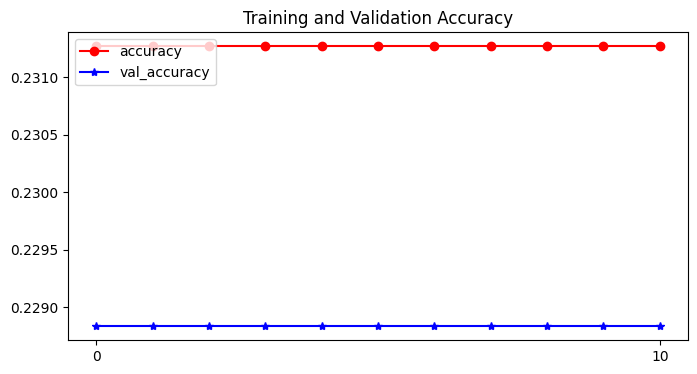

<Figure size 640x480 with 0 Axes>

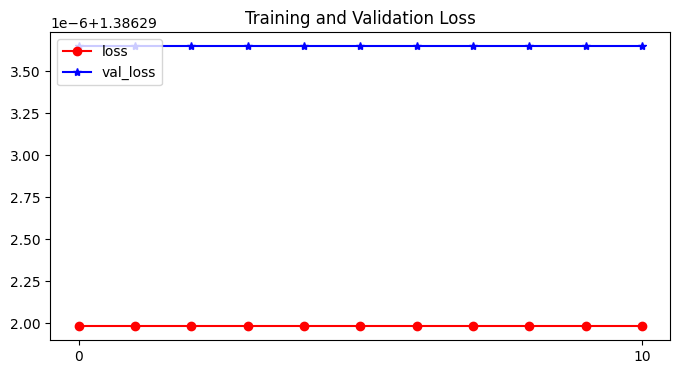

<Figure size 640x480 with 0 Axes>

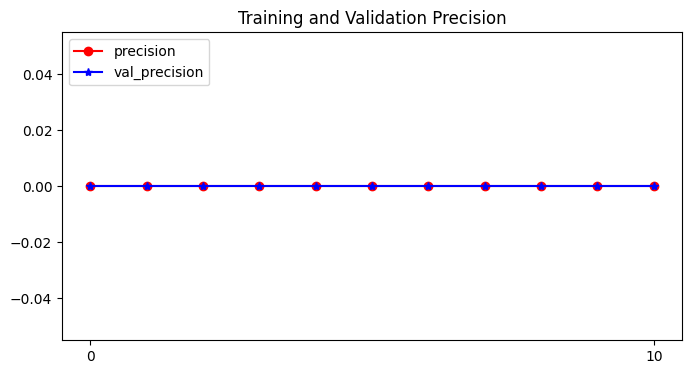

<Figure size 640x480 with 0 Axes>

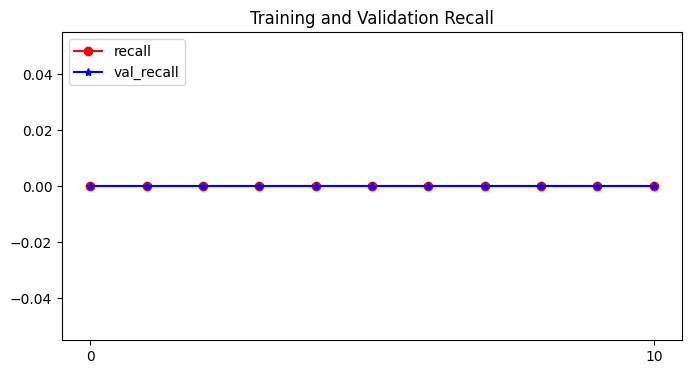

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.5487 - loss: 1.3863 - precision: 0.0000e+00 - recall: 0.0000e+00
NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║     1.38629 ║        0.228833 ║        138.629 ║            22.8833 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


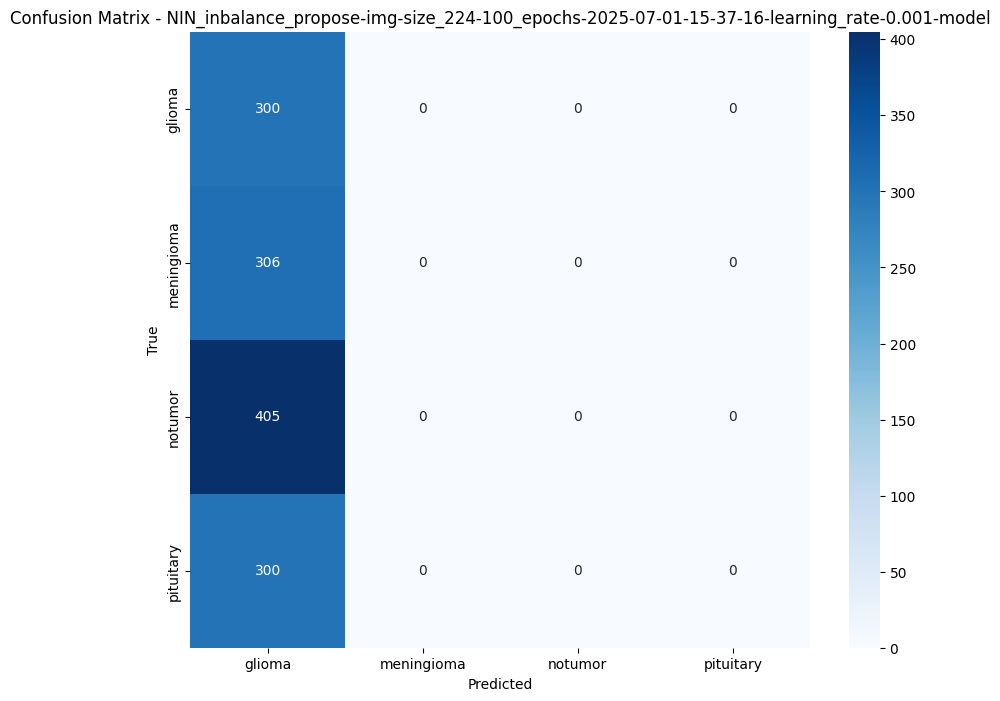

NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║               1 ║
║ meningioma ║               0 ║
║  notumor   ║               0 ║
║ pituitary  ║               0 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   0 ║                        0.75 ║
╚═════════════════════╩═════════════════════════════╝
Specificity NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║             0 ║
║ meningioma ║             1 ║
║  notumor   ║             1 ║
║ pituitary  ║             1 ║
╚════════════╩═══════════════╝
ROC AUC 

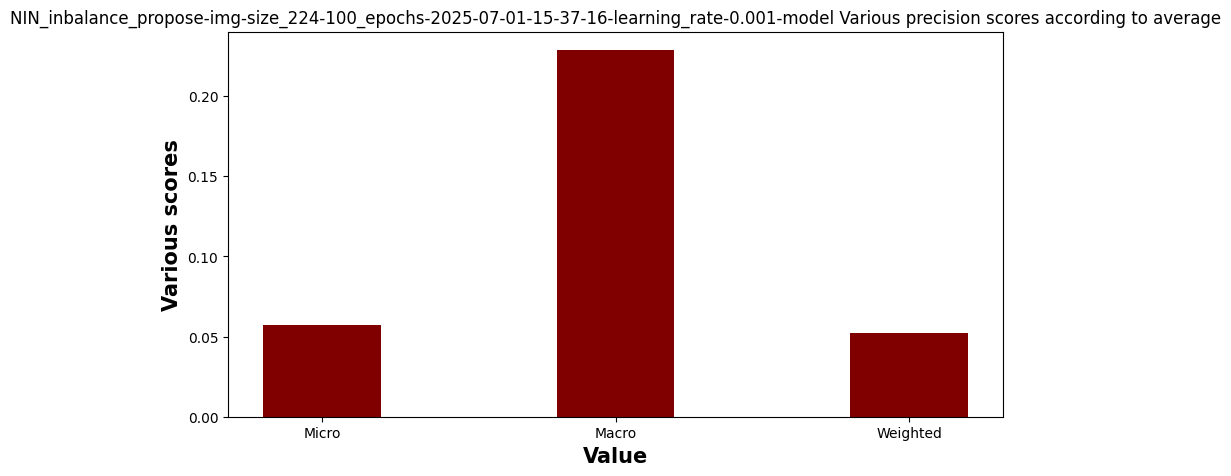

NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║              1 ║
║ meningioma ║              0 ║
║  notumor   ║              0 ║
║ pituitary  ║              0 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║                 0.25 ║             0.228833 ║                0.228833 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


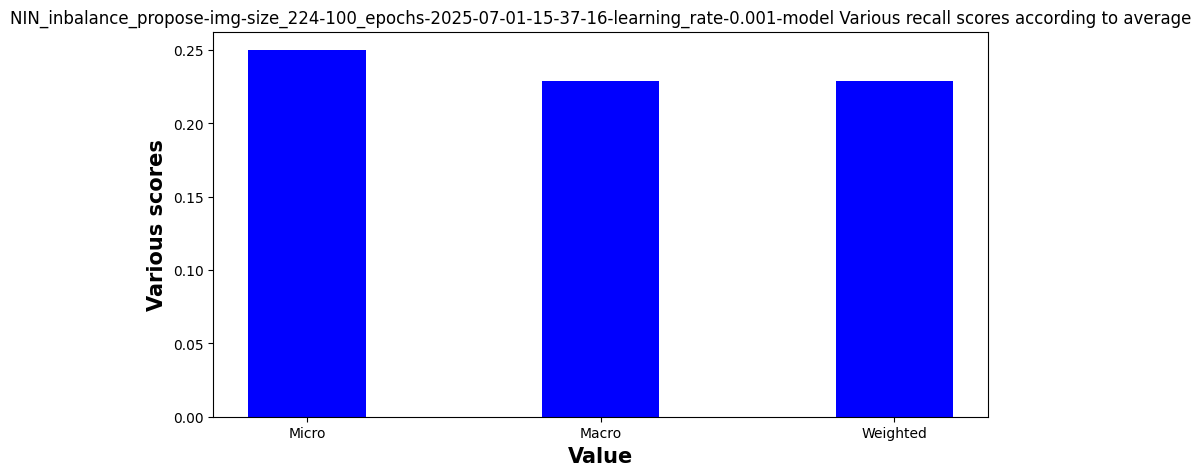

NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.372439 ║
║ meningioma ║   0        ║
║  notumor   ║   0        ║
║ pituitary  ║   0        ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║        0.0931099 ║         0.228833 ║           0.0852264 ║
╚══════════════════╩══════════════════╩═════════════════════╝


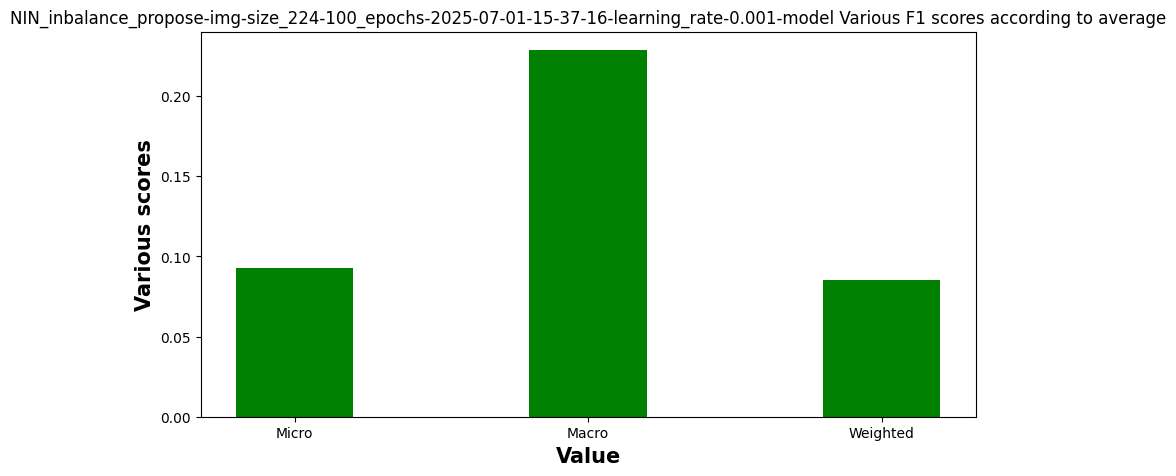

Classification Report : NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model
Cohen's Kappa Score NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║                     0 ║
╚═══════════════════════╝
matthews_corrcoef Score NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                         0 ║
╚═══════════════════════════╝
Model Log loss NIN_inbalance_propose-img-size_224-100_epochs-2025-07-01-15-37-16-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║    1.38629 ║
╚════════════╝
---------- call model prediction ------------


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def nin_block(x, filters, kernel_size, strides, padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, activation='relu')(x)
    x = layers.Conv2D(filters, 1, activation='relu')(x)
    x = layers.Conv2D(filters, 1, activation='relu')(x)
    return x

def NIN(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = nin_block(inputs, filters=192, kernel_size=5, strides=1)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Dropout(0.5)(x)
    
    x = nin_block(x, filters=160, kernel_size=1, strides=1)
    x = nin_block(x, filters=96, kernel_size=1, strides=1)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Dropout(0.5)(x)
    
    x = nin_block(x, filters=192, kernel_size=5, strides=1)
    x = nin_block(x, filters=192, kernel_size=1, strides=1)
    x = nin_block(x, filters=192, kernel_size=1, strides=1)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Dropout(0.5)(x)
    
    x = nin_block(x, filters=num_classes, kernel_size=3, strides=1)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Activation('softmax')(x)
    
    model = Model(inputs, outputs, name="NIN")
    return model

# Example usage:
input_shape = (image_size, image_size, 3)  # example input shape
model = NIN(input_shape, num_classes)

model_name = model.name
print(f"Model Start to train: ",model_name)
    
balance_model = model_name+"_balance_propose"
model_training_validation(model,balance_model,X_train_balance,Y_train_label_balance,x_test,y_test_label)
   
    
inbalance_model = model_name+"_inbalance_propose"
model_training_validation(model,inbalance_model,X_train_inbalance,Y_train_label_inbalance,x_test,y_test_label)

## 12.5 RestNet50 Creation Training And Validation with Balance, Inbalance Data set

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model Start to train:  ResNet50
taining model inside details  ResNet50_balance_propose 

taining model status ResNet50_balance_propose 

---------- model compile ------------
---------- model checkpoint callback ------------
---------- tensorboard callback ------------
---------- wandb callback start after loggin ------------


wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_101905-lvo0mlek
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/lvo0mlek


---------- wandb callback start after loggin ------------
--- Trainned model data - ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_5, 	 	 | Shape :  None
Name : conv1_pad, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv1_conv, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : conv1_bn, 	 	 | Shape :  InputSpec(ndim=4, axes={3: 64})
Name : conv1_relu, 	 	 | Shape :  None
Name : pool1_pad, 	 	 | Shape :  InputSpec(ndim=4)
Name : pool1_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2_block1_1_conv, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2_block1_1_bn, 	 	 | Shape :  InputSpec(ndim=4, axes={3: 64})
Name : conv2_block1_1_relu, 	 	 | Shape :  None
Name : conv2_block1_2_conv, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2_block1_2_bn, 	 	 | Shape :  InputSpec(ndim=4, axes={3: 64})
Name : conv2_block1_2_relu, 	 	 | Shape :  None
Name : conv2_block1_0_co

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.77117, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.77117 to 0.81617, saving model to propose.002.keras

Epoch 3: val_accuracy improved from 0.81617 to 0.83524, saving model to propose.003.keras

Epoch 4: val_accuracy did not improve from 0.83524

Epoch 5: val_accuracy improved from 0.83524 to 0.84439, saving model to propose.005.keras

Epoch 6: val_accuracy improved from 0.84439 to 0.88253, saving model to propose.006.keras

Epoch 7: val_accuracy did not improve from 0.88253

Epoch 8: val_accuracy did not improve from 0.88253

Epoch 9: val_accuracy improved from 0.88253 to 0.88635, saving model to propose.009.keras

Epoch 10: val_accuracy improved from 0.88635 to 0.89092, saving model to propose.010.keras

Epoch 11: val_accuracy improved from 0.89092 to 0.89703, saving model to propose.011.keras

Epoch 12: val_accuracy did not improve from 0.89703

Epoch 13: val_accuracy improved from 0.89703 to 0.90847, saving

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████
wandb:                     train/epoch_learning_rate █████████████████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:                              train/epoch_loss █▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███████████████████
wandb:                            train/epoch_recall ▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
wandb:                             train/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
wandb:                     validation/epoch_accuracy ▁▃▄▄▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇███████████████████
wandb:                         validation/epoch_loss █▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/ep

---------- call model training history visualization ------------


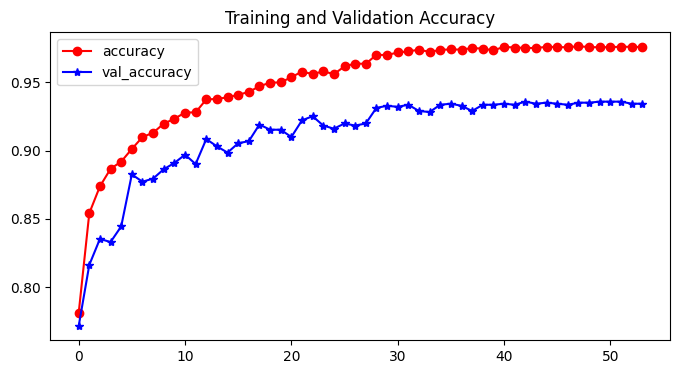

<Figure size 640x480 with 0 Axes>

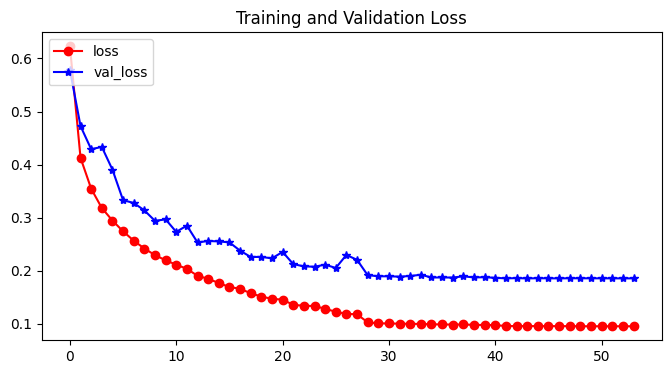

<Figure size 640x480 with 0 Axes>

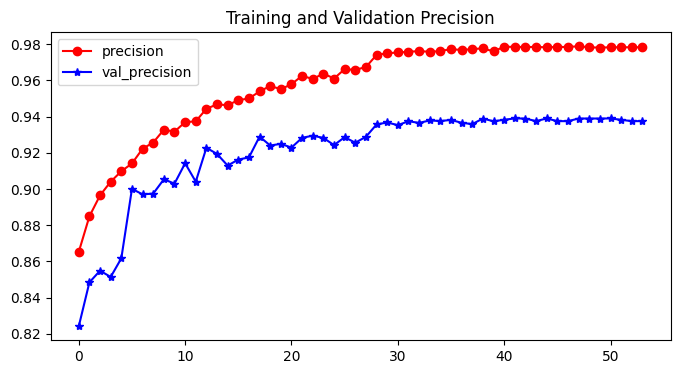

<Figure size 640x480 with 0 Axes>

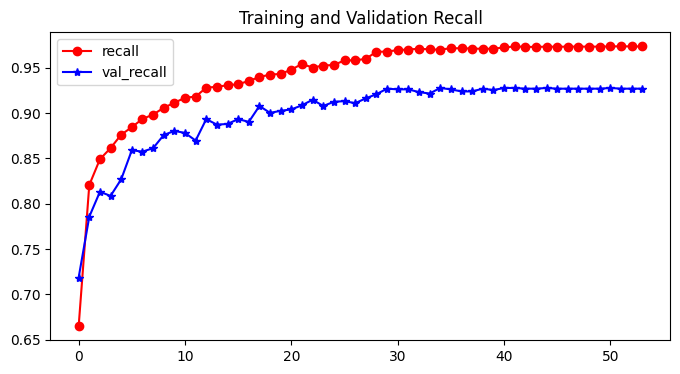

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
 3/41 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9201 - loss: 0.2155 - precision: 0.9189 - recall: 0.9010

W0000 00:00:1751366139.792942      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.9066 - loss: 0.2427 - precision: 0.9084 - recall: 0.8956
ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.185371 ║        0.934401 ║        18.5371 ║            93.4401 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

W0000 00:00:1751366151.978952      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step


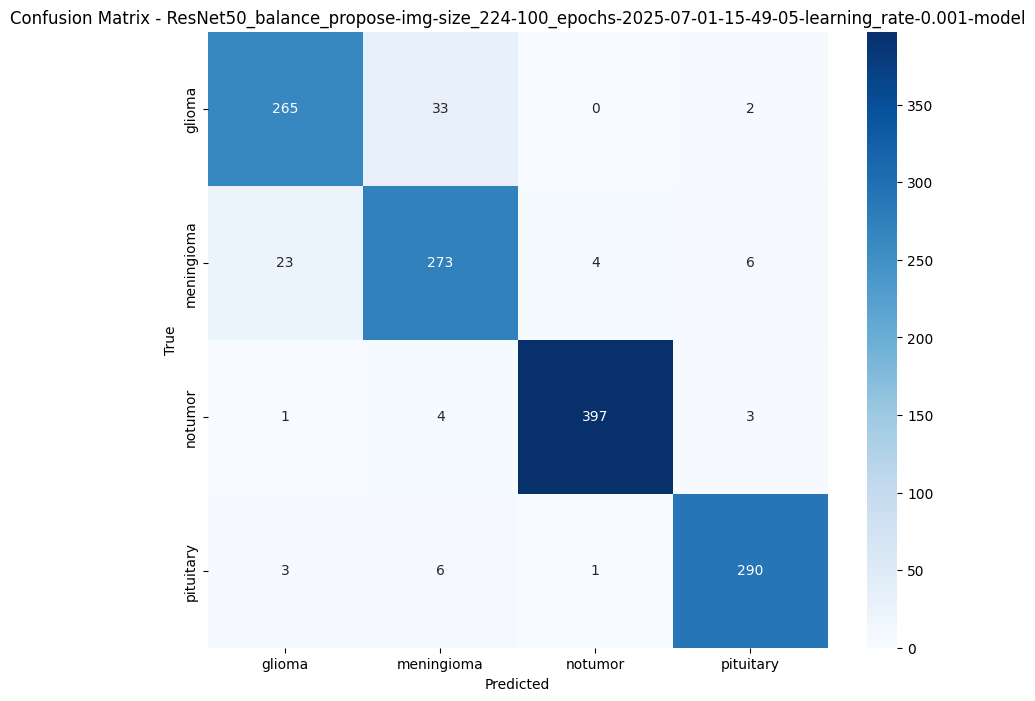

ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.883333 ║
║ meningioma ║        0.892157 ║
║  notumor   ║        0.980247 ║
║ pituitary  ║        0.966667 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.978527 ║
╚═════════════════════╩═════════════════════════════╝
Specificity ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.973294 ║
║ meningioma ║      0.957214 ║
║  notumor   ║      0.994481 ║
║ pituitary  ║      0.98912  ║
╚════════════╩═══════════════╝
RO

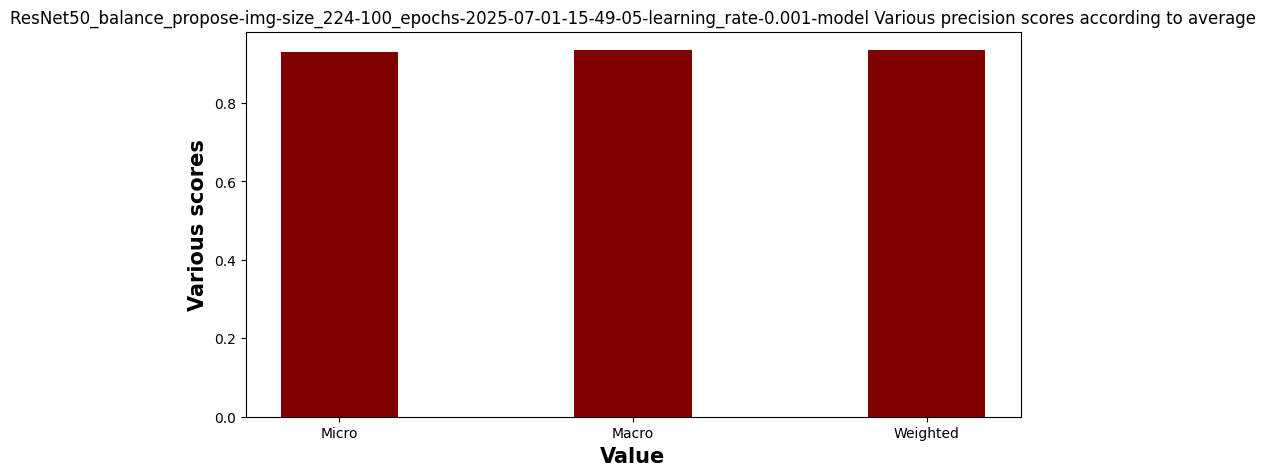

ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.883333 ║
║ meningioma ║       0.892157 ║
║  notumor   ║       0.980247 ║
║ pituitary  ║       0.966667 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.930601 ║             0.934401 ║                0.934401 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


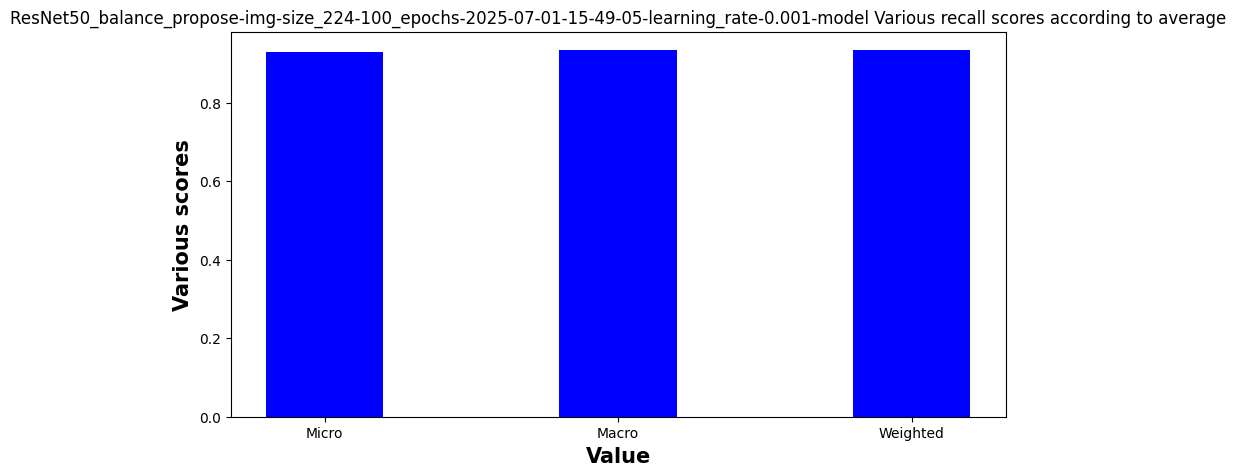

ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.89527  ║
║ meningioma ║   0.877814 ║
║  notumor   ║   0.983891 ║
║ pituitary  ║   0.965058 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.930508 ║         0.934401 ║            0.934543 ║
╚══════════════════╩══════════════════╩═════════════════════╝


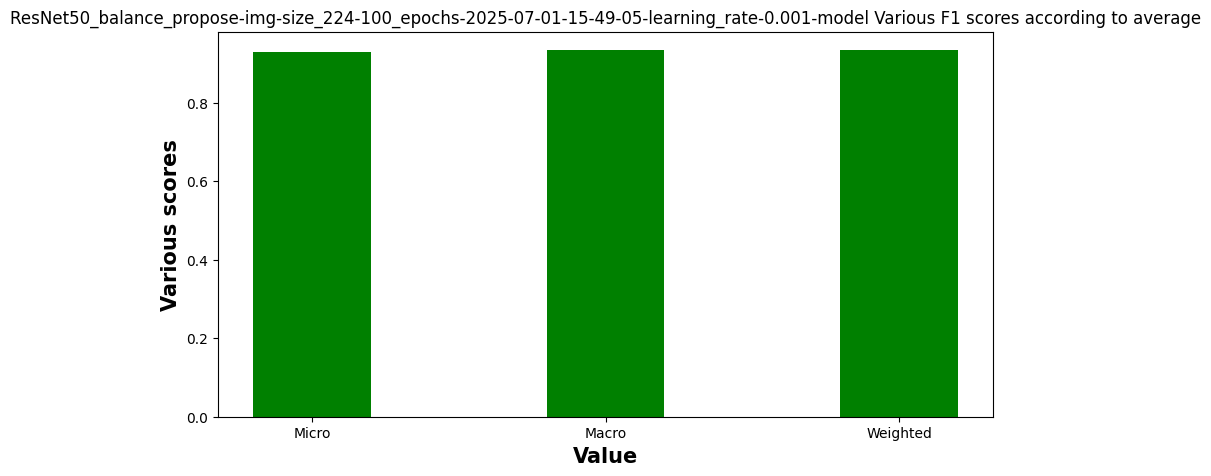

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classification Report : ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model
Cohen's Kappa Score ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.912008 ║
╚═══════════════════════╝
matthews_corrcoef Score ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                   0.91207 ║
╚═══════════════════════════╝
Model Log loss ResNet50_balance_propose-img-size_224-100_epochs-2025-07-01-15-49-05-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.185371 ║
╚════════════╝
---------- call model prediction ------------
taining model inside details  ResNet50_inbalance_propose 

taining model status ResNet50_inbalance_propose 

---------- model compile --

wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_103558-kdnlb4wx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/kdnlb4wx


---------- wandb callback start after loggin ------------
--- Trainned model data - ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_5, 	 	 | Shape :  None
Name : conv1_pad, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv1_conv, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : conv1_bn, 	 	 | Shape :  InputSpec(ndim=4, axes={3: 64})
Name : conv1_relu, 	 	 | Shape :  None
Name : pool1_pad, 	 	 | Shape :  InputSpec(ndim=4)
Name : pool1_pool, 	 	 | Shape :  InputSpec(ndim=4)
Name : conv2_block1_1_conv, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2_block1_1_bn, 	 	 | Shape :  InputSpec(ndim=4, axes={3: 64})
Name : conv2_block1_1_relu, 	 	 | Shape :  None
Name : conv2_block1_2_conv, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 64})
Name : conv2_block1_2_bn, 	 	 | Shape :  InputSpec(ndim=4, axes={3: 64})
Name : conv2_block1_2_relu, 	 	 | Shape :  None
Name : conv2_block1_0_

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.93364, saving model to propose.001.keras

Epoch 2: val_accuracy did not improve from 0.93364

Epoch 3: val_accuracy did not improve from 0.93364

Epoch 4: val_accuracy improved from 0.93364 to 0.93593, saving model to propose.004.keras

Epoch 5: val_accuracy did not improve from 0.93593

Epoch 6: val_accuracy improved from 0.93593 to 0.94050, saving model to propose.006.keras

Epoch 7: val_accuracy improved from 0.94050 to 0.94279, saving model to propose.007.keras

Epoch 8: val_accuracy did not improve from 0.94279

Epoch 9: val_accuracy did not improve from 0.94279

Epoch 10: val_accuracy did not improve from 0.94279

Epoch 11: val_accuracy did not improve from 0.94279

Epoch 12: val_accuracy did not improve from 0.94279

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 13: val_accuracy improved from 0.94279 to 0.94355, saving model to propose.013.keras

Epoch 14: val_accuracy did not improve from 0.94

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▁▂▂▂▃▃▃▅▄▄▅▅▇▇▇███████████
wandb:                     train/epoch_learning_rate ████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb:                              train/epoch_loss █▇▇▆▆▆▅▄▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▁▂▂▃▃▃▅▄▃▅▄▇█████████████
wandb:                            train/epoch_recall ▁▁▂▂▂▃▂▄▄▃▅▅▇█▇██▇████████
wandb:                             train/global_step ▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
wandb:                     validation/epoch_accuracy ▅▁▃▅▅▇▇▆▆▆▆▆█▆▇███▇▇▇███▇▇
wandb:                         validation/epoch_loss ▇██▅▆▅▄▂▃▆▄▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▅▁▃▅▃▆█▇▅▄▅▄▇▇█▇▇▇▇▇▇▇▇█▇▇
wandb:                       validation/epoch_recall ▂▁▂▃▄▆▅▅

---------- call model training history visualization ------------


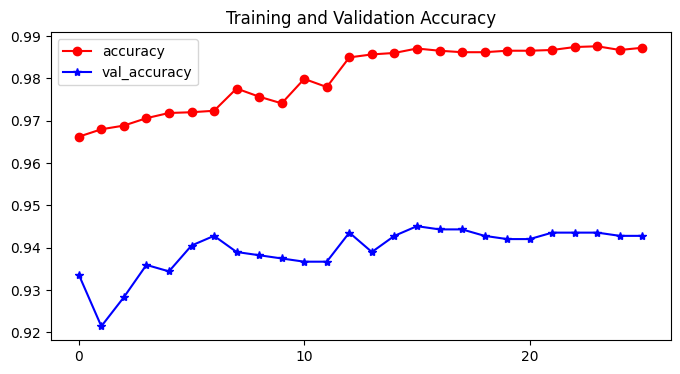

<Figure size 640x480 with 0 Axes>

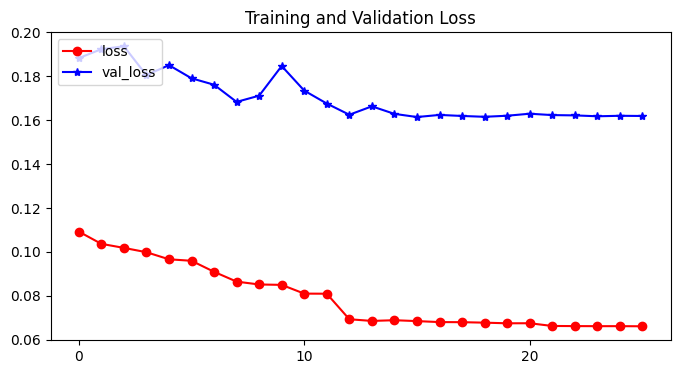

<Figure size 640x480 with 0 Axes>

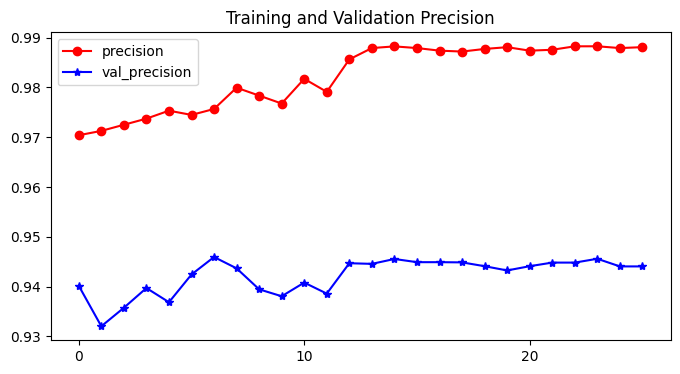

<Figure size 640x480 with 0 Axes>

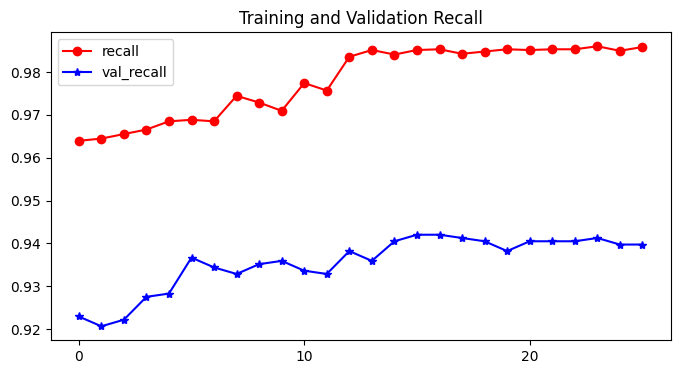

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
 3/41 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9479 - loss: 0.1842 - precision: 0.9479 - recall: 0.9479

W0000 00:00:1751366689.759798      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9192 - loss: 0.2210 - precision: 0.9187 - recall: 0.9138
ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.161451 ║         0.94508 ║        16.1451 ║             94.508 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
 5/41 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

W0000 00:00:1751366698.929074      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step


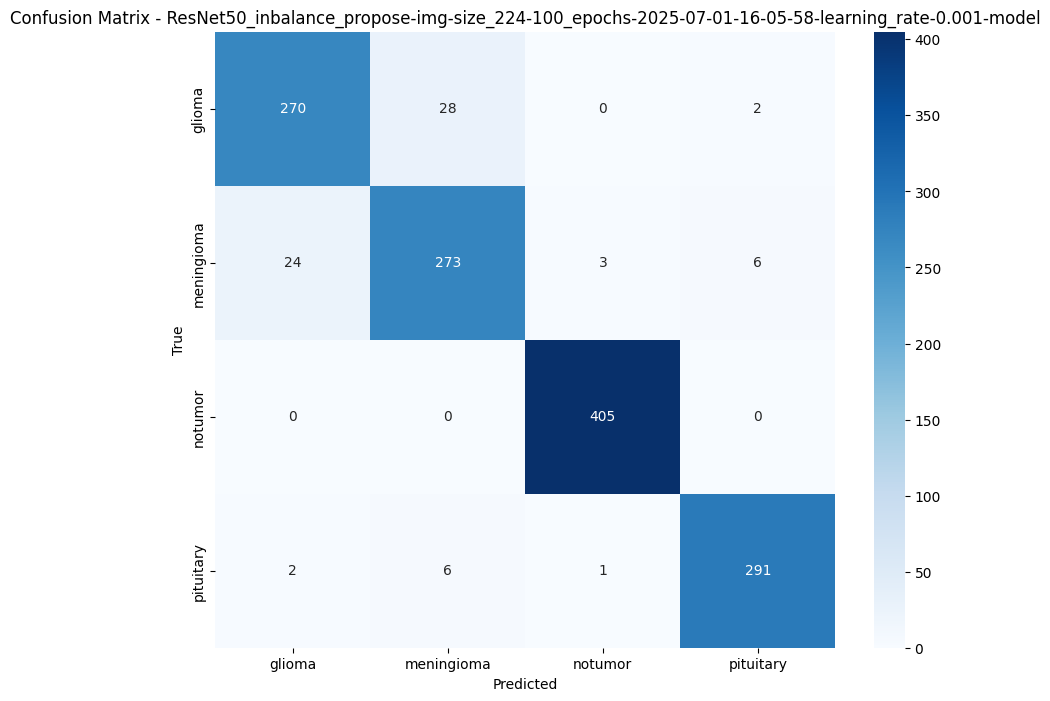

ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.9      ║
║ meningioma ║        0.892157 ║
║  notumor   ║        1        ║
║ pituitary  ║        0.97     ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.982031 ║
╚═════════════════════╩═════════════════════════════╝
Specificity ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.974283 ║
║ meningioma ║      0.966169 ║
║  notumor   ║      0.995585 ║
║ pituitary  ║      0.992087 ║
╚════════════╩═══════════════

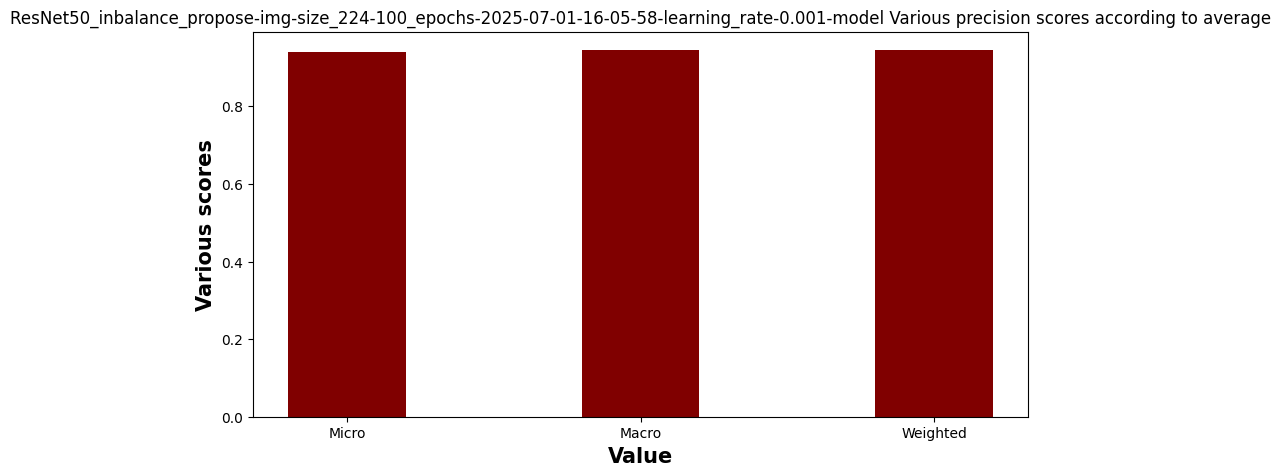

ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.9      ║
║ meningioma ║       0.892157 ║
║  notumor   ║       1        ║
║ pituitary  ║       0.97     ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.940539 ║              0.94508 ║                 0.94508 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


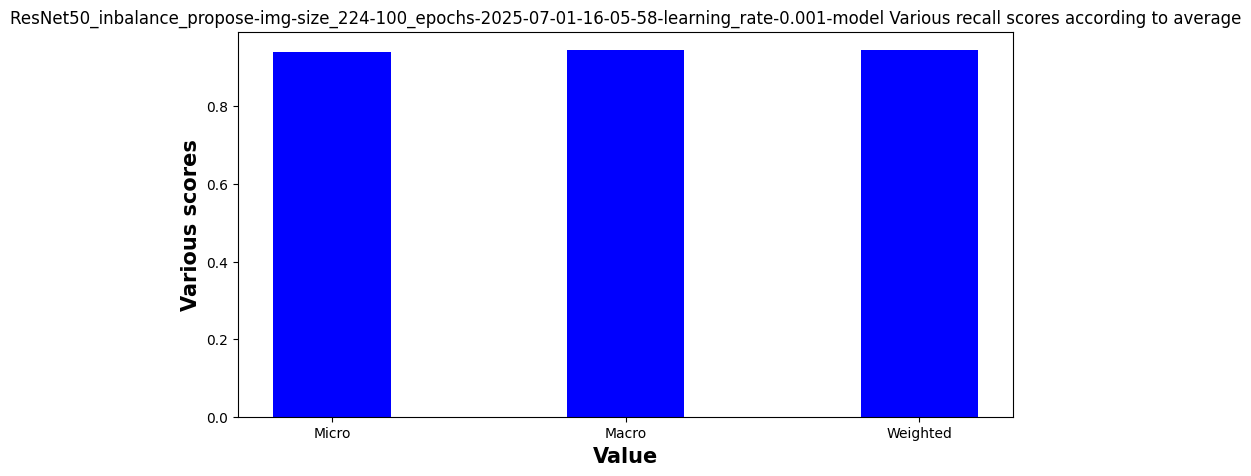

ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.90604  ║
║ meningioma ║   0.890701 ║
║  notumor   ║   0.995086 ║
║ pituitary  ║   0.971619 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.940862 ║          0.94508 ║            0.944975 ║
╚══════════════════╩══════════════════╩═════════════════════╝


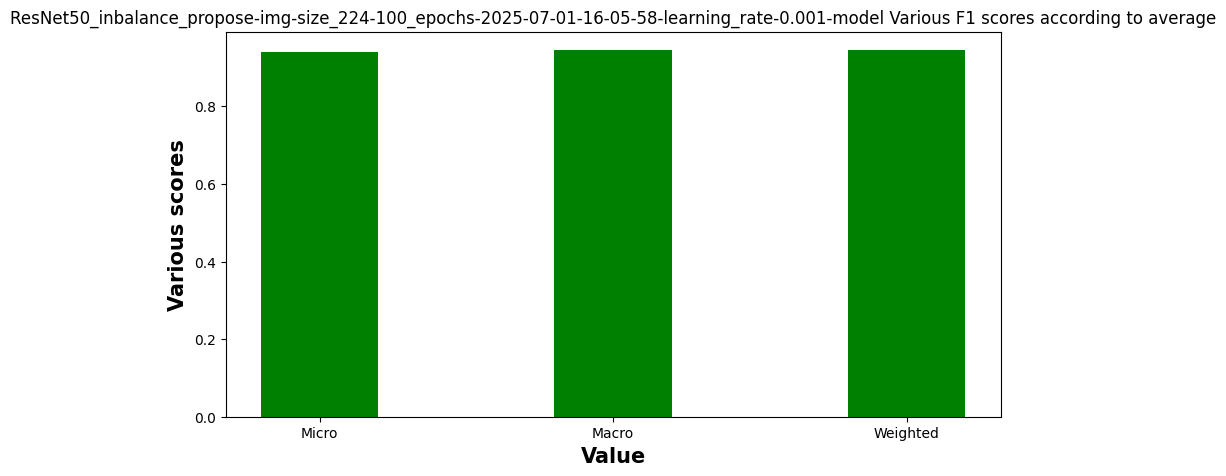

Classification Report : ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model
Cohen's Kappa Score ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.926293 ║
╚═══════════════════════╝
matthews_corrcoef Score ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.926305 ║
╚═══════════════════════════╝
Model Log loss ResNet50_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-05-58-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.161451 ║
╚════════════╝
---------- call model prediction ------------


In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D


# Load the ResNet50 model pre-trained on ImageNet with weights frozen
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the pre-trained layers to avoid retraining them
for layer in base_model.layers:
    layer.trainable = False


bmo = base_model.output
gap1 = GlobalAveragePooling2D()(bmo)

outputs = Dense(num_classes, activation="softmax")(gap1)

model = Model(inputs=base_model.input, outputs=outputs, name="ResNet50")

model_name = model.name
print(f"Model Start to train: ",model_name)
    
balance_model = model_name+"_balance_propose"
model_training_validation(model,balance_model,X_train_balance,Y_train_label_balance,x_test,y_test_label)
   
    
inbalance_model = model_name+"_inbalance_propose"
model_training_validation(model,inbalance_model,X_train_inbalance,Y_train_label_inbalance,x_test,y_test_label)

## 12.6 MobileNet Creation Training And Validation with Balance, Inbalance Data set

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model Start to train:  MobileVNet
taining model inside details  MobileVNet_balance_propose 

taining model status MobileVNet_balance_propose 

---------- model compile ------------
---------- model checkpoint callback ------------
---------- tensorboard callback ------------
---------- wandb callback start after loggin ------------


wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_104507-i76trqij
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/i76trqij


---------- wandb callback start after loggin ------------
--- Trainned model data - MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_6, 	 	 | Shape :  None
Name : Conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : bn_Conv1, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 32})
Name : Conv1_relu, 	 	 | Shape :  None
Name : expanded_conv_depthwise, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 32})
Name : expanded_conv_depthwise_BN, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 32})
Name : expanded_conv_depthwise_relu, 	 	 | Shape :  None
Name : expanded_conv_project, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 32})
Name : expanded_conv_project_BN, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 16})
Name : block_1_expand, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 16})
Name : block_1_expand_BN, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 96})
Name : block_1_expand_relu, 	 	 | Shape :  Non

Model: "MobileVNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.88024, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.88024 to 0.88940, saving model to propose.002.keras

Epoch 3: val_accuracy improved from 0.88940 to 0.90847, saving model to propose.003.keras

Epoch 4: val_accuracy improved from 0.90847 to 0.92449, saving model to propose.004.keras

Epoch 5: val_accuracy did not improve from 0.92449

Epoch 6: val_accuracy improved from 0.92449 to 0.93059, saving model to propose.006.keras

Epoch 7: val_accuracy did not improve from 0.93059

Epoch 8: val_accuracy did not improve from 0.93059

Epoch 9: val_accuracy did not improve from 0.93059

Epoch 10: val_accuracy improved from 0.93059 to 0.94355, saving model to propose.010.keras

Epoch 11: val_accuracy improved from 0.94355 to 0.94661, saving model to propose.011.keras

Epoch 12: val_accuracy did not improve from 0.94661

Epoch 13: val_accuracy did not improve from 0.94661

Epoch 14: val_accuracy did not improve from 0.946

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:                          train/epoch_accuracy ▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████████
wandb:                     train/epoch_learning_rate ████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                              train/epoch_loss █▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                         train/epoch_precision ▁▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇████████████
wandb:                            train/epoch_recall ▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
wandb:                             train/global_step ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
wandb:                     validation/epoch_accuracy ▁▂▃▅▃▅▅▅▅▆▇▆▆▆▆▆█████████████
wandb:                         validation/epoch_loss █▆▅▄▆▃▄▄▃▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                    validation/epoch_precision ▁▁▄▄▂▅▄▄▅▆▇▆▆▆▆▆▇████████████
wandb:                       vali

---------- call model training history visualization ------------


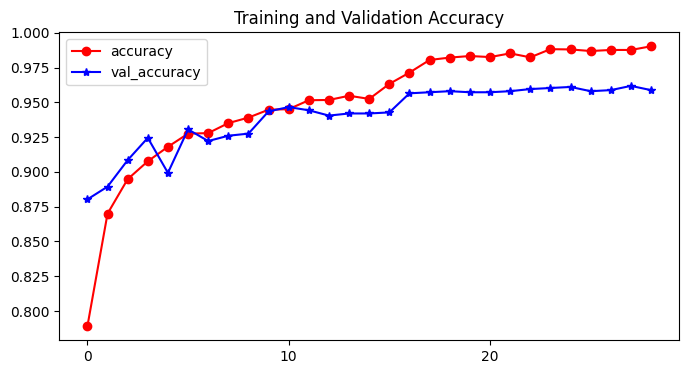

<Figure size 640x480 with 0 Axes>

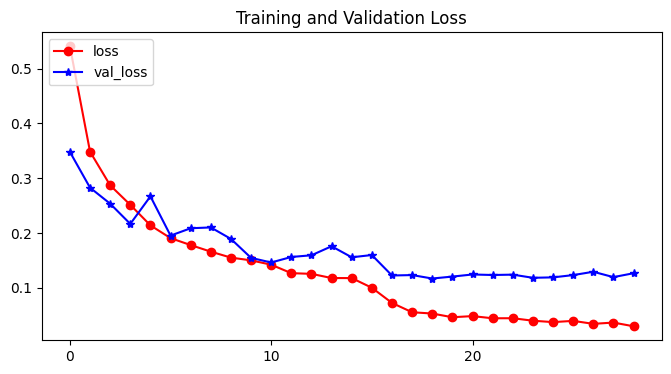

<Figure size 640x480 with 0 Axes>

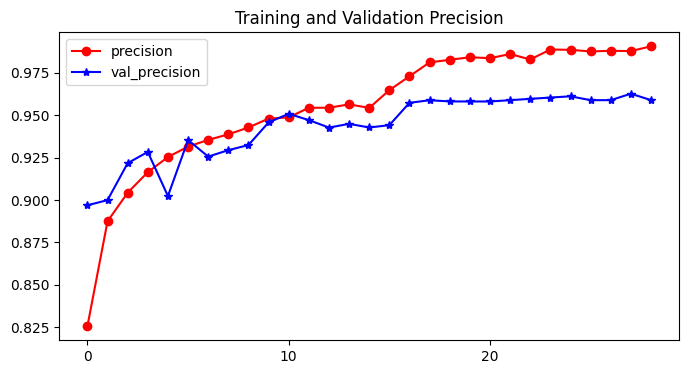

<Figure size 640x480 with 0 Axes>

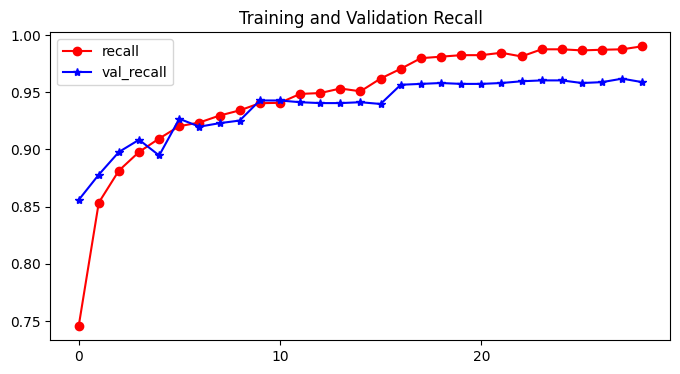

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9413 - loss: 0.1682 - precision: 0.9413 - recall: 0.9413
MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.116885 ║        0.958047 ║        11.6885 ║            95.8047 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step


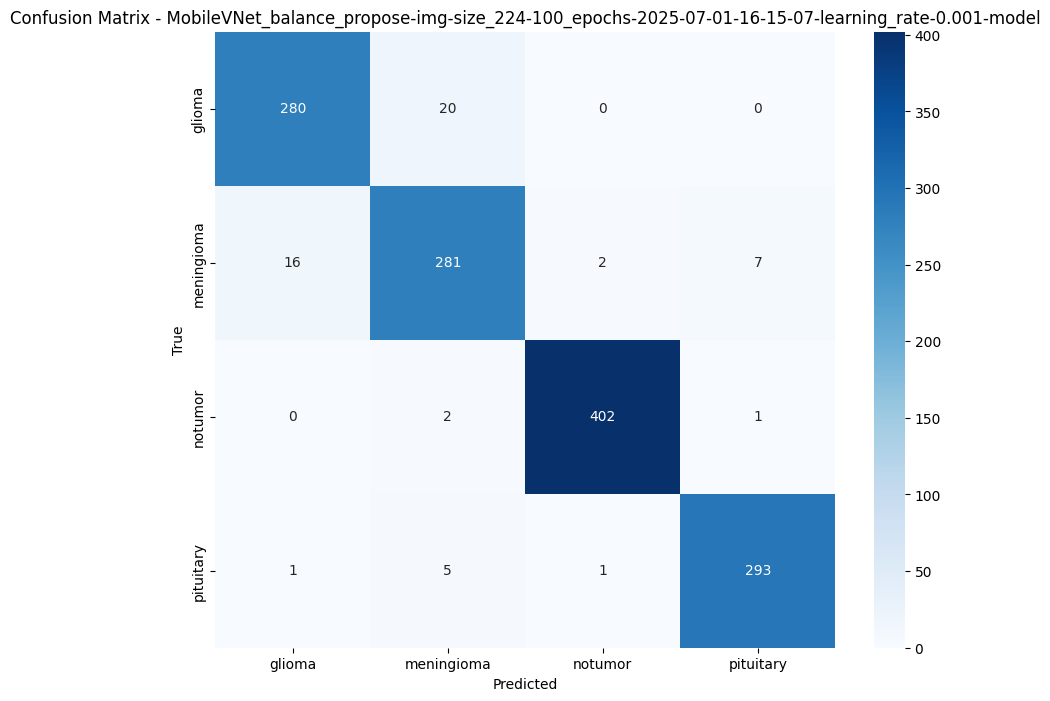

MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.933333 ║
║ meningioma ║        0.918301 ║
║  notumor   ║        0.992593 ║
║ pituitary  ║        0.976667 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.986274 ║
╚═════════════════════╩═════════════════════════════╝
Specificity MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.983185 ║
║ meningioma ║      0.973134 ║
║  notumor   ║      0.996689 ║
║ pituitary  ║      0.992087 ║
╚════════════╩═══════════════

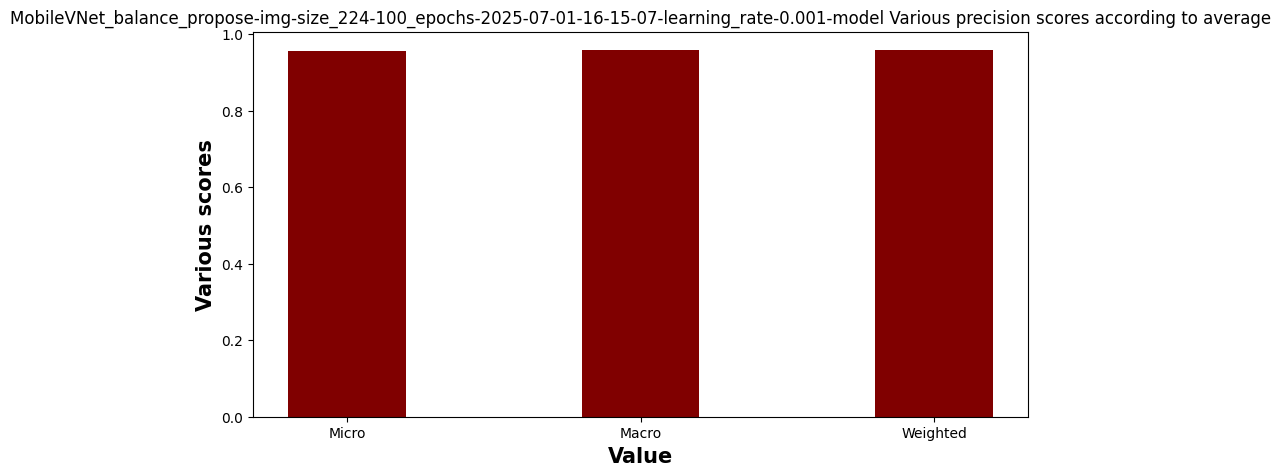

MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.933333 ║
║ meningioma ║       0.918301 ║
║  notumor   ║       0.992593 ║
║ pituitary  ║       0.976667 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.955223 ║             0.958047 ║                0.958047 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


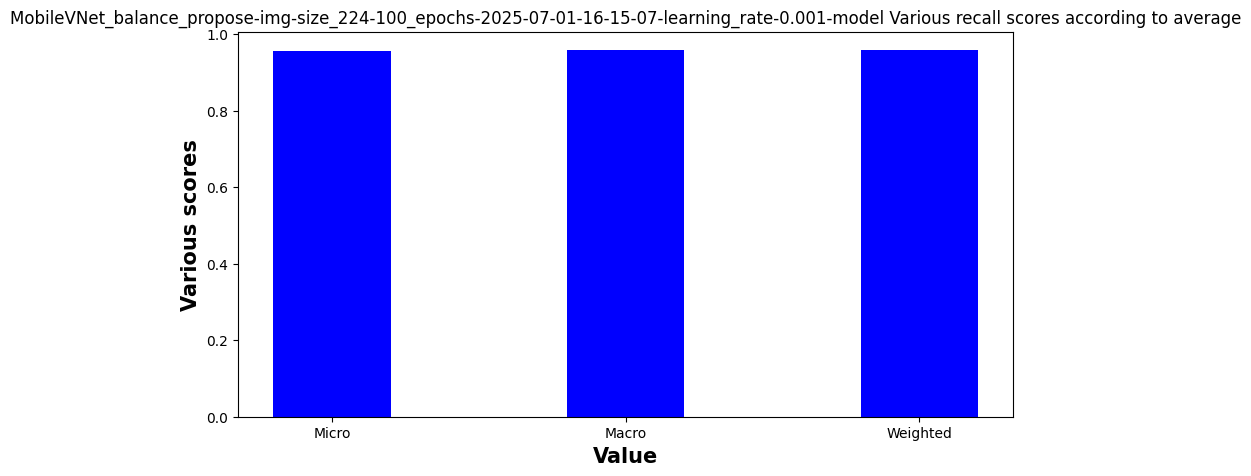

MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.938023 ║
║ meningioma ║   0.915309 ║
║  notumor   ║   0.992593 ║
║ pituitary  ║   0.975042 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.955242 ║         0.958047 ║             0.95805 ║
╚══════════════════╩══════════════════╩═════════════════════╝


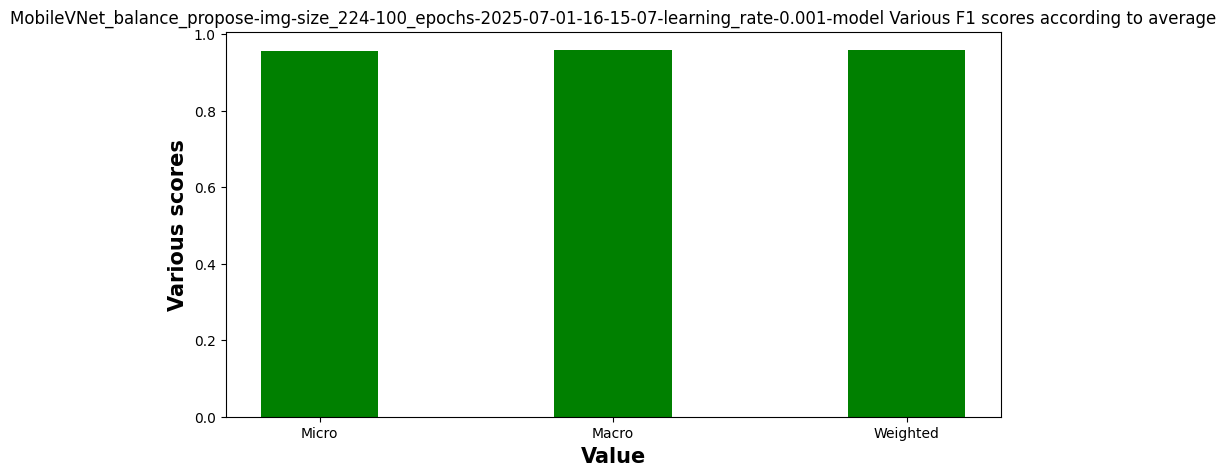

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Classification Report : MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model
Cohen's Kappa Score MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.943714 ║
╚═══════════════════════╝
matthews_corrcoef Score MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.943719 ║
╚═══════════════════════════╝
Model Log loss MobileVNet_balance_propose-img-size_224-100_epochs-2025-07-01-16-15-07-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.116885 ║
╚════════════╝
---------- call model prediction ------------
taining model inside details  MobileVNet_inbalance_propose 

taining model status MobileVNet_inbalance_propose 

---------- mode

wandb: wandb version 0.20.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250701_105041-6p4dvcw4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model
wandb: ⭐️ View project at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection
wandb: 🚀 View run at https://wandb.ai/lalithk90/deep-learning-approaches-for-brain-tumor-detection/runs/6p4dvcw4


---------- wandb callback start after loggin ------------
--- Trainned model data - MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model ---
The model is trained.
Name : input_layer_6, 	 	 | Shape :  None
Name : Conv1, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 3})
Name : bn_Conv1, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 32})
Name : Conv1_relu, 	 	 | Shape :  None
Name : expanded_conv_depthwise, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 32})
Name : expanded_conv_depthwise_BN, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 32})
Name : expanded_conv_depthwise_relu, 	 	 | Shape :  None
Name : expanded_conv_project, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 32})
Name : expanded_conv_project_BN, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 16})
Name : block_1_expand, 	 	 | Shape :  InputSpec(min_ndim=4, axes={-1: 16})
Name : block_1_expand_BN, 	 	 | Shape :  InputSpec(ndim=4, axes={-1: 96})
Name : block_1_expand_relu, 	 	 | Shape :  N

Model: "MobileVNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

╔══════════════╦═════════════════╦════════════════════════════════════════════════════╦══════════════╦════════════════╦═══════════════╗
║   Image size ║   Learning rate ║                 Wandb project name                 ║   Batch size ║   Epochs count ║   Num classes ║
╠══════════════╬═════════════════╬════════════════════════════════════════════════════╬══════════════╬════════════════╬═══════════════╣
║          224 ║           0.001 ║ deep-learning-approaches-for-brain-tumor-detection ║           16 ║            100 ║             4 ║
╚══════════════╩═════════════════╩════════════════════════════════════════════════════╩══════════════╩════════════════╩═══════════════╝
---------- model start to fit ------------


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`



Epoch 1: val_accuracy improved from -inf to 0.93898, saving model to propose.001.keras

Epoch 2: val_accuracy improved from 0.93898 to 0.94966, saving model to propose.002.keras

Epoch 3: val_accuracy improved from 0.94966 to 0.95195, saving model to propose.003.keras

Epoch 4: val_accuracy improved from 0.95195 to 0.95881, saving model to propose.004.keras

Epoch 5: val_accuracy did not improve from 0.95881

Epoch 6: val_accuracy improved from 0.95881 to 0.96034, saving model to propose.006.keras

Epoch 7: val_accuracy did not improve from 0.96034

Epoch 8: val_accuracy did not improve from 0.96034

Epoch 9: val_accuracy did not improve from 0.96034

Epoch 10: val_accuracy did not improve from 0.96034

Epoch 11: val_accuracy did not improve from 0.96034

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 12: val_accuracy improved from 0.96034 to 0.96415, saving model to propose.012.keras

Epoch 13: val_accuracy improved from 0.96415 to 0.96568, savin

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                                   global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
wandb:                          train/epoch_accuracy ▁▁▃▂▃▃▂▃▄▃▄▆▇▇█▇█▇████
wandb:                     train/epoch_learning_rate ███████████▂▂▂▂▂▂▂▂▁▁▁
wandb:                              train/epoch_loss █▇▆▇▆▅▆▆▅▅▅▃▂▂▁▂▁▂▁▁▁▁
wandb:                         train/epoch_precision ▁▁▃▂▃▃▂▃▄▃▄▅▇▇█▇█▇▇███
wandb:                            train/epoch_recall ▁▁▃▂▃▃▂▃▄▃▄▆▇▇█▇█▇████
wandb:                             train/global_step ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇██
wandb:                     validation/epoch_accuracy ▁▄▄▆▆▆▃▆▃▄▄▇▇█▇▇▇▇████
wandb:                         validation/epoch_loss █▅▄▃▃▂▅▂▆▃▄▁▁▁▃▂▂▂▂▂▂▂
wandb:                    validation/epoch_precision ▁▃▅▆▆▆▄▆▃▄▄▇██▇▇▇▇████
wandb:                       validation/epoch_recall ▁▃▄▆▆▆▃▆▃▄▄▇▇█▇▇▇▇████
wandb:  validation/eva

---------- call model training history visualization ------------


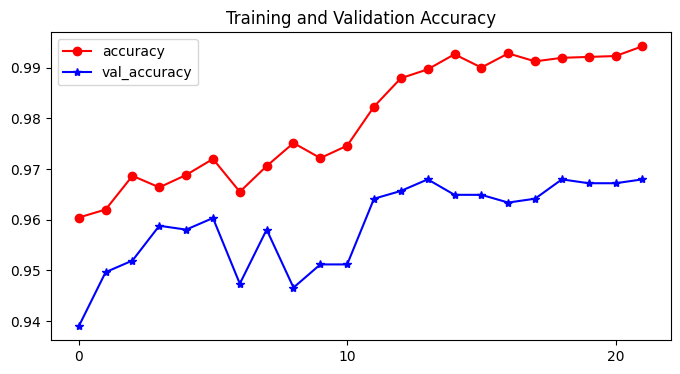

<Figure size 640x480 with 0 Axes>

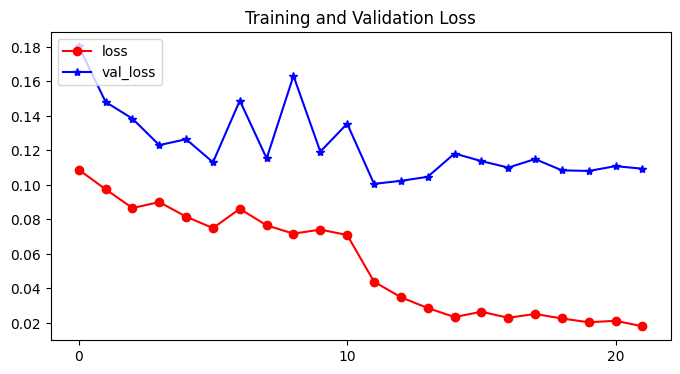

<Figure size 640x480 with 0 Axes>

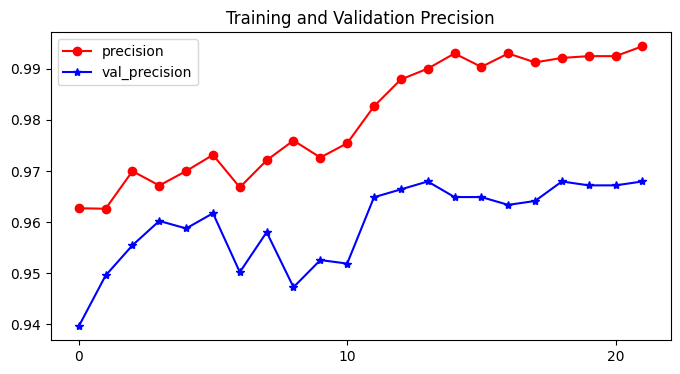

<Figure size 640x480 with 0 Axes>

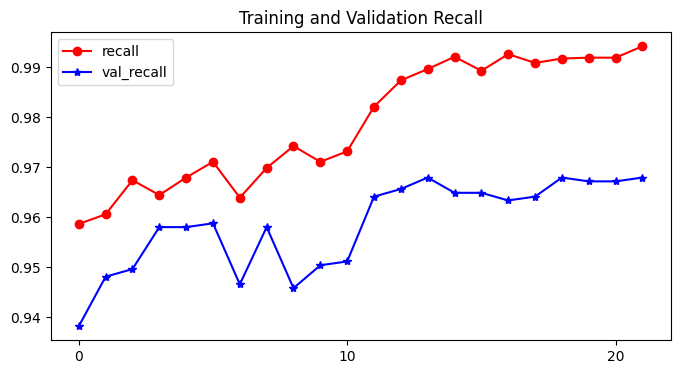

<Figure size 640x480 with 0 Axes>

---------- end model training history visualization ------------
---------- call model validation ------------
-----------start to call some validation ------------
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9441 - loss: 0.1578 - precision: 0.9443 - recall: 0.9441
MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model
╔═════════════╦═════════════════╦════════════════╦════════════════════╗
║   Test loss ║   Test accuracy ║   Test loss(%) ║   Test accuracy(%) ║
╠═════════════╬═════════════════╬════════════════╬════════════════════╣
║    0.100658 ║        0.964149 ║        10.0658 ║            96.4149 ║
╚═════════════╩═════════════════╩════════════════╩════════════════════╝
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step


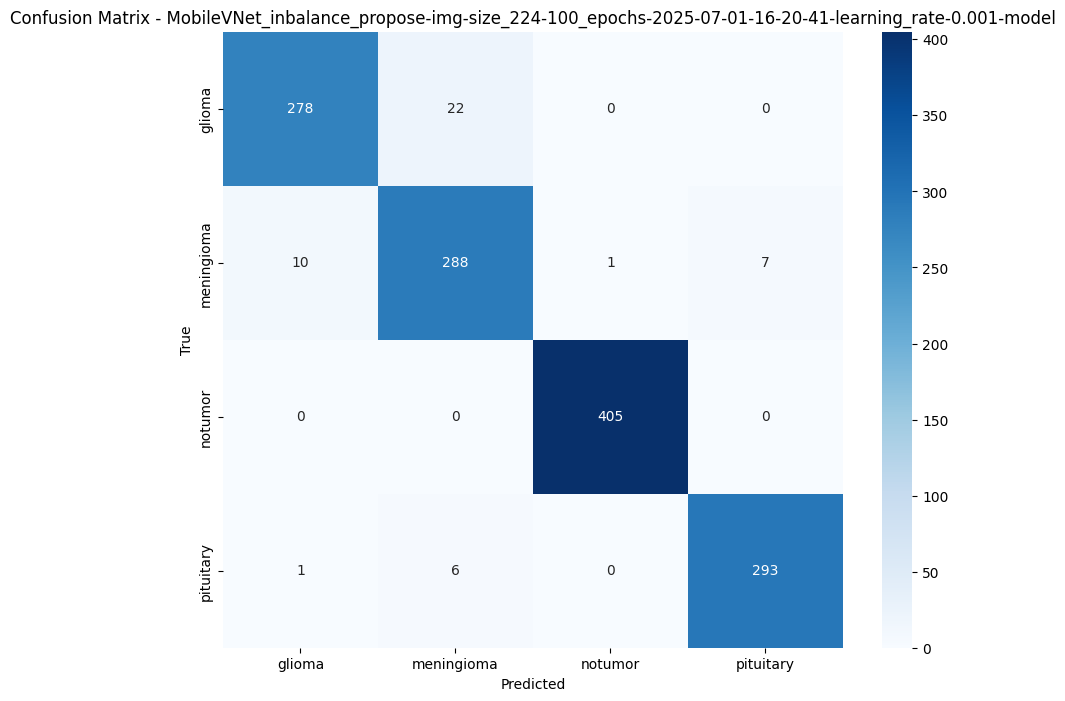

MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model Sensitivities
╔════════════╦═════════════════╗
║   Label    ║   Sensitivities ║
╠════════════╬═════════════════╣
║   glioma   ║        0.926667 ║
║ meningioma ║        0.941176 ║
║  notumor   ║        1        ║
║ pituitary  ║        0.976667 ║
╚════════════╩═════════════════╝
╔═════════════════════╦═════════════════════════════╗
║   Modal Sensitivity ║   Modal Average Sensitivity ║
╠═════════════════════╬═════════════════════════════╣
║                   2 ║                    0.988308 ║
╚═════════════════════╩═════════════════════════════╝
Specificity MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model
╔════════════╦═══════════════╗
║   Label    ║   Specificity ║
╠════════════╬═══════════════╣
║   glioma   ║      0.98912  ║
║ meningioma ║      0.972139 ║
║  notumor   ║      0.998896 ║
║ pituitary  ║      0.993076 ║
╚════════════╩═══════════

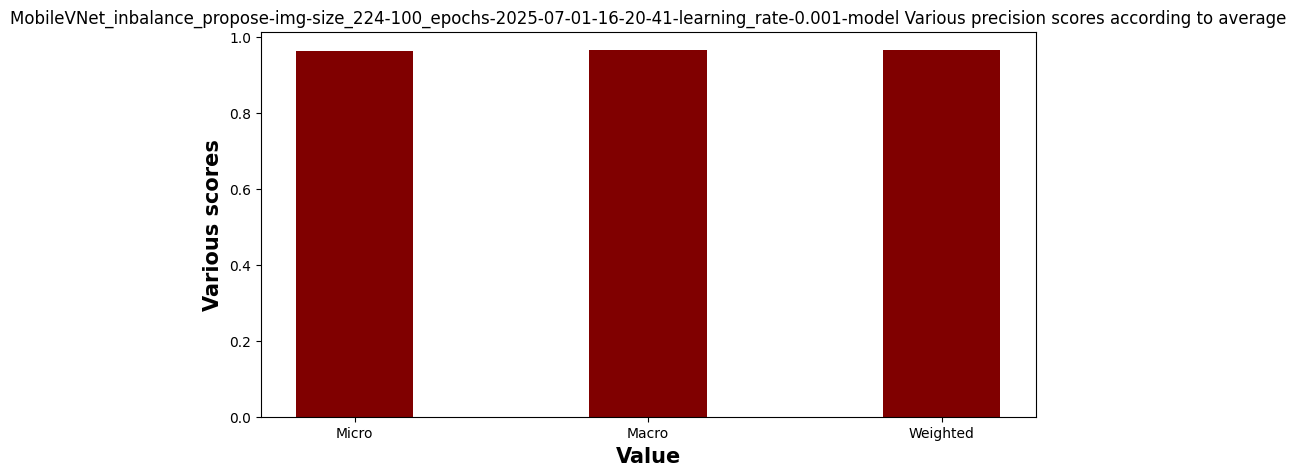

MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model Recall score 

╔════════════╦════════════════╗
║   Label    ║   Recall score ║
╠════════════╬════════════════╣
║   glioma   ║       0.926667 ║
║ meningioma ║       0.941176 ║
║  notumor   ║       1        ║
║ pituitary  ║       0.976667 ║
╚════════════╩════════════════╝
╔══════════════════════╦══════════════════════╦═════════════════════════╗
║   Recall score macro ║   Recall score micro ║   Recall score weighted ║
╠══════════════════════╬══════════════════════╬═════════════════════════╣
║             0.961127 ║              0.96415 ║                 0.96415 ║
╚══════════════════════╩══════════════════════╩═════════════════════════╝


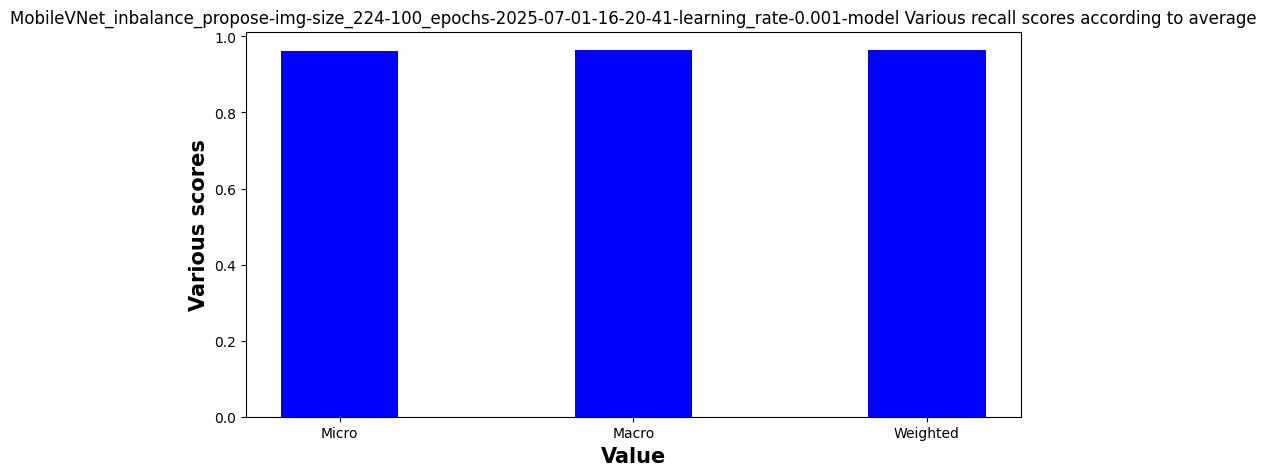

MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model F1 score 

╔════════════╦════════════╗
║   Label    ║   F1 score ║
╠════════════╬════════════╣
║   glioma   ║   0.943973 ║
║ meningioma ║   0.926045 ║
║  notumor   ║   0.998767 ║
║ pituitary  ║   0.976667 ║
╚════════════╩════════════╝
╔══════════════════╦══════════════════╦═════════════════════╗
║   F1 score macro ║   F1 score micro ║   F1 score weighted ║
╠══════════════════╬══════════════════╬═════════════════════╣
║         0.961363 ║          0.96415 ║            0.964197 ║
╚══════════════════╩══════════════════╩═════════════════════╝


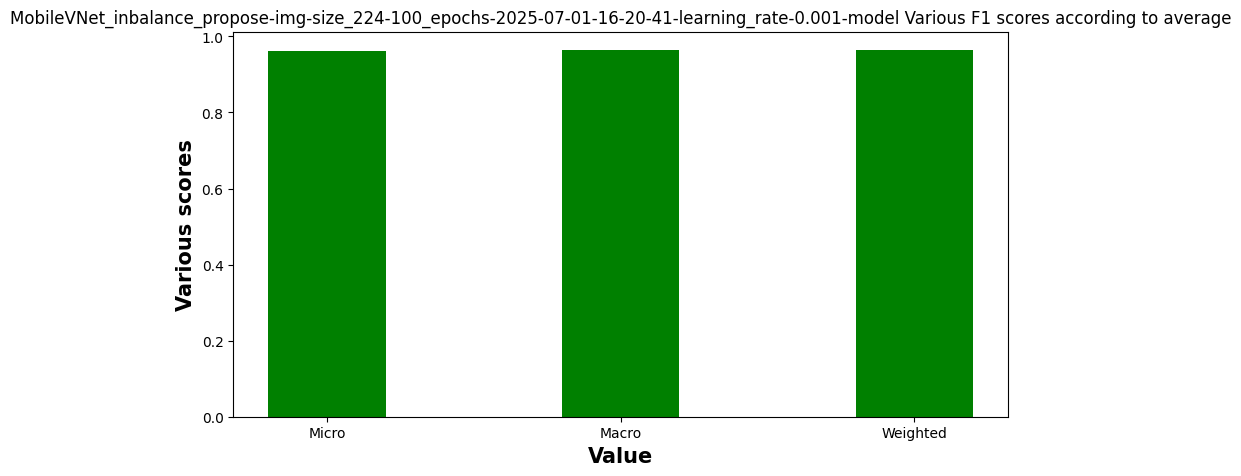

Classification Report : MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model
Cohen's Kappa Score MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model
╔═══════════════════════╗
║   Cohen's Kappa Score ║
╠═══════════════════════╣
║              0.951895 ║
╚═══════════════════════╝
matthews_corrcoef Score MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model
╔═══════════════════════════╗
║   matthews_corrcoef Score ║
╠═══════════════════════════╣
║                  0.951978 ║
╚═══════════════════════════╝
Model Log loss MobileVNet_inbalance_propose-img-size_224-100_epochs-2025-07-01-16-20-41-learning_rate-0.001-model
╔════════════╗
║   Log loss ║
╠════════════╣
║   0.100659 ║
╚════════════╝
---------- call model prediction ------------


In [26]:
from tensorflow.keras.applications import MobileNetV2

def build_mobilevnet(input_shape=(image_size, image_size, 3), num_classes=num_classes):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add Global Average Pooling and classification head
    bmo = base_model.output
    gap = GlobalAveragePooling2D()(bmo)
    dense = Dense(128, activation="relu")(gap)
    dropout = Dropout(0.5)(dense)
    outputs = Dense(num_classes, activation="softmax")(dropout)

    model_mobilevnet = Model(inputs=base_model.input, outputs=outputs, name="MobileVNet")
    return model_mobilevnet

model = build_mobilevnet()

model_name = model.name
print(f"Model Start to train: ",model_name)
    
balance_model = model_name+"_balance_propose"
model_training_validation(model,balance_model,X_train_balance,Y_train_label_balance,x_test,y_test_label)
   
    
inbalance_model = model_name+"_inbalance_propose"
model_training_validation(model,inbalance_model,X_train_inbalance,Y_train_label_inbalance,x_test,y_test_label)